In [1]:
# Parameters
attr_path = "/srv/stemly/data/7/index/3/attributes/attributes.csv"
index_path = "/srv/stemly/data/7/index/3/index/index.csv"
committed_files = ["/srv/stemly/data/7/index/3/timeseries/993/commit/ts.0/13.1661315396541.parquet",
                   "/srv/stemly/data/7/index/3/timeseries/993/commit/ts.0/13.1662444054358.parquet",
                   "/srv/stemly/data/7/index/3/timeseries/993/commit/ts.0/13.1662553683649.parquet"]
predict_ts_path = "/srv/stemly/data/7/index/3/timeseries/1434/staged/model/16/ts.predict.latest.parquet"
test_ts_path = "/srv/stemly/data/7/index/3/timeseries/1434/staged/model/16/ts.test.latest.parquet"
validate_ts_path = "/srv/stemly/data/7/index/3/timeseries/1434/staged/model/16/ts.validate.latest.parquet"
model = "custom"
model_file_id = "32"
model_resolution = None
reference_resolution = "MS"
project_offset = 1
project_periods = 18
project_resolution = "MS"
ts_train_start = "2020-07-01 00:00:00"
ts_train_v_end = "2022-05-01 00:00:00"
ts_train_t_end = "2022-04-01 00:00:00"
ts_train_p_end = "2022-06-01 00:00:00"
ts_test_start = "2022-04-01 00:00:00"
ts_test_end = "2022-05-01 00:00:00"
ts_test_duration = 1
ts_validate_start = "2022-05-01 00:00:00"
ts_validate_end = "2022-06-01 00:00:00"
ts_validate_duration = 1
ts_predict_start = "2022-06-01 00:00:00"
ts_predict_end = "2023-12-01 00:00:00"
ts_predict_duration = 18
redis_url = "redis://127.0.0.1:6300"
job_id = "6bf40e7f-aced-40f7-86fe-f49f8d23b343"
job_user_id = "3"
resource_id = "16"
resource_version = 1661403479559
resource_type = "modelbase"
workspace_id = "7"
job_name = "custom"
job_triggered_at = "2022-08-25 04:58:00"
job_triggered_by = "Mallikarjuna Reddy Padigapati"


price_file_paths = ["_input_data/price_df.parquet"]

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import tqdm 

from pg_features import get_features,get_events
from pg_model import NAIFCModel
from utils import get_dates, calc_metrics, install_old_pandas, upgrade_pandas

import seaborn as sns
from datetime import timedelta
import os
import write_data_table
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.forecasting.stl import STLForecast

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [3]:
workspace = 'w' + workspace_id
verbose = True

In [4]:
main_group_index = ['sku', 'customer', 'warehouse']
mat_group = 'sku'
freq = "MS"
load_data_from_local = False
export_data = True

In [5]:
price_index = 1103

In [6]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [7]:
if load_data_from_local :
    price_var = 'price'
    volume_var = 'dc_offtake'
    main_group_index = ['sku', 'customer', 'warehouse']
    mat_group = 'sku'
else :
    price_var = 'y'
    volume_var = 'y'
    main_group_index = ['id']
    mat_group = 'sku'

In [8]:
joining_keys = ["ts"] + main_group_index
joining_keys

['ts', 'id']

## Helper

In [9]:
def get_results(predict_df, all_dates):
    results = pd.DataFrame()
    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id)].reset_index(
            drop=True)
        test = ts.loc[ts.ts.isin(all_dates["test"])].copy()

        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "id": _id,
            "test_start": all_dates["test"][0],
            "test_end": all_dates["test"][-1],
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results = results.append(metrics, ignore_index=True, sort=False)

    main_cols = ["id", "test_start", "test_end", "total_actual", "total_forecast"]
    results = results[main_cols + list(results.drop(columns=main_cols).columns)].copy()
    results["mad"] = np.abs(results["total_actual"] - results["total_forecast"])
    results["model"] = predict_df.model[0]

    return results

## Dates

## Load data

In [10]:
att_main = pd.read_excel('Attribute_and_data_points.xlsx', sheet_name='Attributes_China')
att_main.rename(columns={'SKU Description':'sku_description','Level2':'ph_level2','sku type':'item_type','units':'uom'},inplace=True)
att_main['ph_level3'] = 'FAB'
att_main = att_main[['sku','shortname']]
att_main              

sku                           shortname
0   815517026036                         URC 2oz Jar
1   815517026265                         URC 4oz Jar
2   815517026005                         URC 6oz Jar
3   815517026050               Hydrating Serum 1.7oz
4   815517026067                   Oatmeal Toner 6oz
5   815517026043              Face moisturizer 1.7oz
6   815517027163                   Face cleanser 2oz
7   815517026029            URC Grapefruit Cream 2OZ
8   815517026999                        OCC 1.7fl oz
9   815517027491                    Retion eye 15ml 
10  815517027606                        BHA Gel 22ml
11  815517026081  Discountinued, no need to consider
12  815517027613             Oil Control Pads 28 pcs
13  815517025992                   Face cleanser 5oz
14  815517027170                    Oatmeal Mask 2oz
15  815517028122             Oil Control Toner 138ml
16  815517026012                        URC 2oz Tube
17  815517026272         Facial Radiance Pads 28 pcs

In [11]:
price_index = 1103

In [12]:
if load_data_from_local :
    att_df = pd.read_csv("../../Cleaned_Input/all_att_data.csv")
    vol_df = pd.read_parquet("../../Cleaned_Input/UI_Files/si_monthly_volume.parquet")
    price_df = pd.read_parquet("../../Cleaned_Input/UI_Files/si_monthly_price.parquet")
    list_price_df = pd.read_parquet("../../Cleaned_Input/UI_Files/si_monthly_price.parquet")
    
    vol_df.rename(columns={'date':'ts'},inplace=True)
    price_df.rename(columns={'date':'ts'},inplace=True)
    list_price_df.rename(columns={'date':'ts'},inplace=True)

if not load_data_from_local:
    path_index_val = os.listdir("/srv/stemly/data/{}/index".format(workspace_id))[0]
    path_index = "/srv/stemly/data/{}/index".format(workspace_id) + "/" + str(path_index_val)
    vol_df = pd.concat([pd.read_parquet(fp) for fp in committed_files])

    att_df = pd.read_csv(attr_path)
    price_parquet_file_path = path_index + "/timeseries/"+ str(price_index)+ "/commit/ts.0"
    price_file_names =  os.listdir(price_parquet_file_path)
    price_file_paths = [price_parquet_file_path+ "/" + i for i in price_file_names]
    print(price_file_paths)

    price_df = pd.concat([pd.read_parquet(fp) for fp in price_file_paths])


['/srv/stemly/data/7/index/3/timeseries/1103/commit/ts.0/13.1661315396541.parquet']


In [13]:
sub_group_index = ['ts','sku','customer']
att_df_sub = att_df[[ 'sku', 'customer', 'item_type', 'material', 'ph_level2', 'ph_level3',
       'sku_description', 'cases','uom']].drop_duplicates()


In [14]:
vol_df.rename(columns={volume_var:'y'},inplace=True)
price_df.rename(columns={price_var:'price'},inplace=True)

price_df = price_df[main_group_index+['price','ts']]
vol_df = vol_df[main_group_index+['y','ts']]

vol_df = vol_df.groupby(joining_keys).sum().reset_index()
price_df = price_df.groupby(joining_keys).mean().reset_index()
if not load_data_from_local:
    att_df.rename(columns={'__idx':'id'},inplace=True)

print(vol_df.shape)
df_base = pd.merge(vol_df, price_df, on =joining_keys, how='left')
df_base = pd.merge(df_base, att_df,  on = main_group_index, how='left')
df_base
df_base.loc[df_base['y'] < 0,'y'] = 0
print(df_base.shape)

df_sub = df_base[['ts','sku','customer','y','price']]
df_sub1 = df_sub.groupby(sub_group_index).agg({'y':'sum','price':'mean'}).reset_index()
df_sub1 = pd.merge(df_sub1,att_df_sub,on=['sku','customer'],how='left')
df_sub1['price'].replace([np.inf,0, 0.0, -np.inf],np.nan,inplace=True)
df_sub1['price'] = df_sub1.groupby(['sku','customer'])['price'].transform(lambda x: x.bfill())
df_sub1['price'] = df_sub1.groupby(['sku','customer'])['price'].transform(lambda x: x.ffill())
df_sub1['price'].replace([np.nan],0,inplace=True)
df_main = df_sub1.copy()
df_sub1.head()


(2409, 3)
(2409, 14)


ts           sku customer      y       price    item_type  material     ph_level2 ph_level3                           sku_description  cases uom
0 2020-07-01  815517026005    TMALL   49.0  263.877508        Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G
1 2020-07-01  815517026012    TMALL  164.0   73.642051        Cream  82314747  Ultra Repair       FAB  FAB UT RPAR CRM 2.0OZ 56.7GX24 TUB JUL20     24   G
2 2020-07-01  815517026029    TMALL    0.0  119.281356        Cream  82314725          Face       FAB   FAB CRM GRAPEFRUIT 2.0OZ 56.7GX24 SEP20     25   G
3 2020-07-01  815517026036    TMALL  614.0  112.946006        Cream  82314745  Ultra Repair       FAB  FAB UT RPAR CRM 2.0OZ 56.7GX24 JAR JUL20     24   G
4 2020-07-01  815517026043    TMALL    0.0  206.766623  Moisturizer  82314723  Ultra Repair       FAB  FAB UTRP MOISTURIZER 1.7OZ 50MLX24 SEP20     24  ML

In [15]:
from dateutil.relativedelta import relativedelta
def generate_dates_new(
        last_test_date="2021-12-27",
        gap_in_days=28,
        test_horizon_in_days=28,
        version_skip = 28,
        fc_horizon_in_days=84,
        freq="W-Mon",
        n_rounds=2
):
    ts_test_end = pd.to_datetime(last_test_date) 
    ts_test_start = ts_test_end - pd.Timedelta(days=test_horizon_in_days - 1)
   
    ts_predict_start = ts_test_end + pd.Timedelta(days=1)
    ts_predict_end = ts_predict_start + pd.Timedelta(days=fc_horizon_in_days-1)

   
    test_dates = pd.date_range(
        start=ts_test_start,
        end=ts_test_end,
        freq=freq,
    )
    forecast_dates = pd.date_range(
        start=ts_predict_start,
        end=ts_predict_end,
        freq=freq,
    )
    all_dates1 = df_main.ts.unique()
    train_dates = all_dates1[all_dates1 < np.min(test_dates)]
    a = test_dates[0].month
    all_dates_new = {
        str(test_dates[0].date()):  {
            "train" : pd.to_datetime(train_dates),
            "test": test_dates,
            "forecast": forecast_dates,
        },
    }
    for k in range(n_rounds):
        a = a - 1
        if a == 0:
            a = 12
        test_dates = pd.date_range(
            start=test_dates[0]- relativedelta(months=version_skip),
            end=test_dates[-1] - relativedelta(months=version_skip),
            freq=freq
        )
        forecast_dates = pd.date_range(
            start=forecast_dates[0]- relativedelta(months=version_skip),
            end=forecast_dates[-1] - relativedelta(months=version_skip),
            freq=freq
        )
        train_dates = all_dates1[all_dates1 < np.min(test_dates)]
        all_dates_new.update({
            str(test_dates[0].date()): {
                "train" : pd.to_datetime(train_dates),
                "test": test_dates,
                "forecast": forecast_dates,
            }
        })
    return all_dates_new


In [16]:
ts_test_end = "2022-08-01 00:00:00"
all_dates = generate_dates_new(
#     last_test_date="2021-12-27",
    last_test_date= ts_test_end,
    freq=freq,
    gap_in_days=30,
    version_skip = 1,
    fc_horizon_in_days = 367,
    test_horizon_in_days=30,
    n_rounds=2
)
all_dates

versions = []
for i in all_dates.keys():
    versions.append(i)
m=list(all_dates.keys())[0]
    
versions ,all_dates 

(['2022-08-01', '2022-07-01', '2022-06-01'],
 {'2022-08-01': {'train': DatetimeIndex(['2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01'], dtype='datetime64[ns]', freq=None),
   'test': DatetimeIndex(['2022-08-01'], dtype='datetime64[ns]', freq='MS'),
   'forecast': DatetimeIndex(['2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01'], dtype='datetime64[ns]', freq='MS')},
  '2022-07-01': {'train': DatetimeIndex(['2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021

In [17]:
data = df_main.copy()
data.head()

unique_id = data[['sku','customer']].drop_duplicates().reset_index(drop=True)
unique_id['id'] = unique_id.index
data = pd.merge(data,unique_id,on=['sku','customer'])
data.head()



def to_days(x):
    switcher = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
    return switcher.get(x)
def week_of_month(date_value):
    return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)
data["month"] = data["ts"].dt.month 
data["year"] = data["ts"].dt.year 

print(data.shape)
print(data.columns)
id_sales_train = data[data['ts'] <= all_dates[m]['test'][0]]
id_sales_train = id_sales_train.groupby('id')['y'].sum().reset_index()
id_with_sales_df = id_sales_train[id_sales_train['y'] > 0]
id_with_sales = id_with_sales_df.id.unique()
data = data[(data['id'].isin(id_with_sales))]


data = data[data['sku'] != 815517026081]  # Discontinued product. Asked by customer to remove

print(data.shape)
data.head()

(675, 15)
Index(['ts', 'sku', 'customer', 'y', 'price', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'cases', 'uom', 'id', 'month', 'year'], dtype='object')
(633, 15)


ts           sku customer       y       price item_type  material     ph_level2 ph_level3                           sku_description  cases uom  id  month  year
0 2020-07-01  815517026005    TMALL    49.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      7  2020
1 2020-08-01  815517026005    TMALL  1501.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      8  2020
2 2020-09-01  815517026005    TMALL   103.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      9  2020
3 2020-10-01  815517026005    TMALL  6780.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0     10  2020
4 2020-11-01  815517026005    TMALL  3996.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0     11  2020

## Features

In [18]:
gap = len(all_dates[m]["test"])
window = 4

In [19]:
df = data.copy()
df =  df[df['customer'] == 'TMALL']

In [20]:
from feature_engineering_nai import get_features
from feature_engineering_nai import get_events, get_events_full_data
from feature_engineering_nai import calc_metrics
from feature_engineering_nai import mean_encode

In [21]:
from pg_features import resample_data, make_future_df, extract_summary

In [22]:
events = get_events()
events['festival'] = events['festival'].astype('int64')
events['promotion_specific_date'] = events['promotion_specific_date'].astype('int64')
events['main_promo'] = events['main_promo'].astype('int64')
events['medium_promo'] = events['medium_promo'].astype('int64')
events['small_promo'] = events['small_promo'].astype('int64')
events_weekly = []

for h in events.holiday.unique():
    # for each event, resample it to W-Mon
    e = events.loc[events.holiday == h]
    e = e.set_index("ds").resample(freq, label="left").first()
    e.dropna(inplace=True)
    events_weekly.append(e.reset_index())
event_types = pd.get_dummies(events["type"]).columns.to_list()
event_types1 = pd.get_dummies(events["impact"]).columns.to_list()
events_weekly = pd.concat(events_weekly)
tmp = []
for t in events_weekly.ds.unique():
    e = events_weekly.loc[events_weekly.ds == t].reset_index(drop=True)
    if len(e) == 1:
        tmp.append(e.drop(columns=["lower_window", "upper_window"]))
    else:
        e.drop(columns=["lower_window", "upper_window"], inplace=True)
        e["holiday"] = ",".join(e["holiday"].tolist())
        e["type"] = ",".join(e["type"].tolist())
        _sum = e[event_types].sum()
        for c in event_types:
            e[c] = _sum[c]
        tmp.append(e.drop_duplicates())
events_weekly = pd.concat(tmp)
events_weekly.sort_values(by="ds", inplace=True)
events_weekly.reset_index(inplace=True, drop=True)
del tmp, e
events_monthly =  events_weekly
events_monthly.sort_values(by="ds", inplace=True)
events_monthly.reset_index(drop=True, inplace=True)
events_monthly.head()
events_monthly.sort_values(by=['ds','type'], inplace = True)
events.sort_values(by=['ds','type'], inplace = True)

In [23]:
value_var = 'y'
time_var="ts"
group_var="id"
non_static_cols=None
fill_with_nan = False
groups = None
summary_stats = None
use_val=False
nan_ratio=0.5
n_jobs=0
features_dfs = {}
for version in all_dates.keys():
    print("Resampling")
    df_resample = resample_data(
        df,
        value_var=value_var,
        time_var=time_var,
        group_var=group_var,
        freq=freq
    )
    print(df_resample.shape)

    # 2. make future
    print("Make future")
    df_future = make_future_df(
        df_resample,
        all_dates[version]["forecast"],
        date_col=time_var,
        non_static_cols=non_static_cols,
        fill_with_nan=fill_with_nan,
        freq=freq,
    )
     # 3. create days features
    print("Create days features")
    df_future["year"] = df_future["ts"].dt.year
    df_future["month"] = df_future["ts"].dt.month
    df_future["quarter"] = df_future["ts"].dt.quarter
    if freq == "W-Mon":
        df_future["woy"] = df_future["ts"].dt.isocalendar().week
        df_future["woy"] = df_future["woy"].astype(int)
    df_future["is_month_start"] = df_future["ts"].dt.is_month_start
    df_future["is_month_end"] = df_future["ts"].dt.is_month_end
    df_future["is_quarter_start"] = df_future["ts"].dt.is_quarter_start
    df_future["is_quarter_end"] = df_future["ts"].dt.is_quarter_end
    df_future["is_quarter_start"] = df_future["ts"].dt.is_quarter_start
    df_future["is_year_start"] = df_future["ts"].dt.is_year_start
    df_future["is_year_end"] = df_future["ts"].dt.is_year_end
    if groups is None:
        groups = [
            ["sku"],
            ["sku", "month"],
            ["month"]
        ]
        if freq == "MS":
            groups = groups[:-1]

    print("Create summary features")
    print(groups)
    df_summary = df_future.copy()
    for g in groups:
        df_summary = extract_summary(
            df_summary,
            all_dates[version],
            group=g,
            var_name=value_var,
            summary_stats=summary_stats,
            use_val=use_val,
        )
    
    df_feature = df_summary.copy()
    df_with_event =  get_events_full_data(df_feature, events_monthly, events, event_types, event_types1)
    
    
    _df = df_feature.copy()
    outlier_quantile=0.9
    _df = _df.loc[_df.ts < all_dates[m]["test"].min()].reset_index()
    aa = []
    for _id in _df.id.unique():

        ts = _df.loc[_df.id == _id]
        outliers = np.quantile(ts.y, outlier_quantile)
        ts = ts.loc[ts.y <= outliers]
        aa.append(ts)
    aa = pd.concat(aa)
    #aa = aa[aa['y'] > 0]
    avgs = aa.groupby(["id"])["y"].mean().reset_index()
    avgs.rename(columns={"y": "average_train_demand"}, inplace=True)
    df_with_train = pd.merge(df_with_event.copy(), avgs, on=["id"], how="left")
    print(version)
    a = df_with_train
    a = a[ (a['sku'] == 815517026005) & (a['ts'] == '2022-07-01')]
    a = a[['ts','y']]
    print(a)
    
    cols = ["y", "days_to_next_event", "days_since_last_event", "weeks_to_next_event", "weeks_since_last_event"]

    _df = df_with_train.copy()
    _df["lag_demand"] = _df.groupby(["id"])["y"].shift(12)
    _df.loc[_df['lag_demand'].isnull(),'lag_demand'] = _df.loc[_df['lag_demand'].isnull(),'y_mean_sku_month'] 
    df_with_train = _df.copy()
    features_dfs.update({version: df_with_train})


Resampling
(383, 15)
Make future
Create days features
Create summary features
[['sku'], ['sku', 'month']]
['sku', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku']
['sku', 'month', 'y_sum_sku_month', 'y_mean_sku_month', 'y_max_sku_month', 'y_min_sku_month', 'y_std_sku_month']
['festival', 'promotion_specific_date']
2022-08-01
           ts      y
24 2022-07-01  175.0
Resampling
(383, 15)
Make future
Create days features
Create summary features
[['sku'], ['sku', 'month']]
['sku', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku']
['sku', 'month', 'y_sum_sku_month', 'y_mean_sku_month', 'y_max_sku_month', 'y_min_sku_month', 'y_std_sku_month']
['festival', 'promotion_specific_date']
2022-07-01
           ts      y
24 2022-07-01  175.0
Resampling
(383, 15)
Make future
Create days features
Create summary features
[['sku'], ['sku', 'month']]
['sku', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku']
['sku', 'month', 'y_sum_sku_month', 'y_mean_sku_

from pg_features import resample_data, make_future_df, extract_summary

features_dfs = {}
for i in all_dates.keys():
    features_df = get_features(
        df.loc[df.ts <= all_dates[i]["test"].max()],
        all_dates[i],
        fill_with_nan=False,
        freq=freq,
        gap=gap,
        window=window,
        n_jobs=-1,
        use_val=False,
    )
    features_dfs.update({i: features_df})


In [24]:
df.columns

Index(['ts', 'sku', 'customer', 'y', 'price', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'cases', 'uom', 'id', 'month', 'year'], dtype='object')

### Cluster - Scaling

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering

In [26]:
x_clust_all = {}

this_df = df[df['ts'] < np.min(all_dates[m]['forecast'])]
x_clust = this_df.pivot_table(index="id", columns="ts", values="y").fillna(0)
a = MinMaxScaler().fit_transform(x_clust.transpose()).transpose()
x_clust.loc[:, :] = a
x_clust.head()

ts  2020-07-01  2020-08-01  2020-09-01  2020-10-01  2020-11-01  2020-12-01  2021-01-01  2021-02-01  2021-03-01  2021-04-01  2021-05-01  2021-06-01  2021-07-01  2021-08-01  2021-09-01  2021-10-01  2021-11-01  2021-12-01  2022-01-01  2022-02-01  2022-03-01  2022-04-01  2022-05-01  2022-06-01  2022-07-01  2022-08-01
id                                                                                                                                                                                                                                                                                                                        
0     0.000000    0.209463    0.007790    0.971004    0.569388    0.146567    0.106174    0.013993    0.083814    0.036642    0.007646    0.173832    0.006492    0.012262    0.094634    0.056838    1.000000    0.413445    0.188834    0.129256    0.264282    0.090739    0.307271    0.306838    0.018177    0.008511
1     0.002155    0.037667    0.009854    0.061341    0.038337    0.027537    0.033896    0.005045    0.022085    0.051146    0.007042    0.033725    0.004611    0.006372    1.000000    0.000000    0.003771    0.006976    0.065427    0.008632    0.009893    0.000000    0.000000    0.000053    0.000171    0.000000
2     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.068017    0.109294    0.405244    0.286604    0.211319    0.884476    0.178609    0.191848    0.652129    0.115784    1.000000    0.336449    0.326324    0.245067    0.321132    0.146937    0.262461    0.273624    0.045431    0.075026
3     0.000000    0.645660    0.051789    1.000000    0.530723    0.151126    0.141665    0.040841    0.199523    0.093426    0.041235    0.229817    0.013514    0.021999    0.178524    0.108569    0.844624    0.192022    0.184695    0.032168    0.055378    0.017725    0.045981    0.036119    0.005273    0.013176
4     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.056478    0.046512    0.197674    0.370432    0.157807    0.534884    0.063123    0.076412    0.378738    0.176080    1.000000    0.465116    0.390365    0.315615    0.795681    0.277409    0.538206    0.715947    0.212625    0.313953

ts_cols = ["id", "ts", "y"]
original_features = ["sku", "customer", 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'cases', 'uom', "price"]
dates_features = ["year", "month", "quarter", "is_month_start", "is_month_end", "is_quarter_start", "is_quarter_end", "is_year_start", "is_year_end"]
lag_features = [x for x in features_dfs[m].columns if "y_lag_" in x]
total_features = [x for x in features_dfs[m].drop(columns=ts_cols+original_features+dates_features+lag_features).columns[-60:]]
tsfresh_features = [x for x in features_dfs[m].drop(columns=ts_cols+original_features+dates_features+lag_features+total_features).columns]

In [27]:
n_clusters = 4
this_df = df[df['ts'] < np.min(all_dates[m]['forecast'])]

clust_model = AgglomerativeClustering(
    n_clusters=n_clusters,
    linkage="ward",
    compute_distances=True
)
clust_model = clust_model.fit(x_clust)



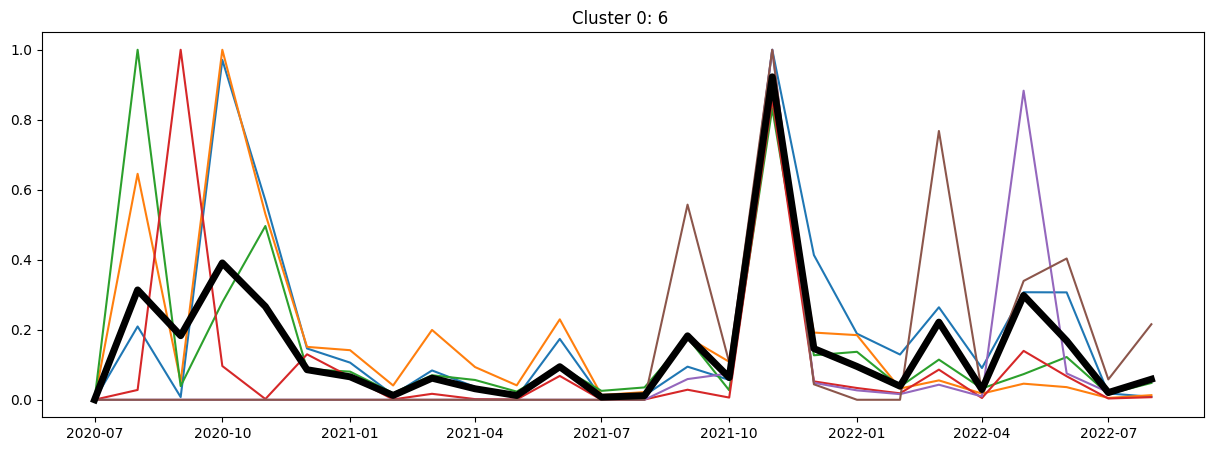

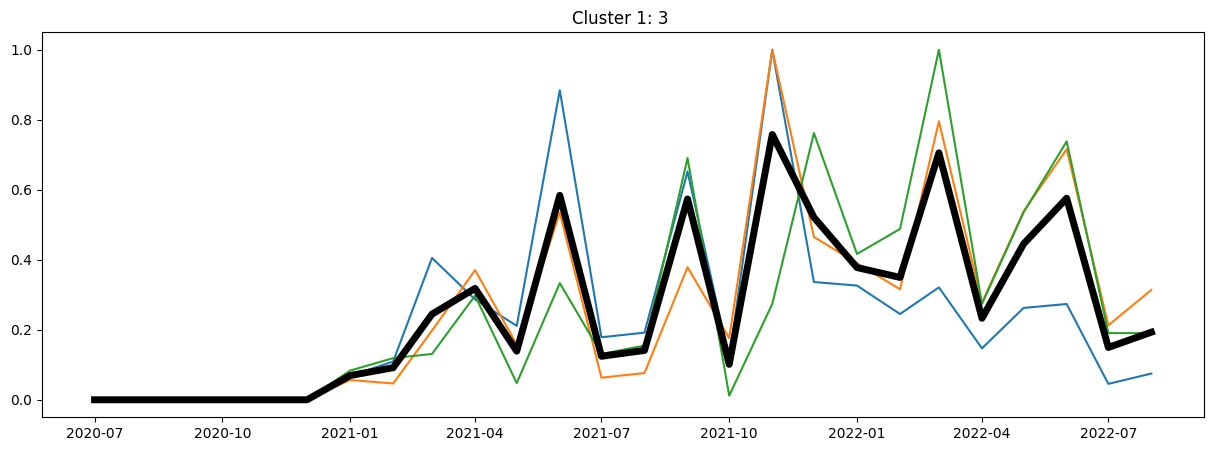

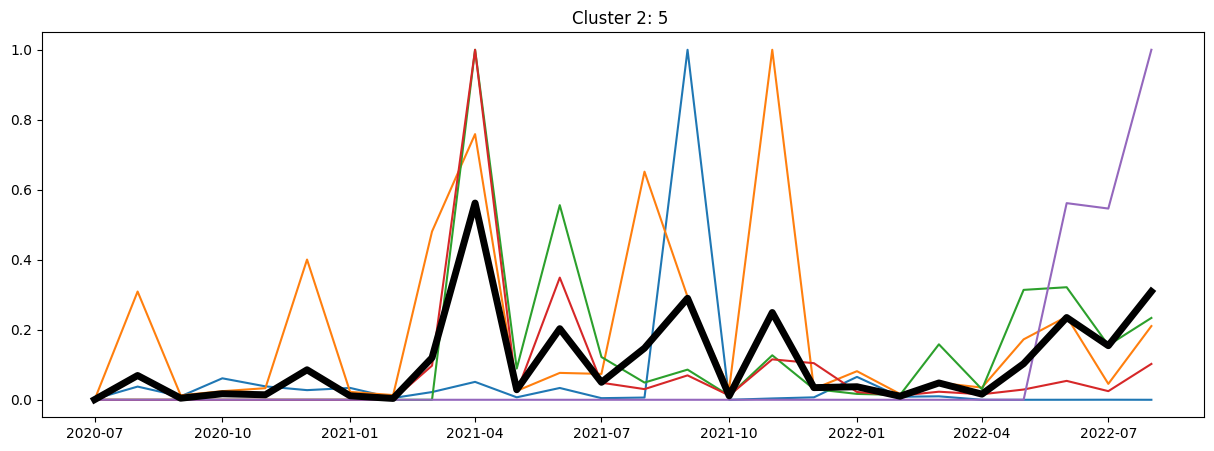

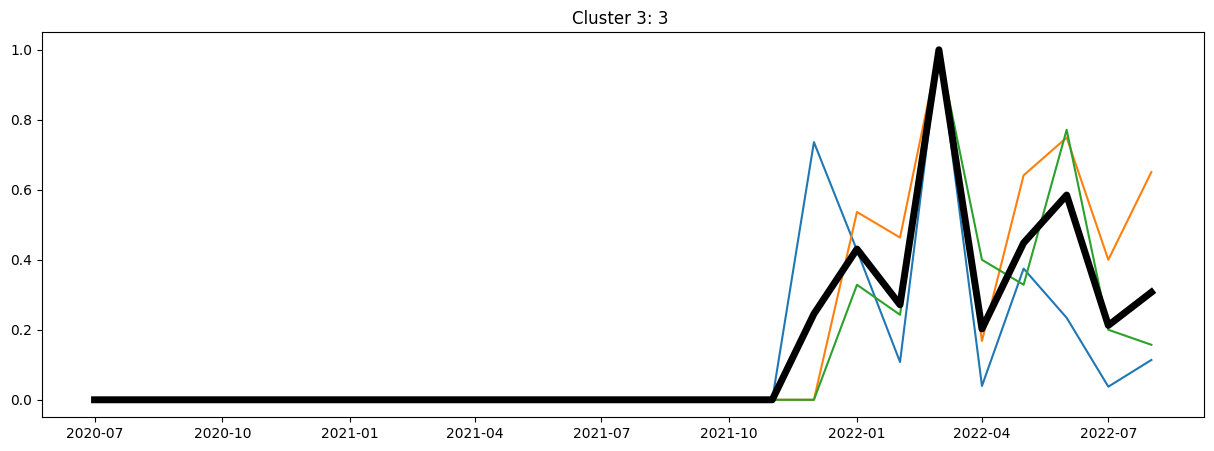

In [28]:
cluster_average = []
all_ids = x_clust.index
for i in range(n_clusters):
    idx = np.where(clust_model.labels_==i)
    idx2 = all_ids[idx[0]]

    ts = x_clust.loc[idx2].values
    t = x_clust.columns

    avg = ts.mean(axis=0)
    cluster_average.append(pd.DataFrame({"ts": t, "y": avg, "cluster": i}))

    plt.figure(figsize=(15,5))
    for j in range(ts.shape[0]):
        plt.plot(t, ts[j])
    plt.plot(t, avg, "k", linewidth=5)
    if ts.shape[0] == 1:
        plt.title("Cluster {}: ID: {}".format(i, idx[0][0]))
    else:
        plt.title("Cluster {}: {} ".format(i, ts.shape[0]))
    plt.show()
cluster_average = pd.concat(cluster_average).reset_index(drop=True)


In [29]:
cluster_data = x_clust.copy()
cluster_data['id'] = cluster_data.index
cluster_data['cluster'] = clust_model.labels_
cluster_data.reset_index(drop=True,inplace=True)
cluster_data = cluster_data[['id','cluster']]
cluster_data.head()


ts  id  cluster
0    0        0
1    1        2
2    2        1
3    3        0
4    4        1

In [30]:
def ets_forecast(
    series,
    train_dates,
    test_dates,
):    
    if len(series) > 0:
        # time series must not be empty!

        # fit parameters on val
        train = series.loc[series.index.isin(train_dates)]
        test = series.loc[series.index.isin(test_dates)]
            
        if np.sum(train) == 0:
            # special case when all the values are 0
            out = np.zeros(len(train)+len(test))
            
            return out
        if len(train) == 0:
            # special case when all the values are 0
            out = np.zeros(len(train)+len(test))
            
            return out

        # do cross validation
        configs = [True, False]
        error = ["add"]
        trend = ["add"]
        damped_trend = [True, False]
        seasonal = ["add"]
        seasonal_periods = [4,6,12]
        best_config = None
        best_metric = np.inf
        best_quantile = None
        best_model = None
        for q in [0.95, 0.96, 0.97, 0.98, 0.99]:
            for e in error:
                for t in trend:
                    for d in damped_trend:
                        for s in seasonal:
                            if s is None:
                                model = ETSModel(
                                    np.clip(train, 0, np.quantile(train[np.where(train > 0)[0][0]:], q)),
                                    error=e,
                                    trend=t,
                                    seasonal=s,
                                    damped_trend=d,
                                    seasonal_periods=None,
                                ).fit(disp=0)
                                
                                yhat = model.predict(0, len(train) - 1)
                                yhat = np.array(yhat)
                                yhat = np.clip(yhat, 0, None)
                                
                                rmse = (train.values - yhat) * (train.values - yhat)
                                rmse = np.sqrt(np.mean(rmse))

                                if rmse < best_metric:
                                    best_metric = rmse
                                    best_model = model
                            else:
                                for ss in seasonal_periods:
                                    try:
                                        model = ETSModel(
                                            np.clip(train, 0, np.quantile(train[np.where(train > 0)[0][0]:], q)),
                                            error=e,
                                            trend=t,
                                            seasonal=s,
                                            damped_trend=d,
                                            seasonal_periods=ss,
                                        ).fit(disp=0)
                                    except:
                                        model = ETSModel(
                                            np.clip(train, 0, np.quantile(train[np.where(train > 0)[0][0]:], q)),
                                            error=e,
                                            trend=t,
                                            seasonal=None,
                                            damped_trend=d,
                                            seasonal_periods=None,
                                        ).fit(disp=0)

                                    yhat = model.predict(0, len(train) - 1)
                                    yhat = np.array(yhat)
                                    yhat = np.clip(yhat, 0, None)

                                    rmse = (train.values - yhat) * (train.values - yhat)
                                    rmse = np.sqrt(np.mean(rmse))

                                    if rmse < best_metric:
                                        best_metric = rmse
                                        best_model = model

        # do forecast on train
        yhat_train = best_model.predict(0, len(train) - 1)
        yhat_train = np.array(yhat_train)
        yhat_train = np.clip(yhat_train, 0, None)
        
        # first forecast on test to get a sense of how well the model performs
        yhat_test = best_model.forecast(len(test))
        yhat_test = np.array(yhat_test)
        yhat_test = np.clip(yhat_test, 0, None)
        
        # concatenate all predictions
        out = np.concatenate((yhat_train, yhat_test))

        return out

    return None

In [31]:
def forecast_ets(
    data,
    dates,
    num_cores=-1,
    freq="MS",
):
    import multiprocessing
    from pandarallel import pandarallel
    
    import warnings
    import logging
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    
    np.seterr(divide='ignore', invalid='ignore')
    warnings.simplefilter('ignore', ConvergenceWarning)
    logging.getLogger('prophet').setLevel(logging.ERROR)
    
    if num_cores < 0:
        num_cores = multiprocessing.cpu_count()
    else:
        num_cores = min(num_cores, multiprocessing.cpu_count())
        
    pandarallel.initialize(
        nb_workers=num_cores,
        verbose=0,
        progress_bar=True
    )
    
    train_dates = dates["train"]
    test_dates = dates["test"]
    
    s = data.set_index(["id", "ts"], drop=True)["y"]
    s = s.unstack(0).fillna(0)
    s = s.asfreq(freq)
    
    print(train_dates)
    print(test_dates)
    yhat = s.parallel_apply(lambda x: ets_forecast(
        x,
        train_dates,
        test_dates,
    ), axis=0)
    
    

    yhat = yhat.reset_index(drop=True).apply(lambda x: pd.Series(x.dropna().values)).dropna()

    yhat["ts"] = pd.date_range(
        start=max(np.min(train_dates), data.ts.min()),
        end=np.max(test_dates),
        freq=freq
    )
    
    yhat = pd.melt(yhat, id_vars=['ts'], var_name="id", value_name="yhat")
    yhat = pd.merge(df, yhat, on=["ts", "id"], how="left")
    
    yhat = yhat[["id", "ts", "y", "yhat"]+[x for x in yhat.columns if x not in ["id", "ts", "y", "yhat"]]]
          
    return yhat.reset_index(drop=True)

In [32]:
pred_hws = {}
for i in range(len(versions)):
    pred_hw = forecast_ets(
        df,
        all_dates[versions[i]],
        num_cores=-1,
        freq=freq,
    )
    pred_hw.rename(columns={'yhat':'hw_yhat'}, inplace = True)
    pred_hws.update({versions[i]: pred_hw})

DatetimeIndex(['2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2022-08-01'], dtype='datetime64[ns]', freq='MS')


DatetimeIndex(['2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2022-07-01'], dtype='datetime64[ns]', freq='MS')


DatetimeIndex(['2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2022-06-01'], dtype='datetime64[ns]', freq='MS')


In [33]:
features_dfs[m].to_csv("op/sss.csv")

## Model 1 Cluster

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

features_dfs[m] = features_dfs[m].drop(axis=1, labels=total_features)
features_dfs[m] = features_dfs[m].drop(axis=1, labels=tsfresh_features)

In [35]:
df.head()

ts           sku customer       y       price item_type  material     ph_level2 ph_level3                           sku_description  cases uom  id  month  year
0 2020-07-01  815517026005    TMALL    49.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      7  2020
1 2020-08-01  815517026005    TMALL  1501.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      8  2020
2 2020-09-01  815517026005    TMALL   103.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      9  2020
3 2020-10-01  815517026005    TMALL  6780.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0     10  2020
4 2020-11-01  815517026005    TMALL  3996.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0     11  2020

In [36]:
drop_cols1 = [  'item_type', 'material', 
             'ph_level3', 'sku_description', 'cases', 'uom', 'year', 'quarter', 'lag_demand', 'month', 
             'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'y_sum_sku_month', 'y_max_sku_month', 'y_min_sku_month',
             'is_year_end', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku', 'sku_percent',
             'y_std_sku_month', 
             'sku_month_percent', 'events', 'type', 'impact', 'festival', 'promotion_specific_date', 
             'last_event', 'next_event', 
             'days_since_last_event', 'days_to_next_event', 'dummy_spike', 
             'dummy_event_spike', 'dummy_spike_before_event']

In [37]:
features_dfs[m].drop(drop_cols1, axis=1, errors = 'ignore').columns

Index(['id', 'ts', 'y', 'sku', 'customer', 'price', 'ph_level2', 'y_mean_sku_month', 'main_promo', 'medium_promo', 'small_promo', 'weeks_since_last_event', 'weeks_to_next_event', 'average_train_demand'], dtype='object')

In [38]:
datas = {}
encoders = {}
for i in range(len(versions)):
    dates = all_dates[versions[i]]
    f = features_dfs[versions[i]].copy()
    f = f[f['ts'] >= '2020-09-01']
    f = pd.merge(f,cluster_data[['id','cluster']],on='id',how='left')
    f = pd.merge(f, pred_hws[versions[i]][['ts','id','hw_yhat']], on=['id', 'ts'], how='left')
    #f.drop(lag_features, axis=1, inplace=True, errors = 'ignore')
    f.drop(drop_cols1, axis=1, inplace=True, errors = 'ignore')
    # get train, test, predict
    train = f.loc[f.ts < np.min(dates["test"])].reset_index(drop=True)
    test = f.loc[f.ts.isin(dates["test"])].reset_index(drop=True)
    predict = f.loc[f.ts.isin(dates["forecast"])].reset_index(drop=True)
    all_data = pd.concat([train, test]).reset_index(drop=True)

    train["y"] = train["y"].astype(float)
    test["y"] = test["y"].astype(float)
    predict["y"] = np.nan
    all_data["y"] = all_data["y"].astype(float)
    
    x_train, y_train = train.drop(columns=["y", "ts"]), train["y"]
    x_test, y_test = test.drop(columns=["y", "ts"]), test["y"]
    x_predict, y_predict = predict.drop(columns=["y", "ts"]), predict["y"]
    x_all, y_all = all_data.drop(columns=["y", "ts"]), all_data["y"]

    for c in x_train.select_dtypes(include=["number", "bool_"]).columns:
        x_train[c] = np.nan_to_num(x_train[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_test[c] = np.nan_to_num(x_test[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_predict[c] = np.nan_to_num(x_predict[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_all[c] = np.nan_to_num(x_all[c], nan=-9999, posinf=-9999, neginf=-9999)

    
    enc_cols = x_train.select_dtypes(exclude="number").columns.to_list()
    for col in enc_cols:
        enc = LabelEncoder()
        enc.fit(f[col])
        encoders.update({(versions[i], col): enc})
        x_train[col] = enc.transform(x_train[col])
        x_test[col] = enc.transform(x_test[col])
        x_predict[col] = enc.transform(x_predict[col])
        x_all[col] = enc.transform(x_all[col])
    print("forecast version {}".format(versions[i]))
    print(train.ts.min(), train.ts.max(), train.shape)
    print(test.ts.min(), test.ts.max(), test.shape)
    print(predict.ts.min(), predict.ts.max(), predict.shape)
    print()
    datas.update({
        versions[i] : {
            "all": all_data,
            "train": train,
            "test": test,
            "predict": predict,
            "x_train": x_train,
            "y_train": y_train,
            "x_test": x_test,
            "y_test": y_test,
            "x_predict": x_predict,
            "y_predict": y_predict,
            "x_all": x_all,
            "y_all": y_all
        }
    })

forecast version 2022-08-01
2020-09-01 00:00:00 2022-07-01 00:00:00 (338, 16)
2022-08-01 00:00:00 2022-08-01 00:00:00 (17, 16)
2022-09-01 00:00:00 2023-08-01 00:00:00 (204, 16)

forecast version 2022-07-01
2020-09-01 00:00:00 2022-06-01 00:00:00 (321, 16)
2022-07-01 00:00:00 2022-07-01 00:00:00 (17, 16)
2022-08-01 00:00:00 2023-07-01 00:00:00 (204, 16)

forecast version 2022-06-01
2020-09-01 00:00:00 2022-05-01 00:00:00 (304, 16)
2022-06-01 00:00:00 2022-06-01 00:00:00 (17, 16)
2022-07-01 00:00:00 2023-06-01 00:00:00 (192, 16)



2022-08-01 0
2022-08-01 2
2022-08-01 1
2022-08-01 3


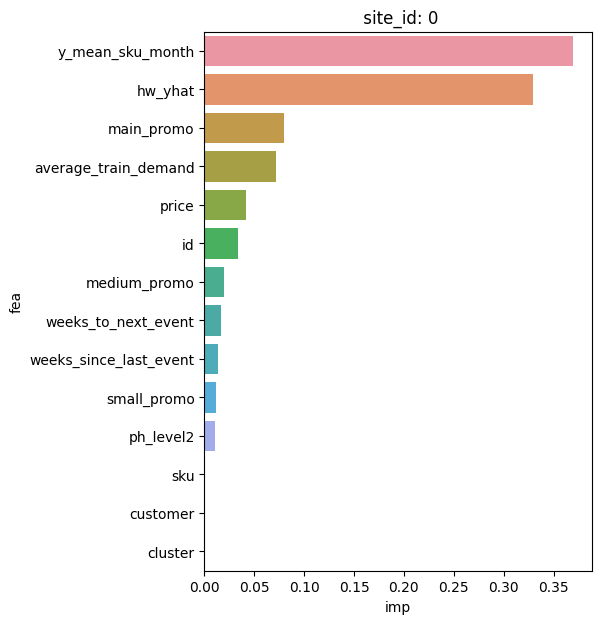

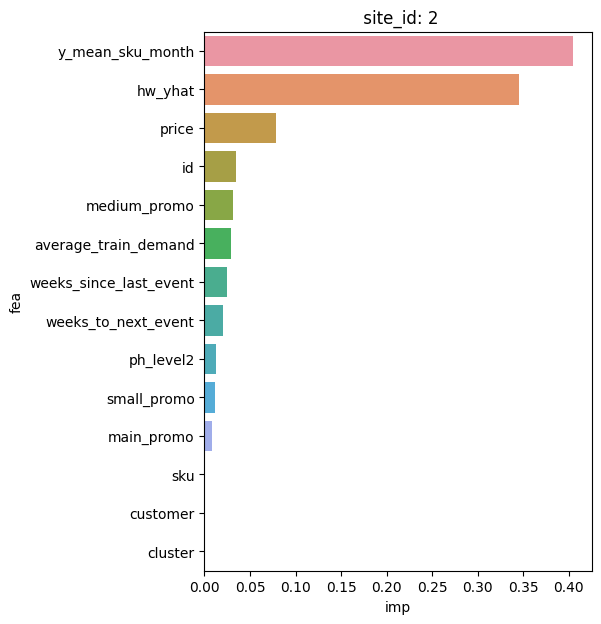

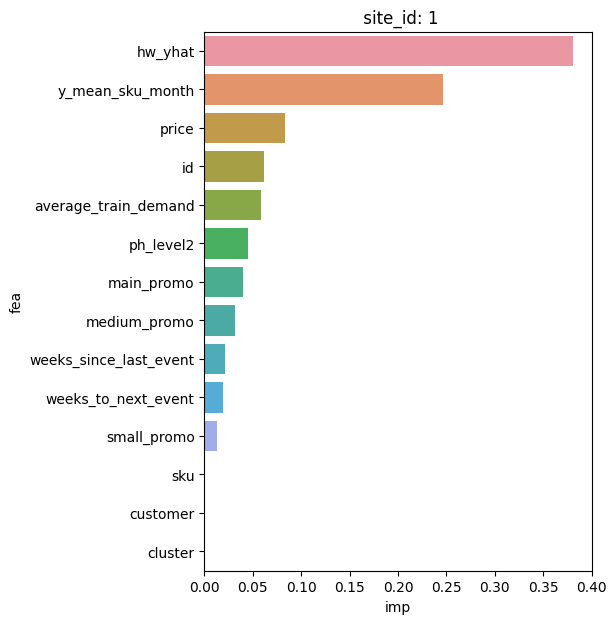

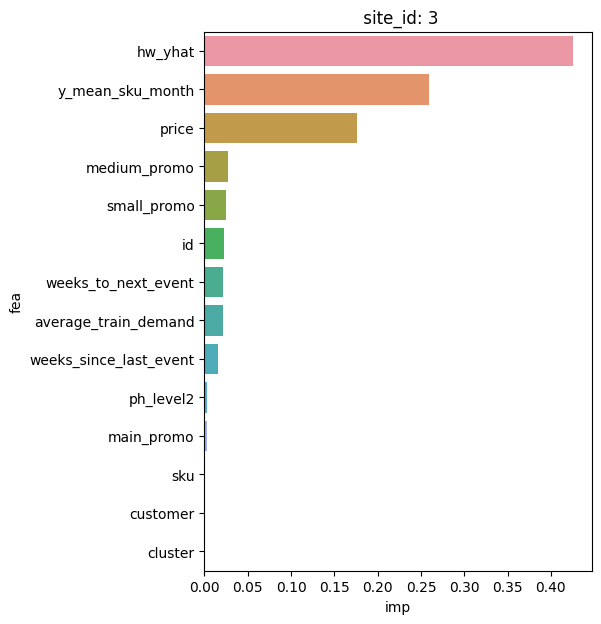

2022-07-01 0
2022-07-01 2
2022-07-01 1
2022-07-01 3


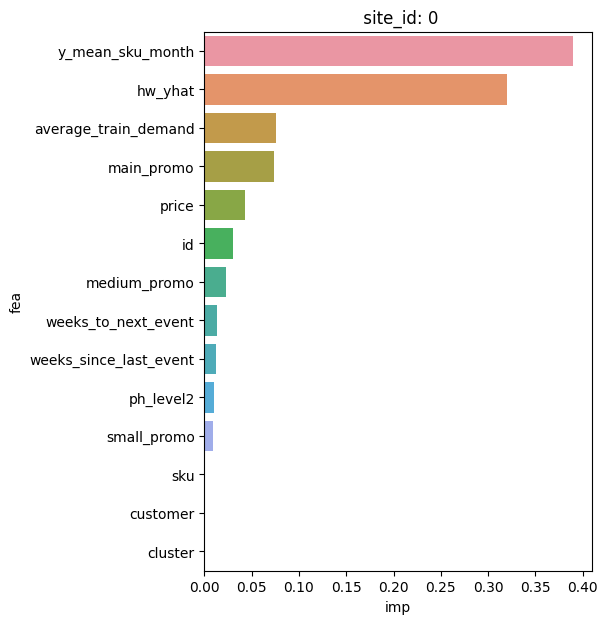

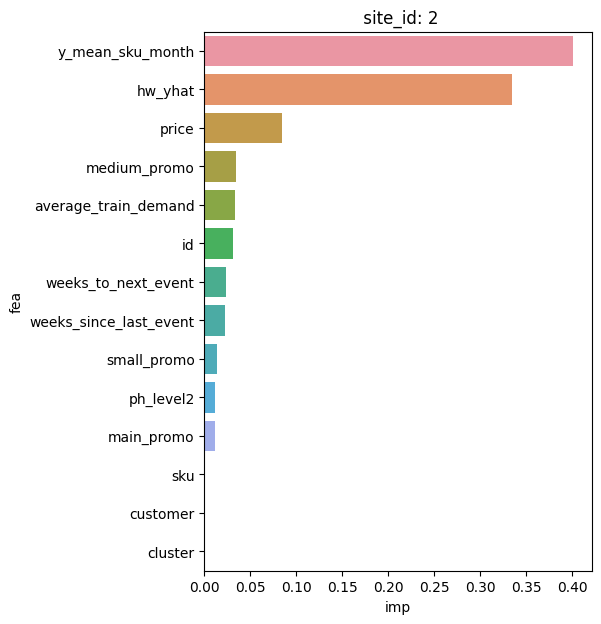

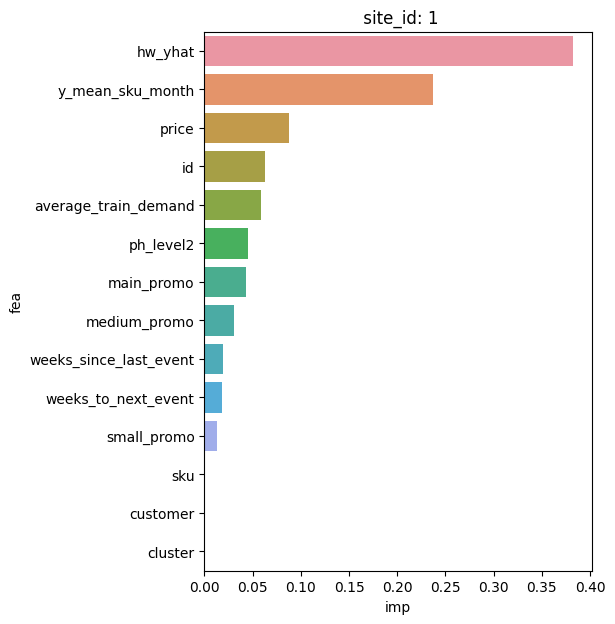

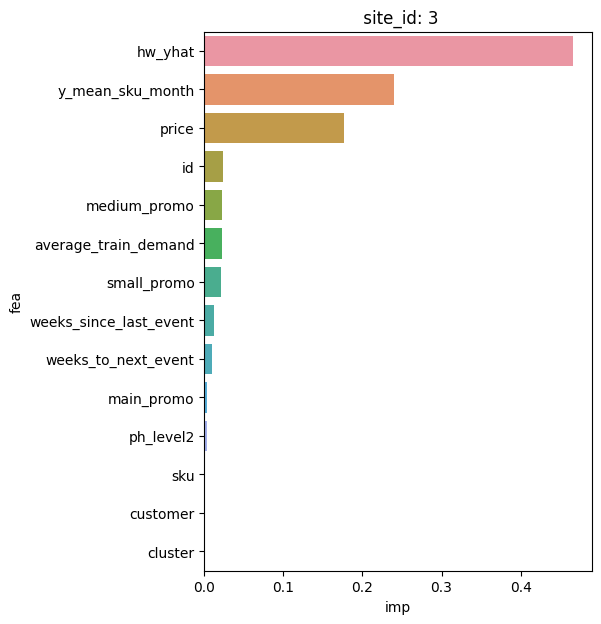

2022-06-01 0
2022-06-01 2
2022-06-01 1
2022-06-01 3


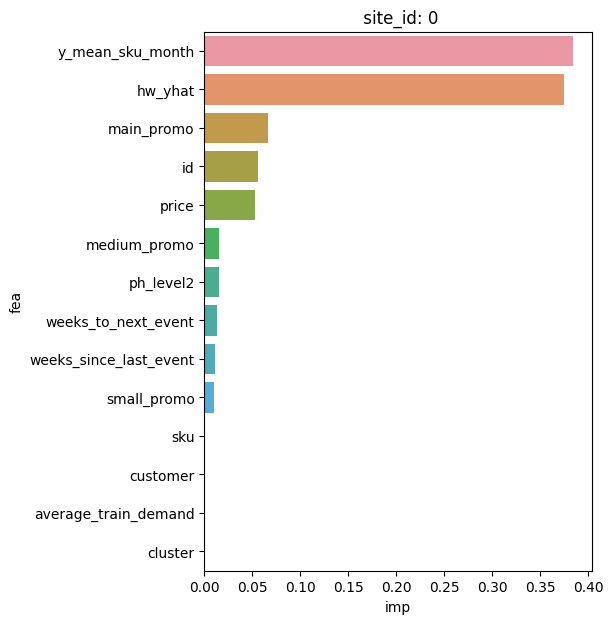

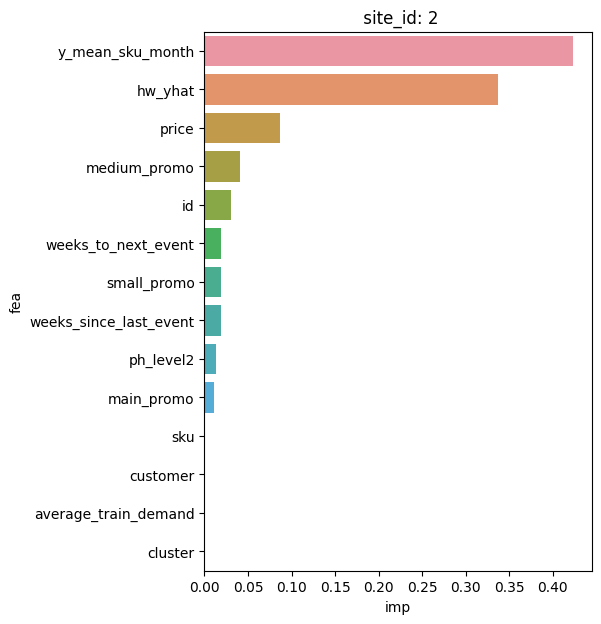

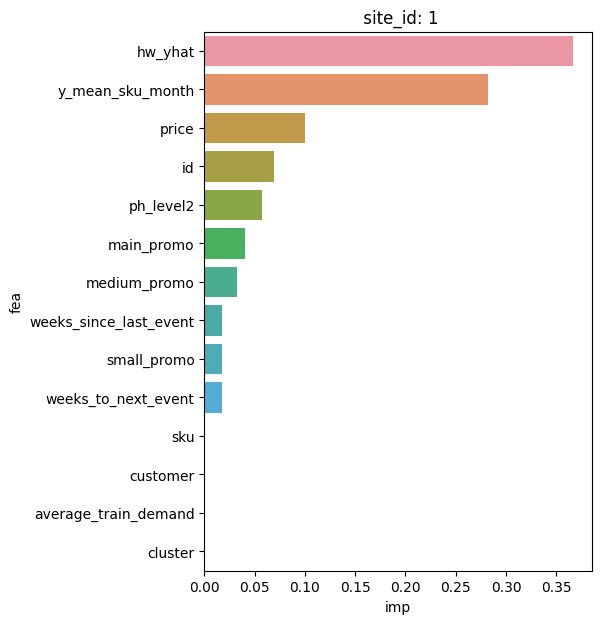

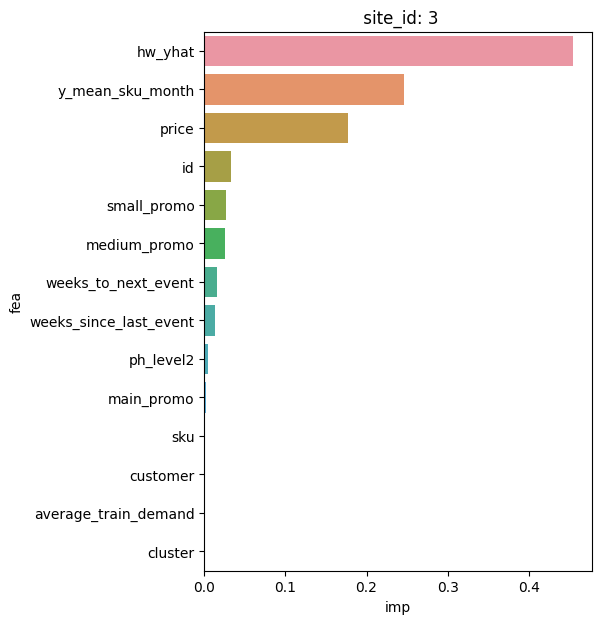

In [39]:
models = {}
clusters = {}
group_var = "cluster"
model_name = "Model per customer"
n_clusters = [1]
drop_cols = ["year", "basic_material", "material_description", "is_month_start", "is_month_end", "is_quarter_start", "is_quarter_end", "is_year_start", "is_year_end"]
# drop_cols = drop_cols + tsfresh_features

for i in range(len(versions)):
    _x_train = datas[versions[i]]["x_train"].copy()
    _y_train = datas[versions[i]]["y_train"].copy()
 
   
    if (group_var != "ALL"):
        groups = datas[versions[i]]["x_train"][group_var].unique()
    else:
        groups = ["ALL"]
        
    _model = {}
    if(groups[0] != "ALL"):
        for this_group in groups:
            print(versions[i], this_group)
            __x_train = _x_train.loc[_x_train[group_var] == this_group].reset_index(drop=True)
            __y_train = _y_train.loc[_x_train[group_var] == this_group].reset_index(drop=True)

            model = RandomForestRegressor(
                n_estimators=1000,
                criterion="mse",
                max_features="sqrt",
                random_state=0,
                max_samples=0.9,
                n_jobs=-1,  
                verbose=0,
            ) 
            __x_train.to_csv("op/fdsfsd.csv")
            if len(drop_cols) == 0:
                model.fit(__x_train, __y_train)
            else:
                model.fit(__x_train.drop(columns=drop_cols, errors="ignore"), __y_train)

            _model.update({this_group: model})
    else:
        _model = RandomForestRegressor(
            n_estimators=1000,
            criterion="mse",
            max_features="sqrt",
            random_state=0,
            max_samples=0.9,
            n_jobs=-1,  
            verbose=0,
        ) 
        if len(drop_cols) == 0:
            _model.fit(_x_train, _y_train)
        else:
            _model.fit(_x_train.drop(columns=drop_cols, errors="ignore"), _y_train)

        clust_model = None
        labels = None
        _model.update({"ALL": model})
    
    x_train = _x_train.drop(columns=drop_cols, errors="ignore") 
    for sn in _model.keys():
        fea_imp = pd.DataFrame({"fea": x_train.columns.to_list(), "imp": _model[sn].feature_importances_})
        fea_imp.sort_values(by="imp", inplace=True, ascending=False)
        fea_imp = fea_imp.head(20)
        plt.figure(figsize=(5, 7))
        sns.barplot(data=fea_imp, x="imp", y="fea")
        plt.title(" site_id: {}".format( sn))
        plt.show()
    models.update({versions[i]: _model})
    
    


In [40]:


predict_df = []
for i in range(len(versions)):
    
    x_train = datas[versions[i]]["x_train"]
    x_test = datas[versions[i]]["x_test"]
    x_predict = datas[versions[i]]["x_predict"]
    yhat_train = np.zeros(x_train.shape[0])
    yhat_test = np.zeros(x_test.shape[0])
    yhat_predict = np.zeros(x_predict.shape[0])
    
    _model = models[versions[i]]
    if (group_var != "ALL"):      
        for sn in _model.keys():
            model = _model[sn]
            yhat_train = model.predict(x_train.loc[x_train[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            yhat_test = model.predict(x_test.loc[x_test[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            yhat_predict = model.predict(x_predict.loc[x_predict[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            if (group_var in ["sku", "cluster"]) :  
                sn2 = sn
            else:
                sn2 = encoders[versions[i],group_var].inverse_transform([sn])[0]
            a = pd.concat([
                datas[versions[i]]["train"].loc[datas[versions[i]]["train"][group_var]==sn2], 
                datas[versions[i]]["test"].loc[datas[versions[i]]["test"][group_var]==sn2],
                datas[versions[i]]["predict"].loc[datas[versions[i]]["predict"][group_var]==sn2]
            ]).reset_index(drop=True)
            a["yhat"] = np.concatenate((yhat_train,yhat_test, yhat_predict))
            a["yhat"] = np.clip(np.round(a["yhat"]), 0, None)
            a["model"] = model_name
            a["version"] = versions[i]
            predict_df.append(a)
    else:
        model = _model['ALL']
        yhat_train = model.predict(x_train.drop(columns=drop_cols,errors= 'ignore'))
        yhat_test = model.predict(x_test.drop(columns=drop_cols,errors= 'ignore'))
        yhat_predict = model.predict(x_predict.drop(columns=drop_cols,errors= 'ignore'))

        sn2 = encoders[group_var].inverse_transform([sn])[0]
        a = pd.concat([
            datas[versions[i]]["train"], 
            datas[versions[i]]["test"],
            datas[versions[i]]["predict"]
        ]).reset_index(drop=True)
        a["yhat"] = np.concatenate((yhat_train,yhat_test, yhat_predict))
        a["yhat"] = np.clip(np.round(a["yhat"]), 0, None)
        a["model"] = model_name
        a["version"] = versions[i]
        predict_df.append(a)
predict_df = pd.concat(predict_df).reset_index(drop=True) 
predict_df = pd.merge(predict_df, att_main, on = 'sku', how = 'left')

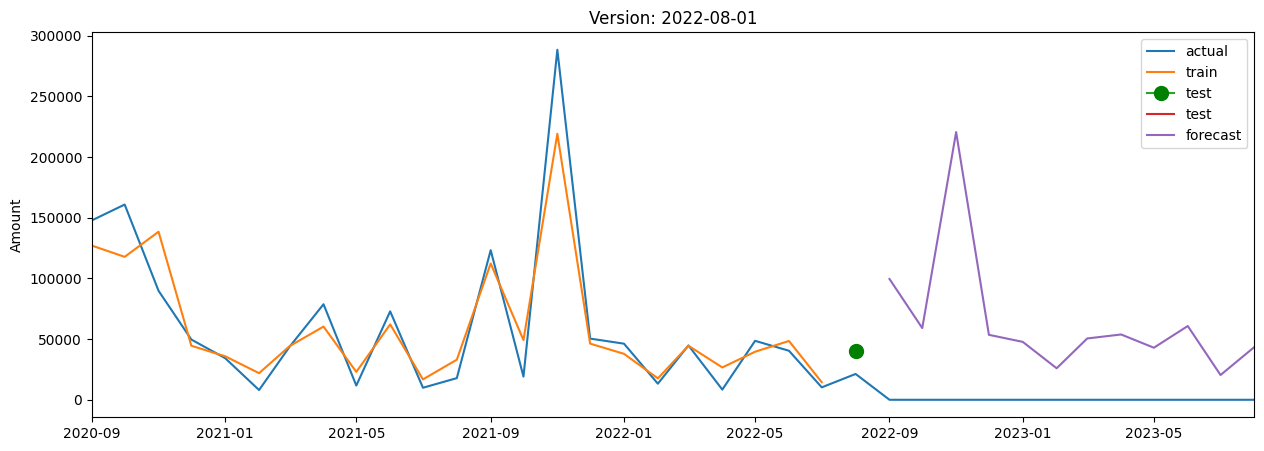

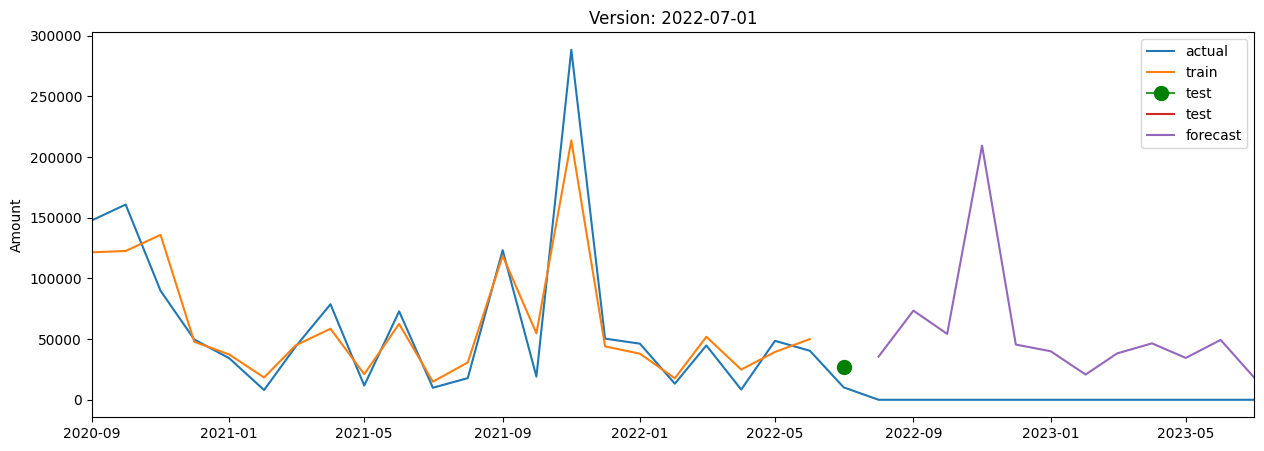

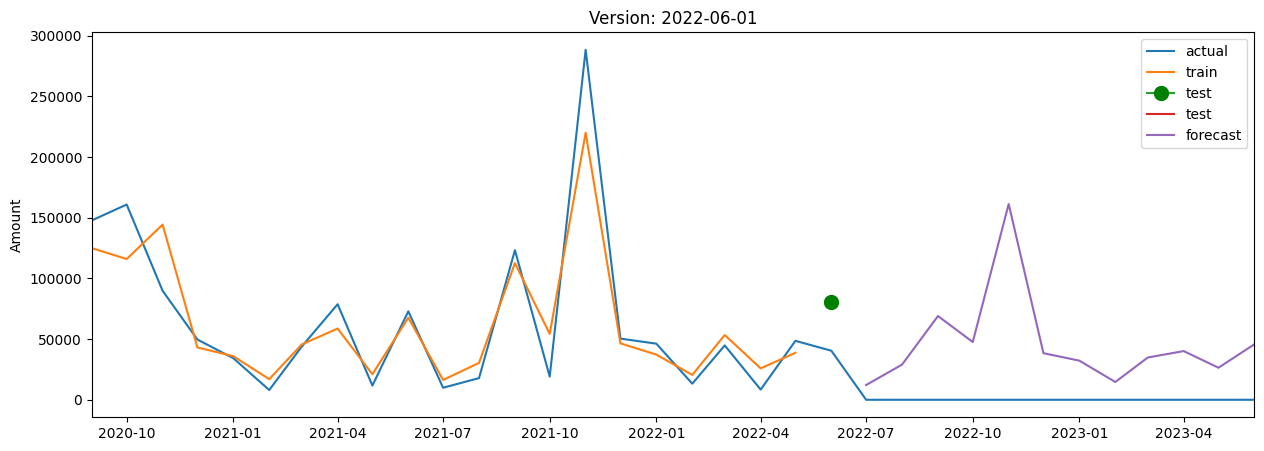

In [41]:
for i in range(len(versions)):
    a = predict_df.loc[predict_df.version == versions[i]]
    dates = all_dates[versions[i]]

    # monthly
    ts = a.set_index("ts").resample("MS").sum().reset_index()
    train = ts.loc[ts.ts < dates["test"][0]]
    test = ts.loc[(ts.ts < dates["forecast"][0]) & (ts.ts >= dates["test"][0])]
    predict = ts.loc[ts.ts >= dates["forecast"][0]]
 
    
    _max = ts[["y", "yhat"]].max().max()

    plt.figure(figsize=(15,5))
    plt.plot(ts.ts, ts.y, label="actual")
    plt.plot(train.ts, train.yhat, label="train")

    if(test.shape[0] ==1):
        plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
    else:
        plt.plot(test.ts, test.yhat, label="test")
    
    plt.plot(test.ts, test.yhat, label="test")
    plt.plot(predict.ts, predict.yhat, label="forecast")
    plt.xlim([ts.ts.min(), ts.ts.max()])
    plt.ylabel("Amount")
    plt.title("Version: {}".format(versions[i]))
    plt.legend()
    plt.show()

In [42]:
m

'2022-08-01'

In [43]:
predict_df_op = []
predict_df_monthly_op = []
for i in range(len(versions)):
    a = predict_df.loc[predict_df.version == versions[i]]
    dates = all_dates[versions[i]]

    # monthly
 
    ts = predict_df.loc[ (predict_df["version"] == versions[i])  ].reset_index(drop=True)
    
    ts.drop(columns={'y'}, inplace = True)
    ts = pd.merge(ts, df[['ts', 'id', 'y']], on = ['ts', 'id'], how = 'left')
    ts.loc[ts.ts < dates["test"][0], 'yhat'] = 0
    ts['y'] = ts['y'].fillna(0)
    
    predict_df_op.append(ts)

    
predict_df_op = pd.concat(predict_df_op).reset_index(drop=True)
predict_df_op.rename(columns={'yhat':'forecast','y':'actuals'},inplace = True)
predict_df_op = predict_df_op[['version',  'ts', 'id', 'sku', 'customer', 'actuals', 'forecast']]
predict_df_op_long = predict_df_op.melt(id_vars=[ 'version',  'ts', 'id', 'sku', 'customer'],var_name="type",value_name="value")
predict_df_op_long['value_category'] = predict_df_op_long['type'] + '_version_' + predict_df_op_long['version'].astype(str)
predict_df_op_long.loc[predict_df_op_long['type'] == 'actuals', 'value_category']  = 'Actuals'
predict_df_op_long.loc[predict_df_op_long['type'] == 'actuals', 'value_category']  = 'Actuals'
predict_df_op_long['keep_records'] = True
predict_df_op_long.loc[ (predict_df_op_long['value_category'] == 'Actuals') & (predict_df_op_long['version'] != m), 'keep_records'] = False
predict_df_op_long = predict_df_op_long[predict_df_op_long['keep_records'] == True]
predict_df_op_long.drop(columns = {'keep_records'}, inplace = True)
att_df1 = att_df[['cases', 'customer', 'item_type', 'material', 'ph_level2', 'ph_level3',
       'sku', 'sku_description', 'uom']].drop_duplicates()
print(predict_df_op.shape)
predict_df_op = pd.merge(predict_df_op,att_df1,on=['sku','customer'])
print(predict_df_op.shape)
predict_df_op = pd.merge(predict_df_op,att_main,on='sku')
predict_df_op['date_num'] = pd.to_numeric(predict_df_op['ts'])
predict_df_op_long = pd.merge(predict_df_op_long,att_df1,on=['sku','customer'])
print(predict_df_op_long.shape)
predict_df_op_long = pd.merge(predict_df_op_long,att_main,on='sku')
predict_df_op_long['date_num'] = pd.to_numeric(predict_df_op_long['ts'])
predict_df_op_long.head()

(1614, 7)
(1614, 14)
(2173, 15)


version         ts id           sku customer     type   value value_category  cases item_type  material     ph_level2 ph_level3                           sku_description uom    shortname             date_num
0  2022-08-01 2020-09-01  0  815517026005    TMALL  actuals   103.0        Actuals     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1598918400000000000
1  2022-08-01 2020-10-01  0  815517026005    TMALL  actuals  6780.0        Actuals     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1601510400000000000
2  2022-08-01 2020-11-01  0  815517026005    TMALL  actuals  3996.0        Actuals     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1604188800000000000
3  2022-08-01 2020-12-01  0  815517026005    TMALL  actuals  1065.0        Actuals     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1606780800000000000
4  2022-08-01 2021-01-01  0  815517026005    TMALL  actuals   785.0        Actuals     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1609459200000000000

In [44]:
events = get_events()
events['festival'] = events['festival'].astype('int64')
events['promotion_specific_date'] = events['promotion_specific_date'].astype('int64')

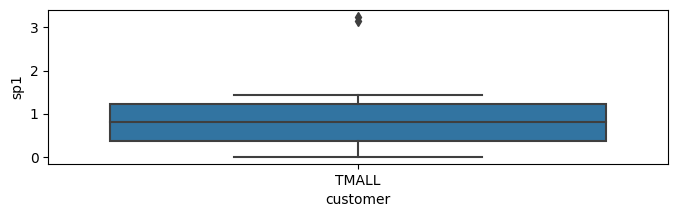

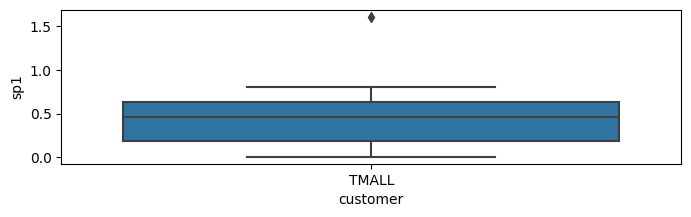

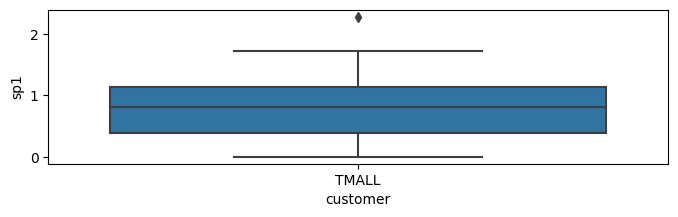

In [45]:
results = pd.DataFrame()
for i in range(len(versions)):
    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id) & (predict_df["version"] == versions[i])  ].reset_index(drop=True)
        test = ts.loc[ ts.ts.isin( all_dates[versions[i]]["test"]) ].copy()
        
        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "id": _id,
            "version" : versions[i],
            "sku": ts["sku"][0],
            "customer": ts["customer"][0],
            "test_start": all_dates[versions[i]]["test"][0],
            "test_end": all_dates[versions[i]]["test"][-1],
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results = results.append(metrics, ignore_index=True, sort=False)

main_cols = ["id", "sku", "customer", "version", "test_start", "test_end", "total_actual", "total_forecast"]
results = results[main_cols + list(results.drop(columns=main_cols).columns)].copy()
results["sp1"] = results["total_actual"] / results["total_forecast"]
results["sp1"] = np.nan_to_num(results["sp1"], nan=1, posinf=0, neginf=0)
results["model"] = predict_df.model[0]

results.sort_values(by="id").reset_index(drop=True).set_index(["model", "id"])
results.groupby("customer").mean()
results.groupby("customer").median()

for i in range(len(versions)): 
    this_results = results[results['version'] == versions[i]]
    plt.figure(figsize=(8,2))
    #plt.ylim(0,15)
    sns.boxplot(data=this_results, y="sp1", x="customer")
    plt.show()

    

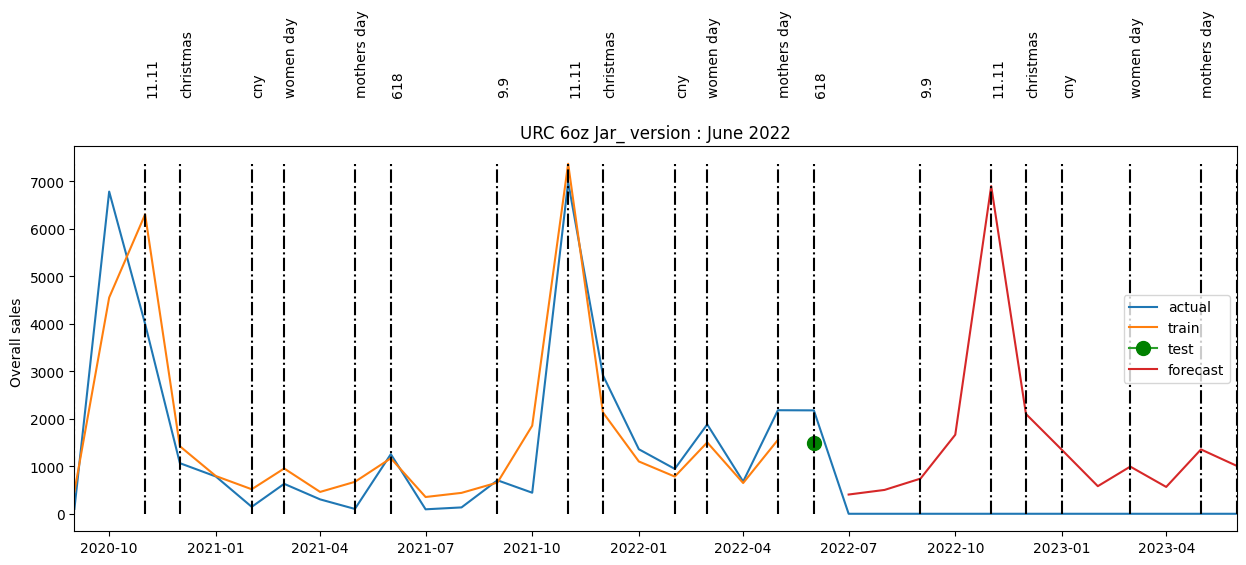

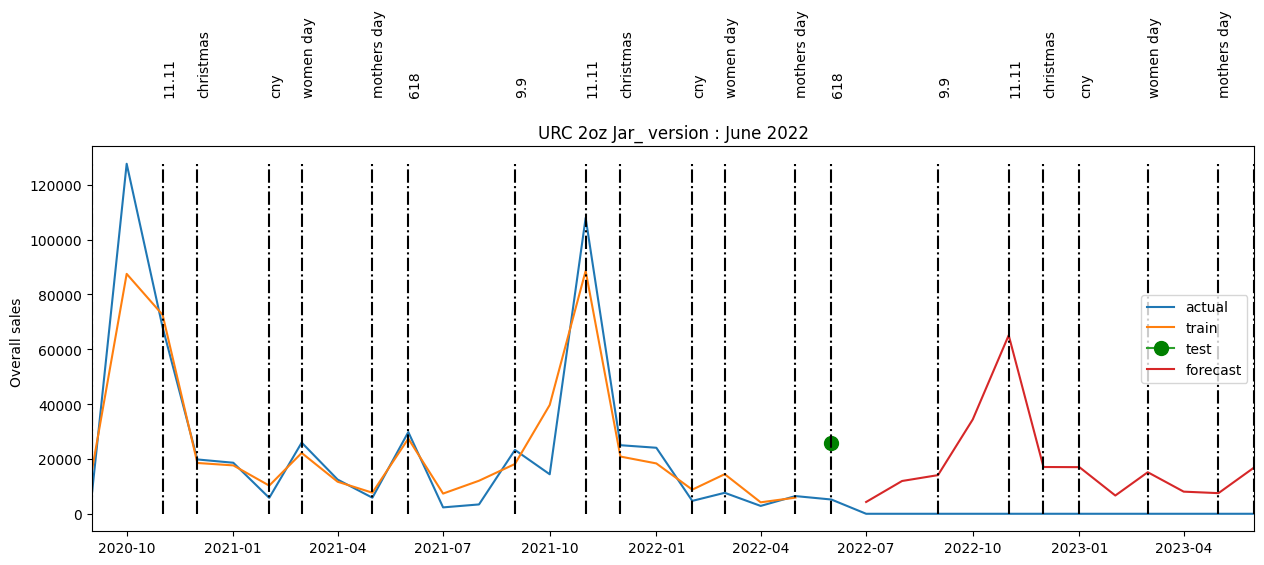

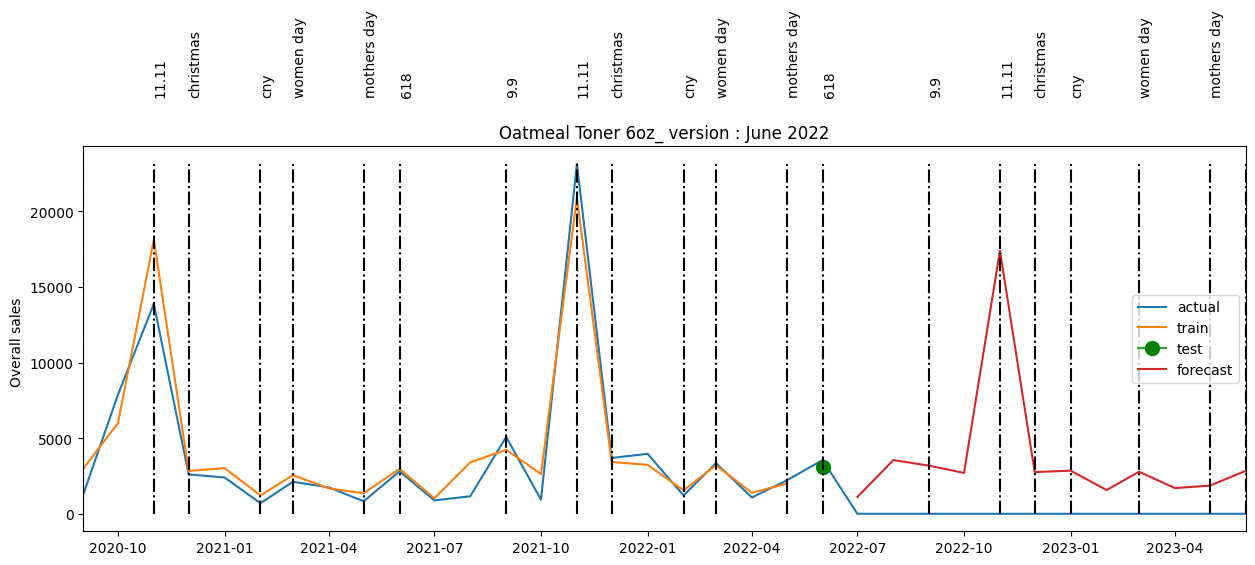

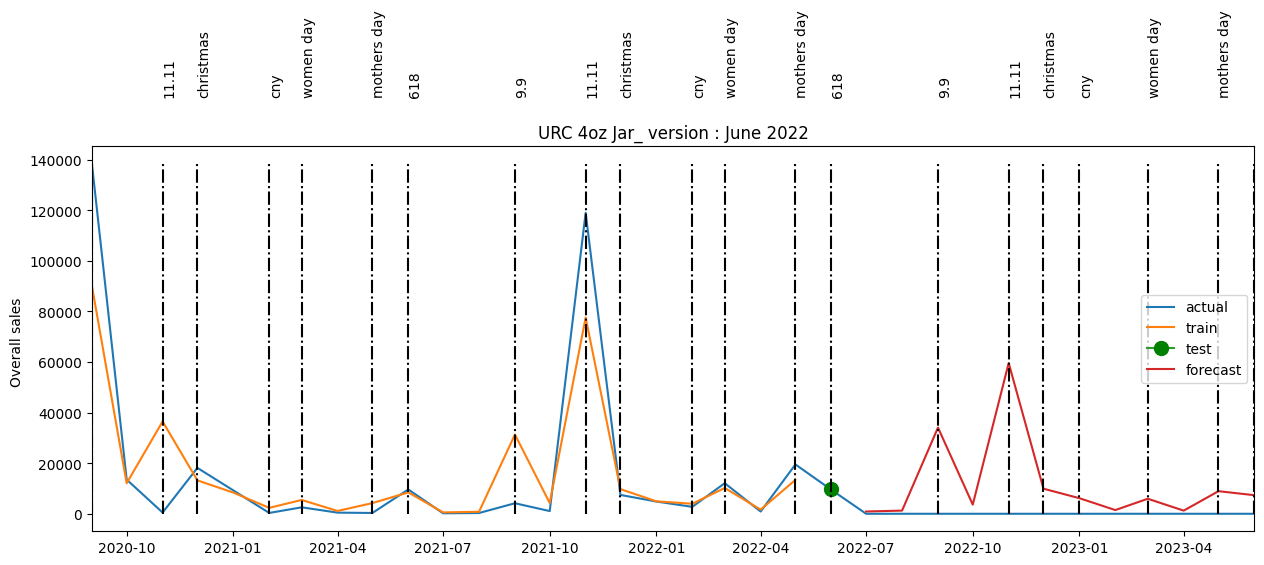

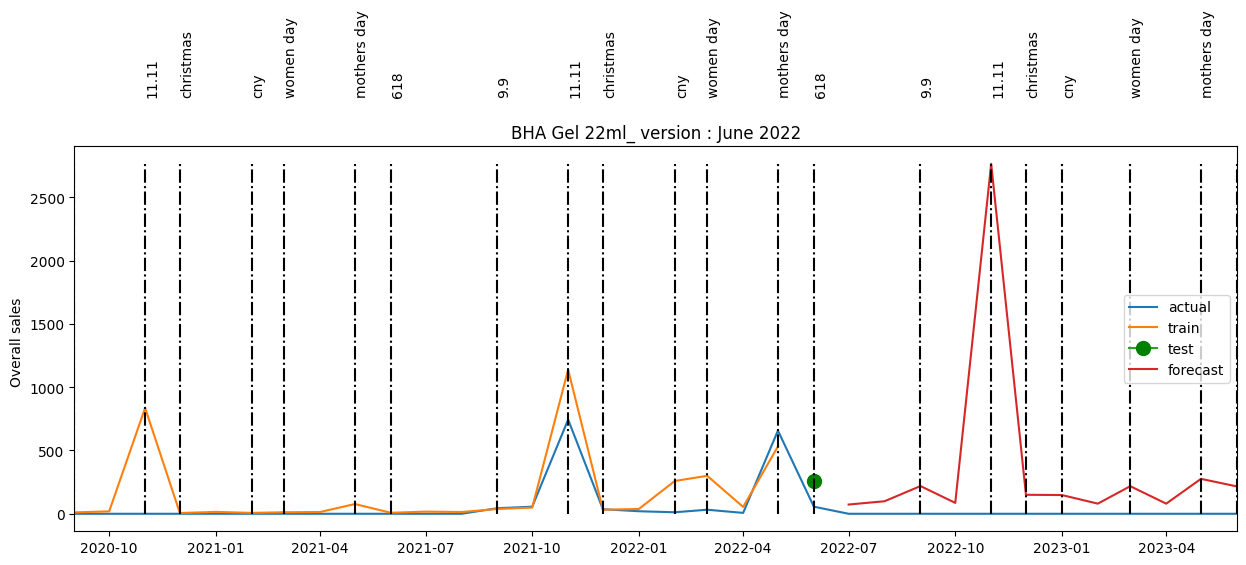

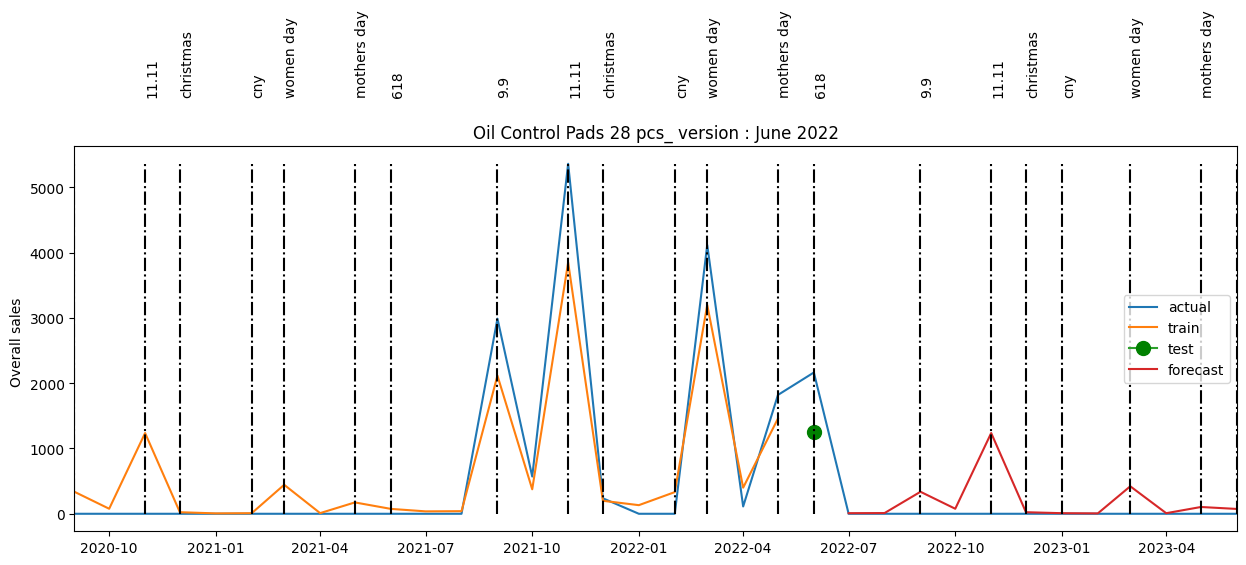

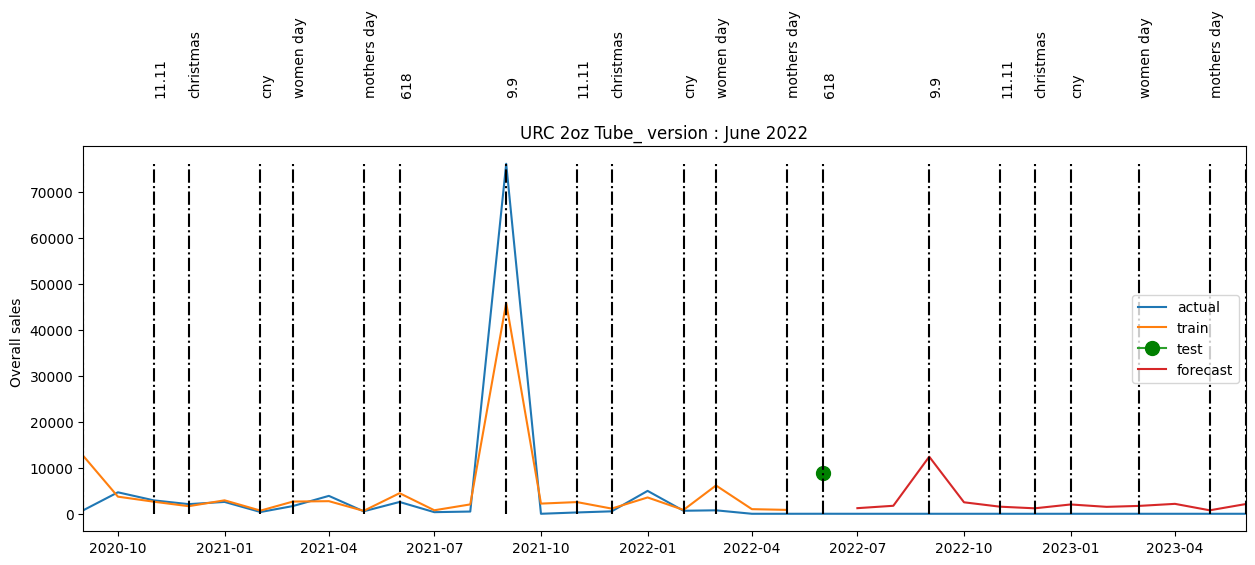

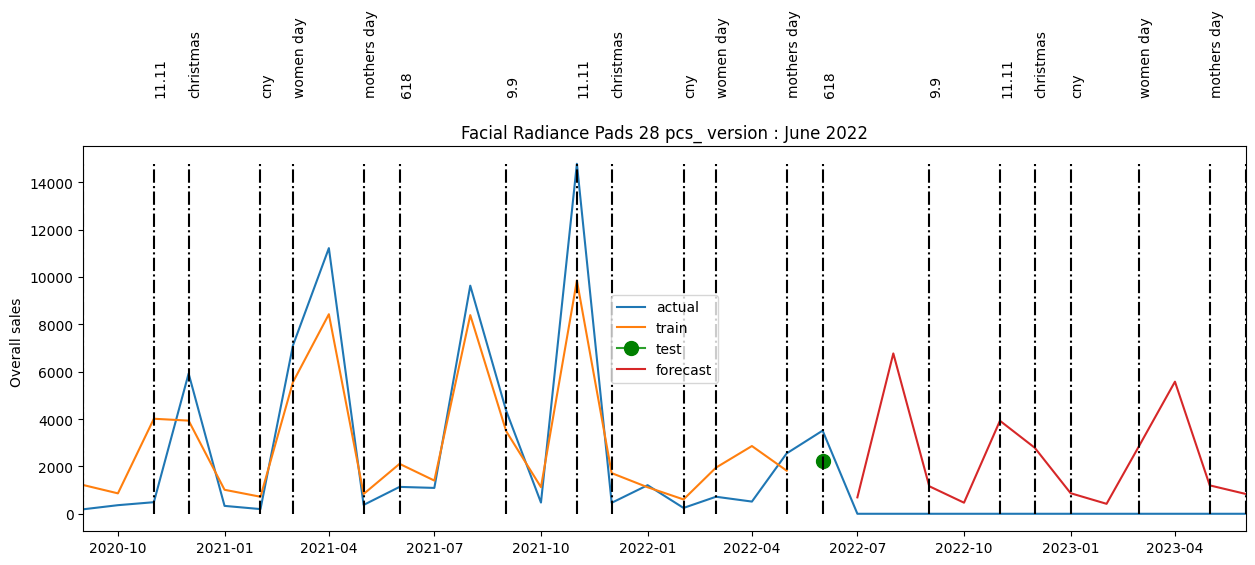

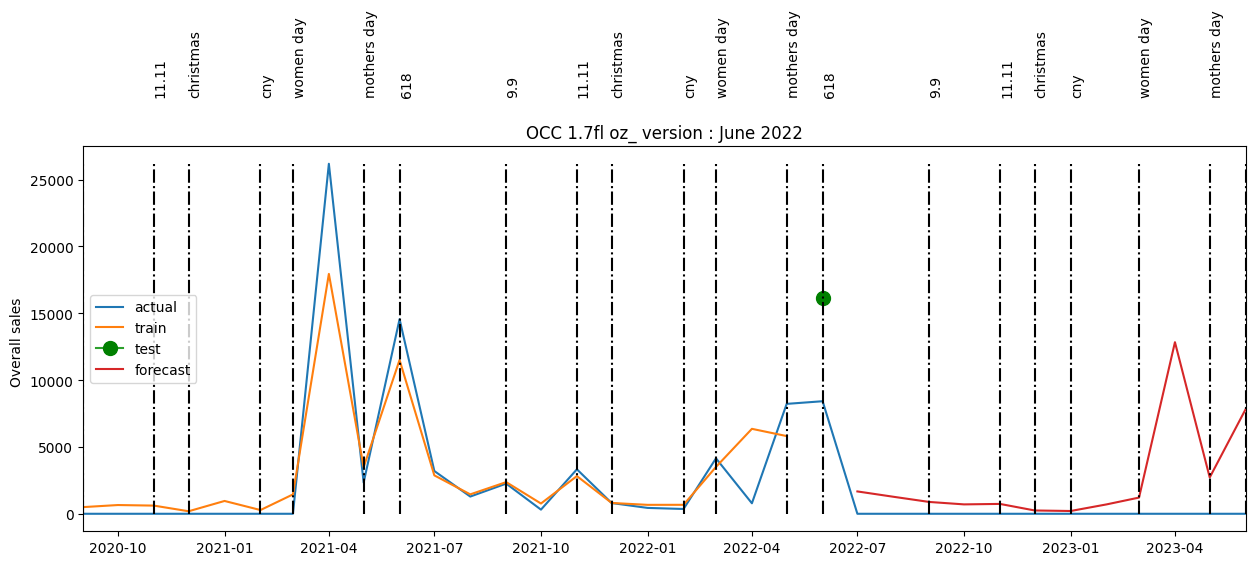

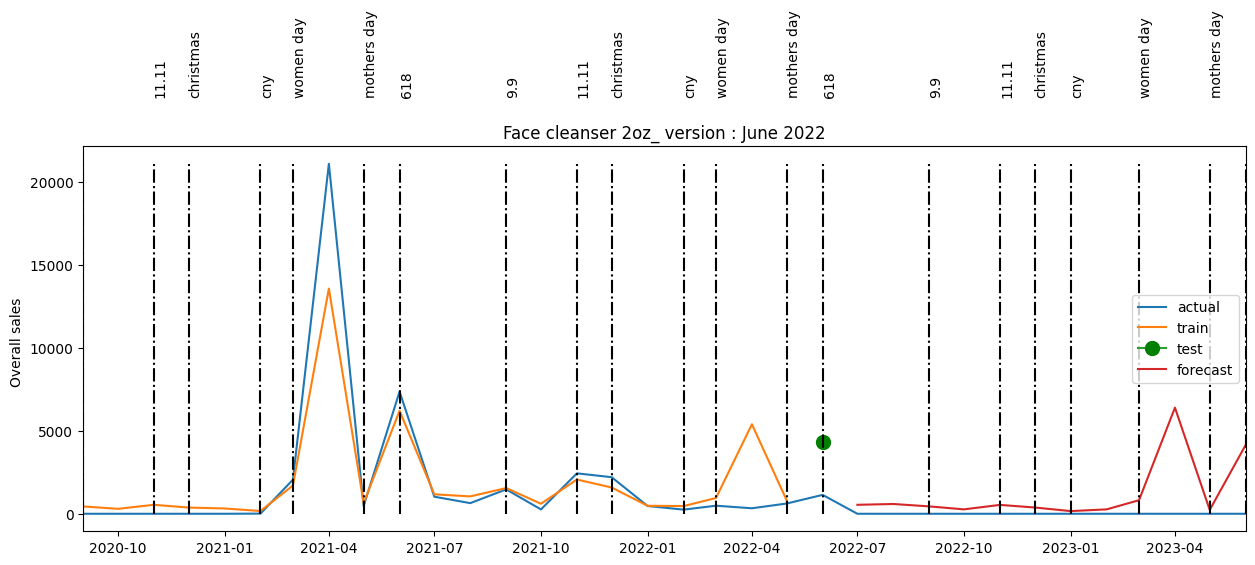

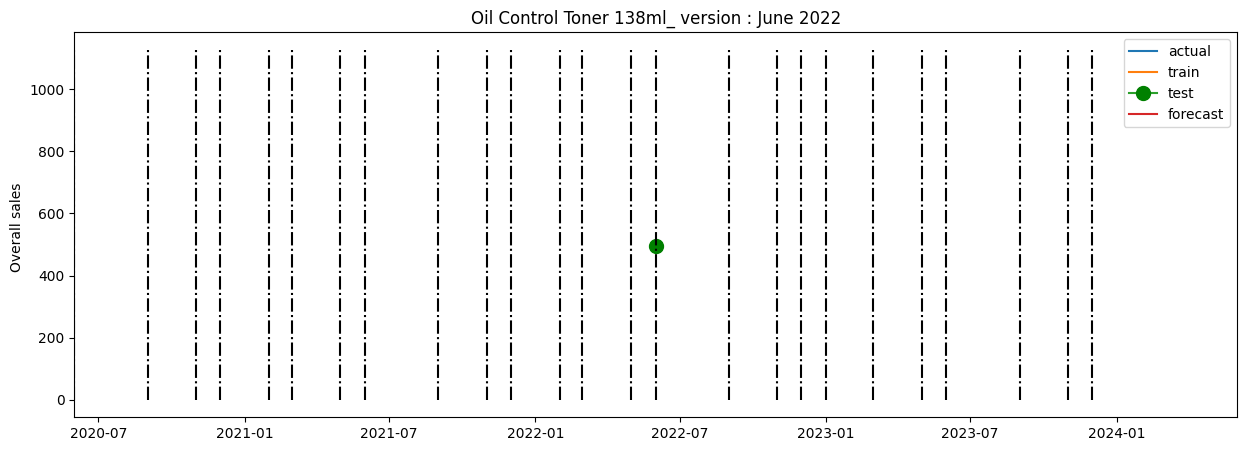

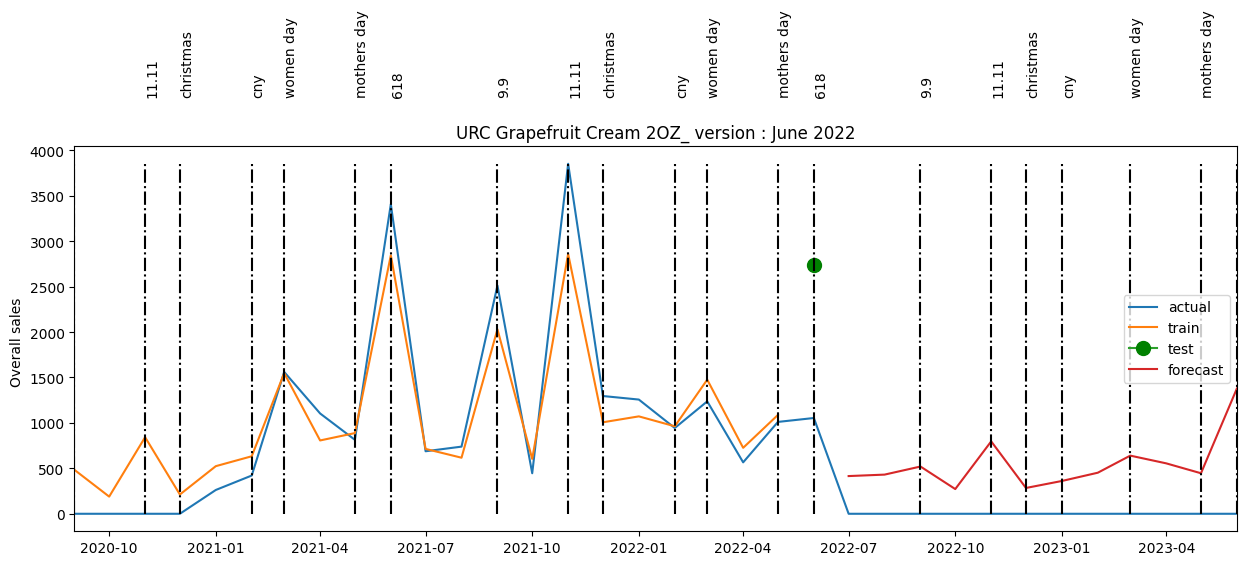

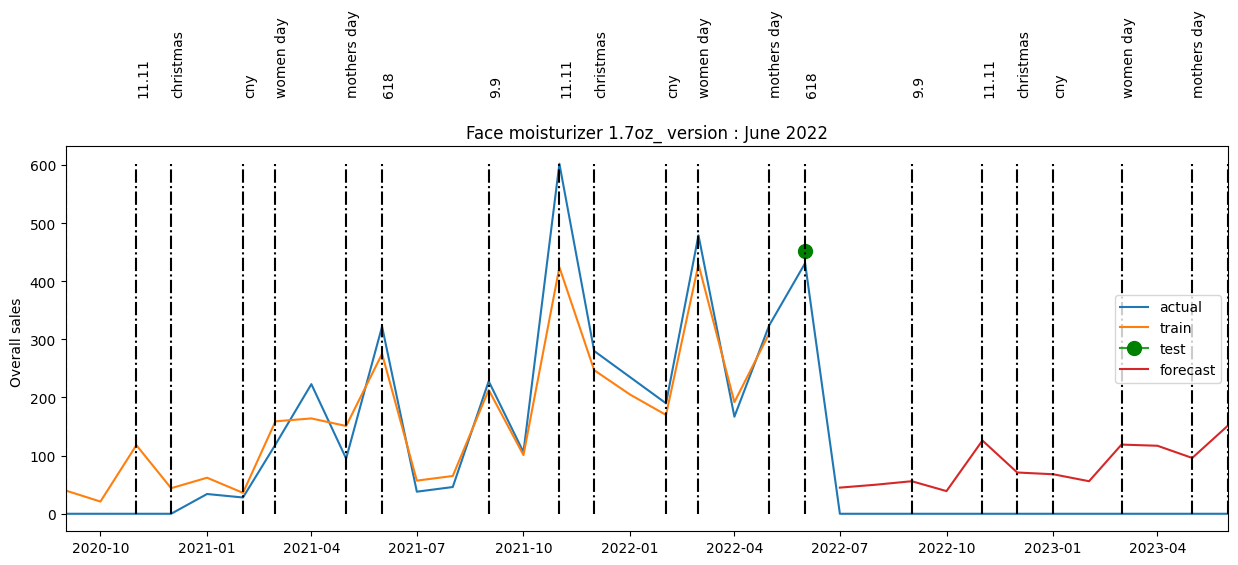

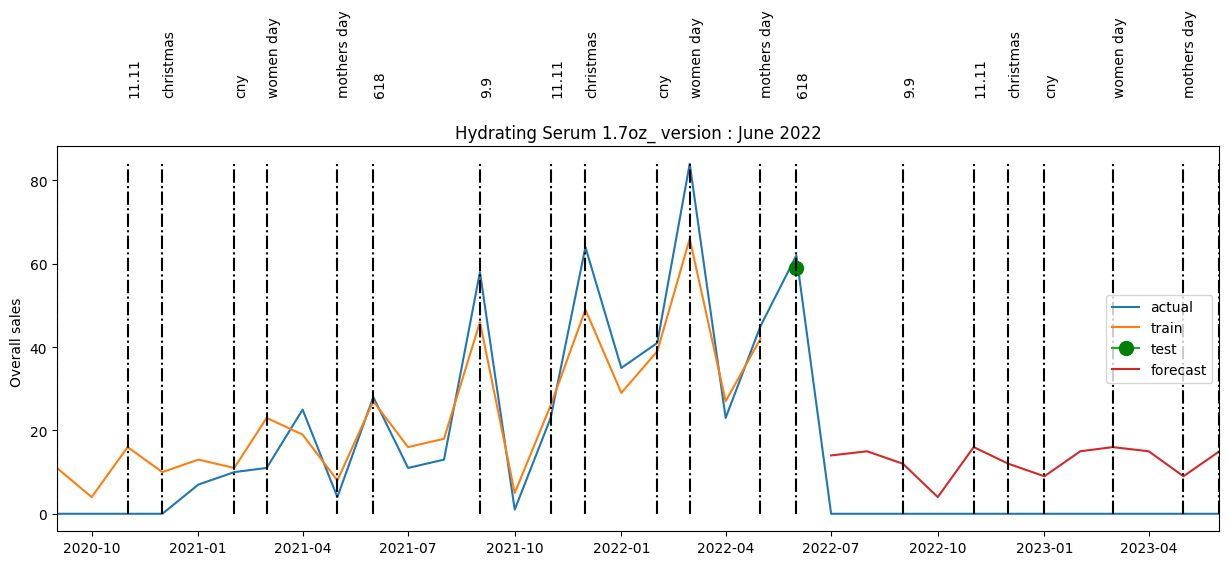

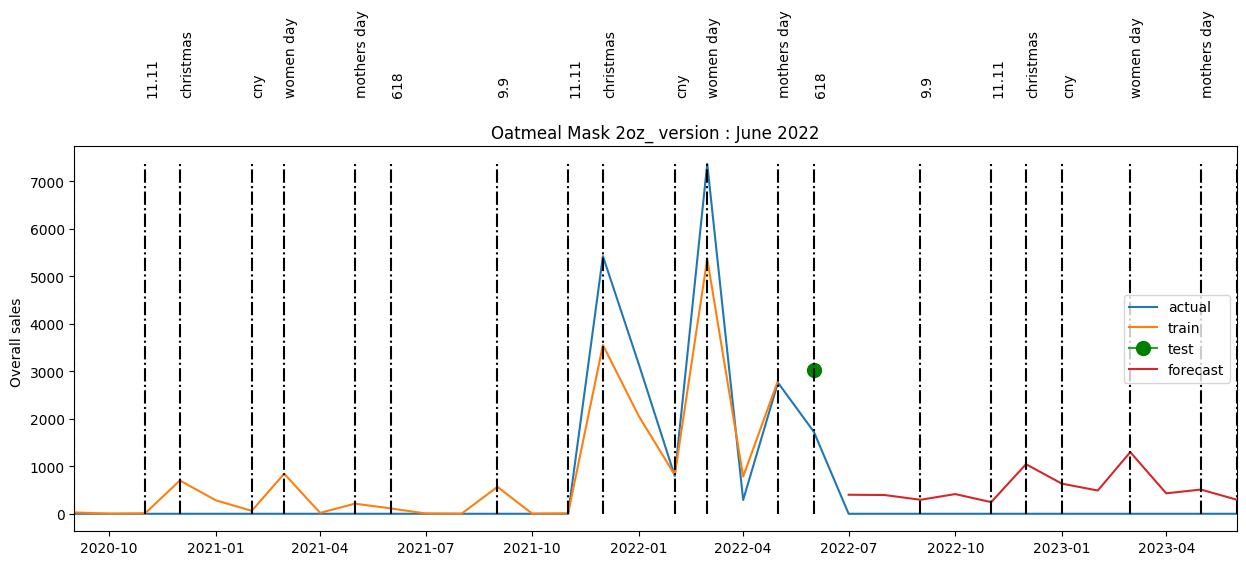

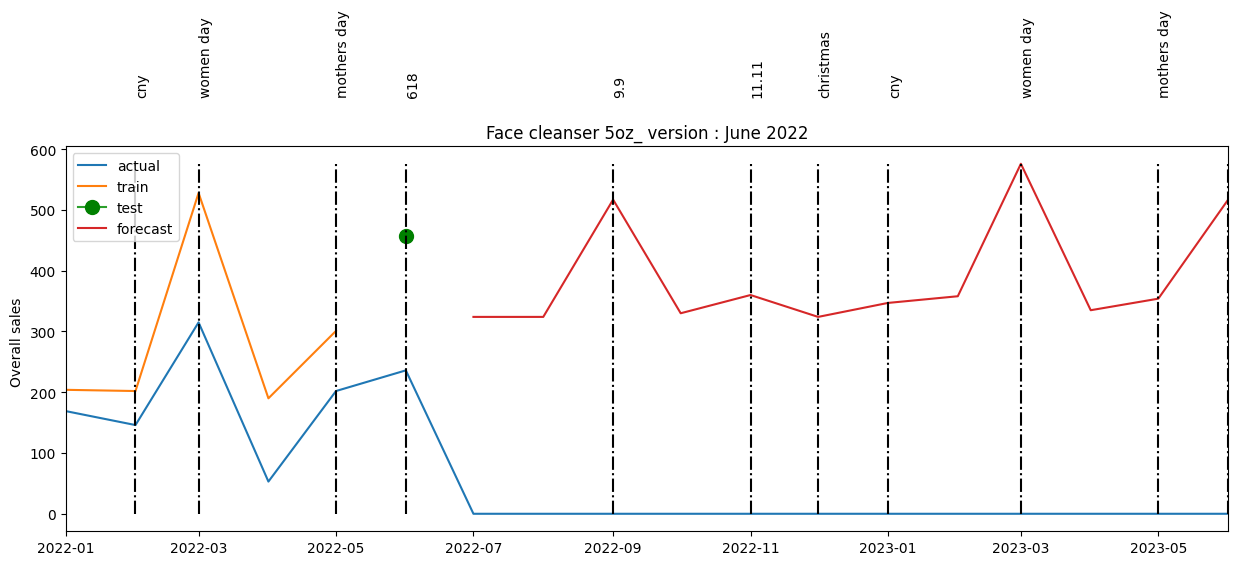

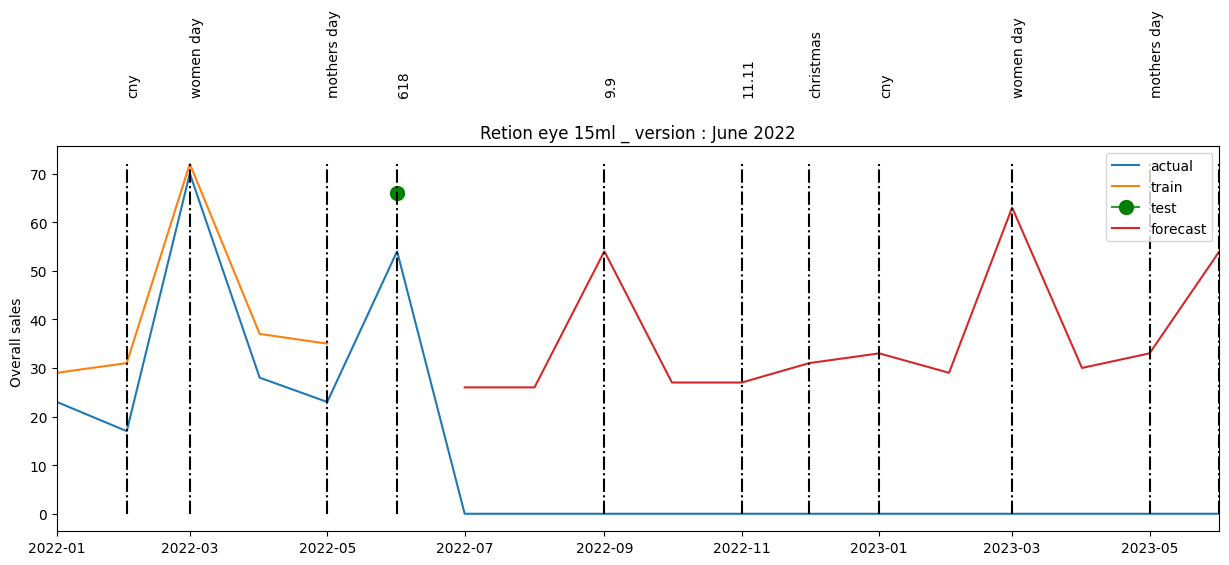

In [46]:
i = 2
this_predict = predict_df.loc[predict_df.version == versions[i]]
this_predict['sku_cust'] = this_predict['shortname'].astype(str) 
sku_custs =  this_predict.sku_cust.unique()
for this_sku_cust in sku_custs :
    this_ts = this_predict[this_predict['sku_cust'] == this_sku_cust]
    sku_desc = this_ts.sku_cust.unique()[0]
    ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
    train = ts.loc[ts.ts < all_dates[versions[i]]["test"][0]]
    test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
    forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

    _max = ts[["y", "yhat"]].max().max()

    plt.figure(figsize=(15,5))
    plt.plot(ts.ts, ts.y, label="actual")

    plt.plot(train.ts, train.yhat, label="train")

    if(test.shape[0] ==1):
        plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
    else:
        plt.plot(test.ts, test.yhat, label="test")


    plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
    for j in range(len(events)):
        plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
        if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
            plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
    plt.xlim([ts.ts.min(), ts.ts.max()])
   # plt.ylim([0, predict_df.yhat.max()])
    plt.ylabel("Overall sales ")
    plt.title( this_sku_cust + "_ version : " + str(pd.to_datetime(versions[i]).strftime("%B")) + " 2022")
    plt.legend()
    plt.show()

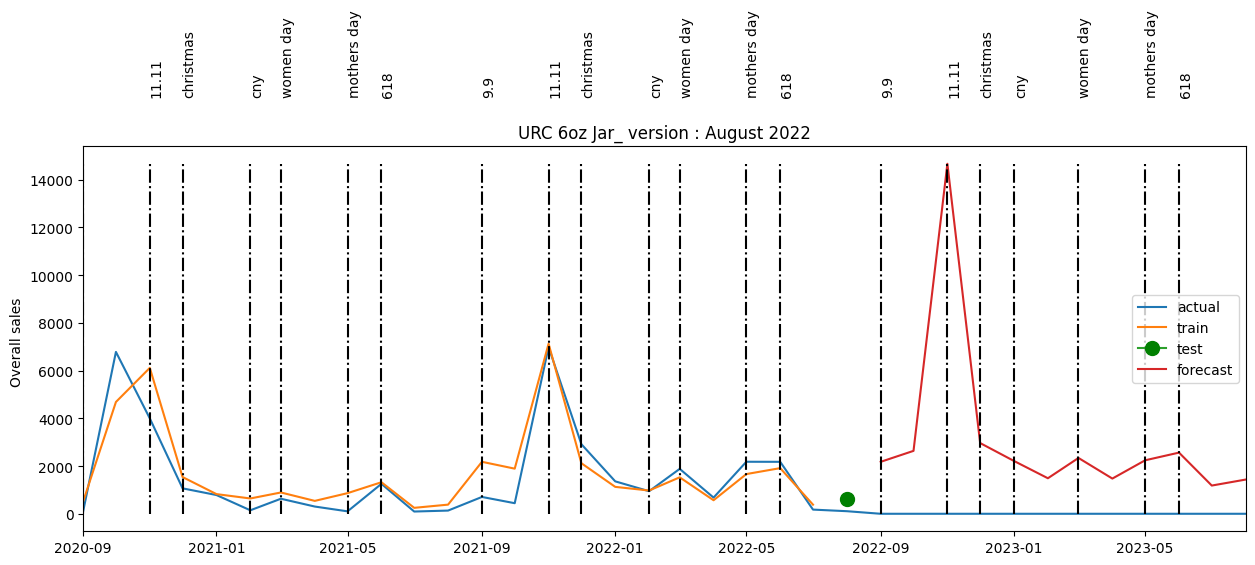

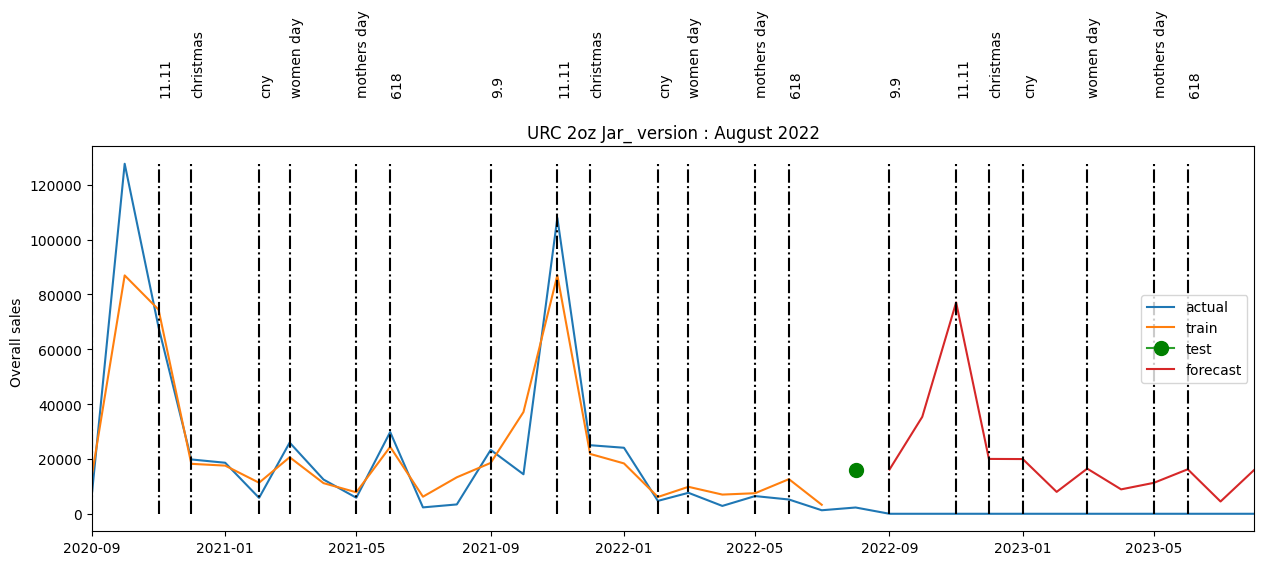

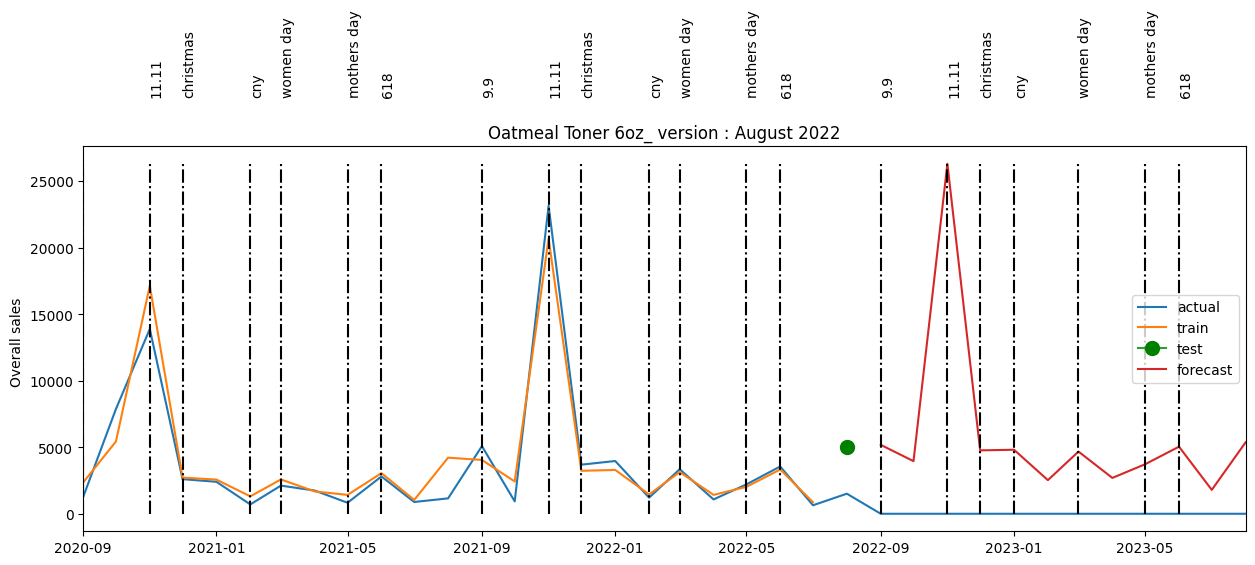

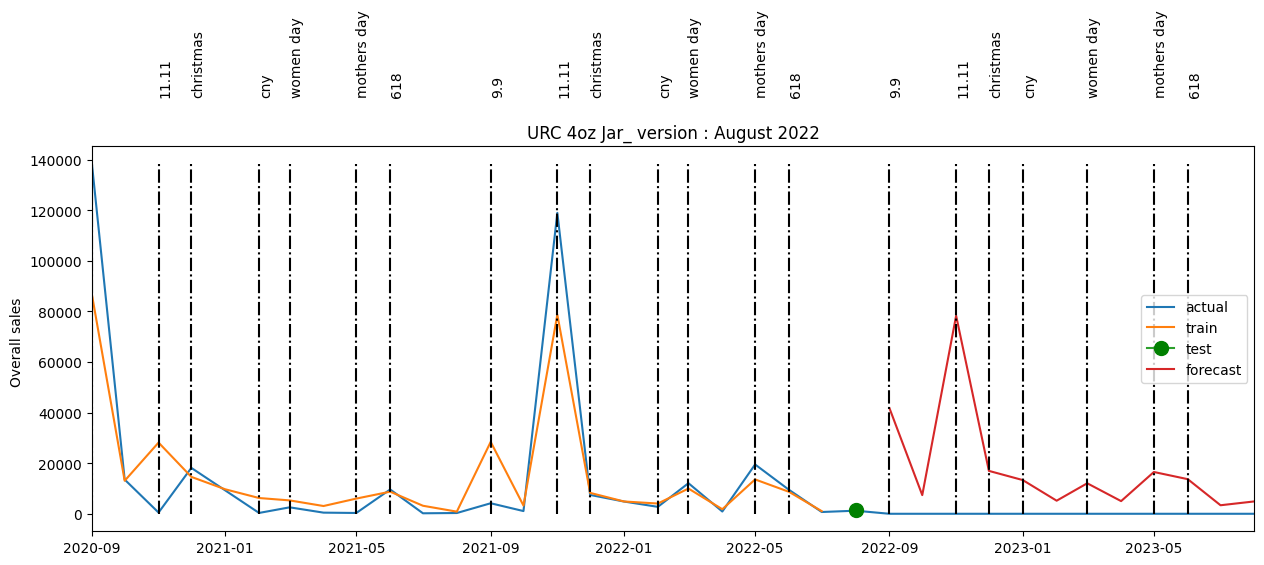

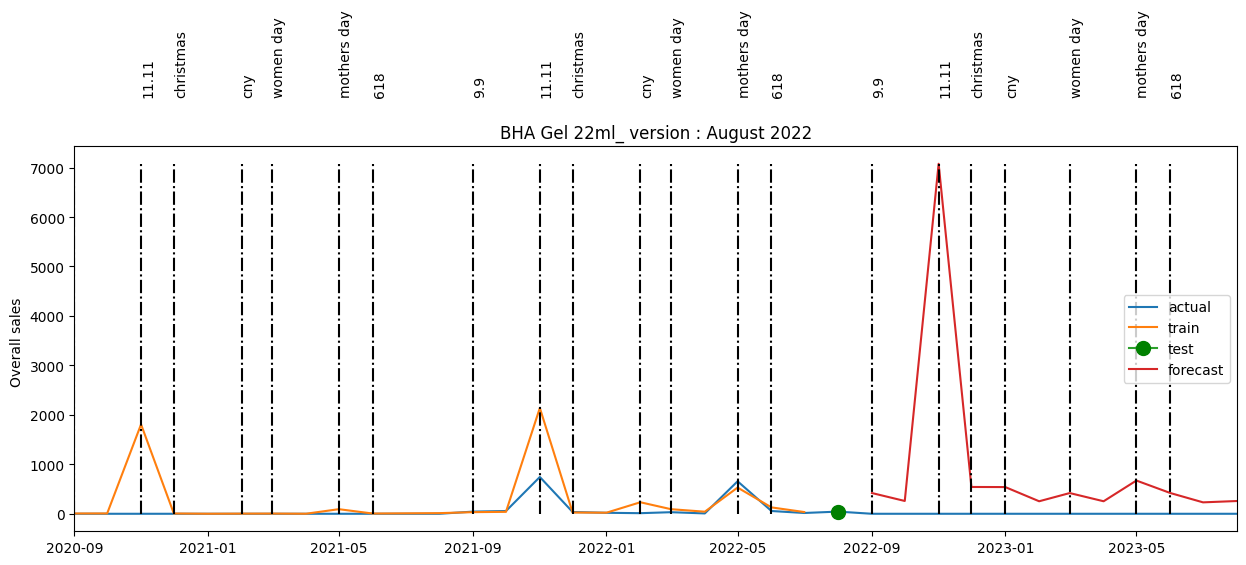

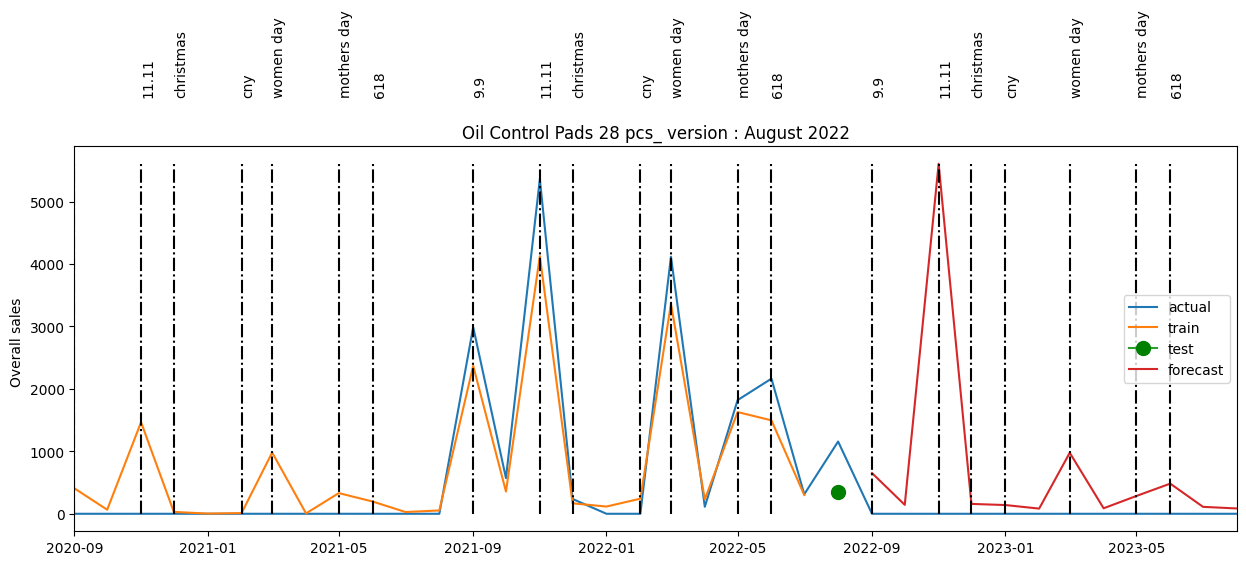

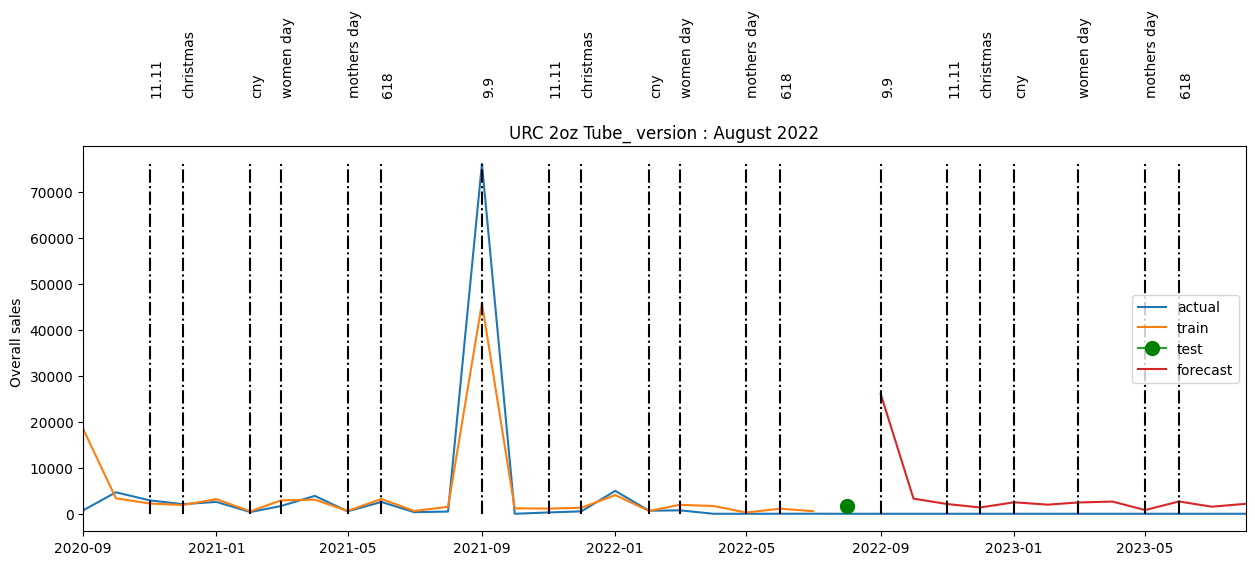

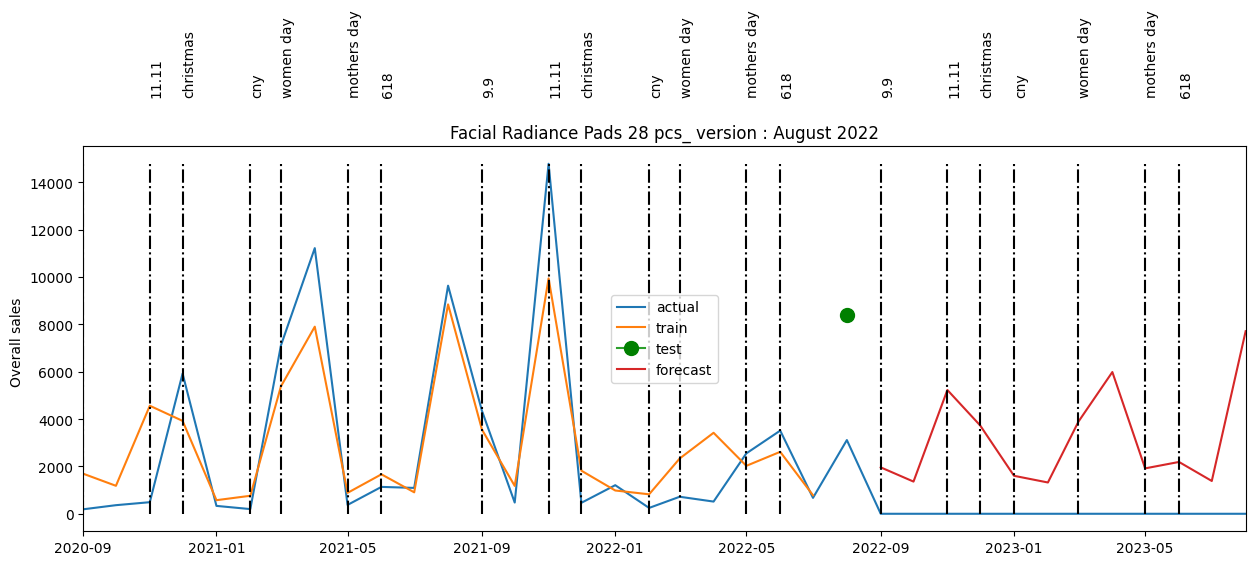

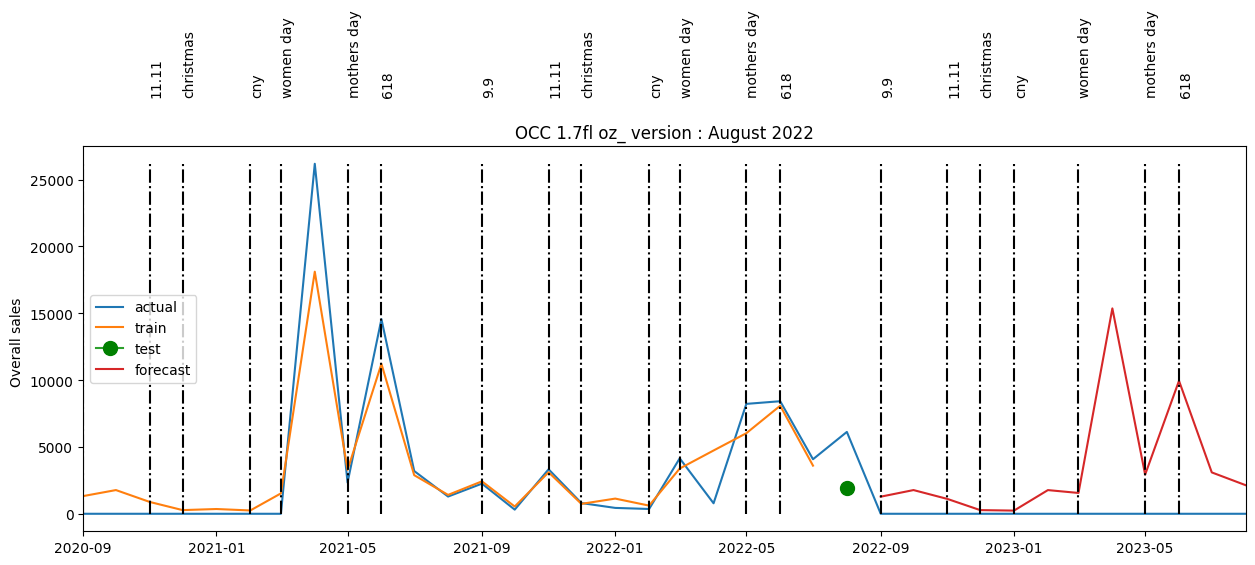

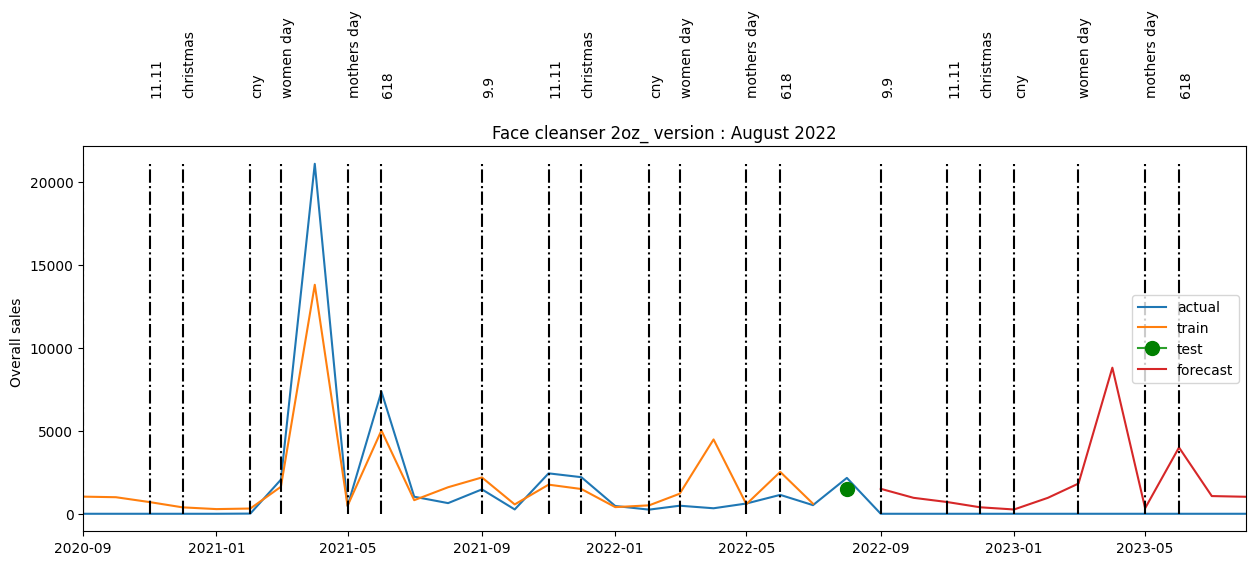

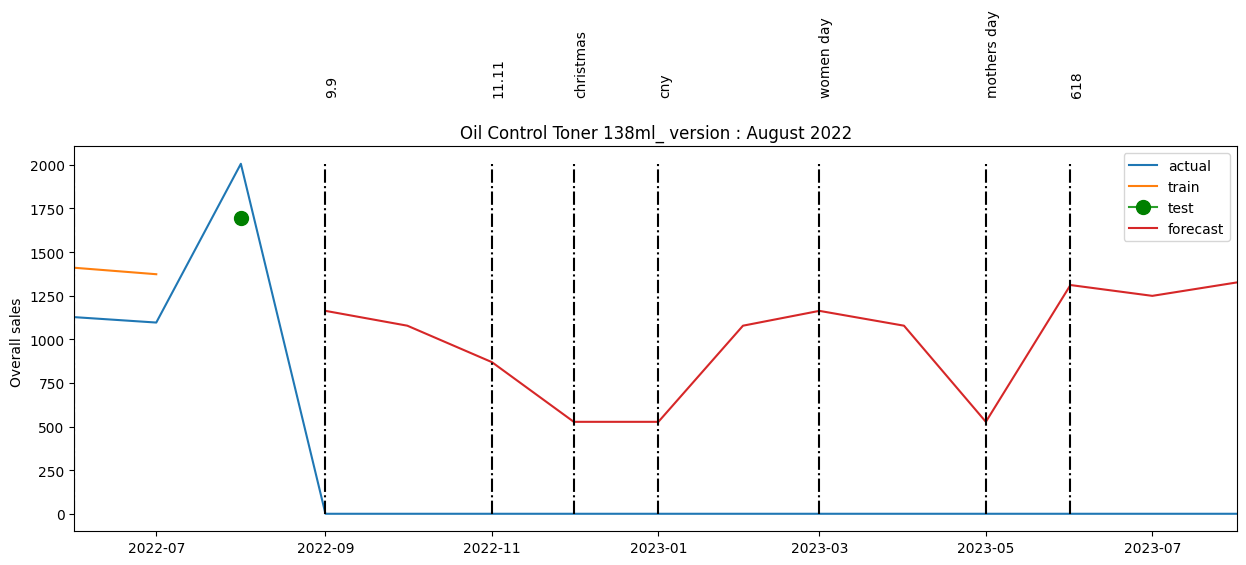

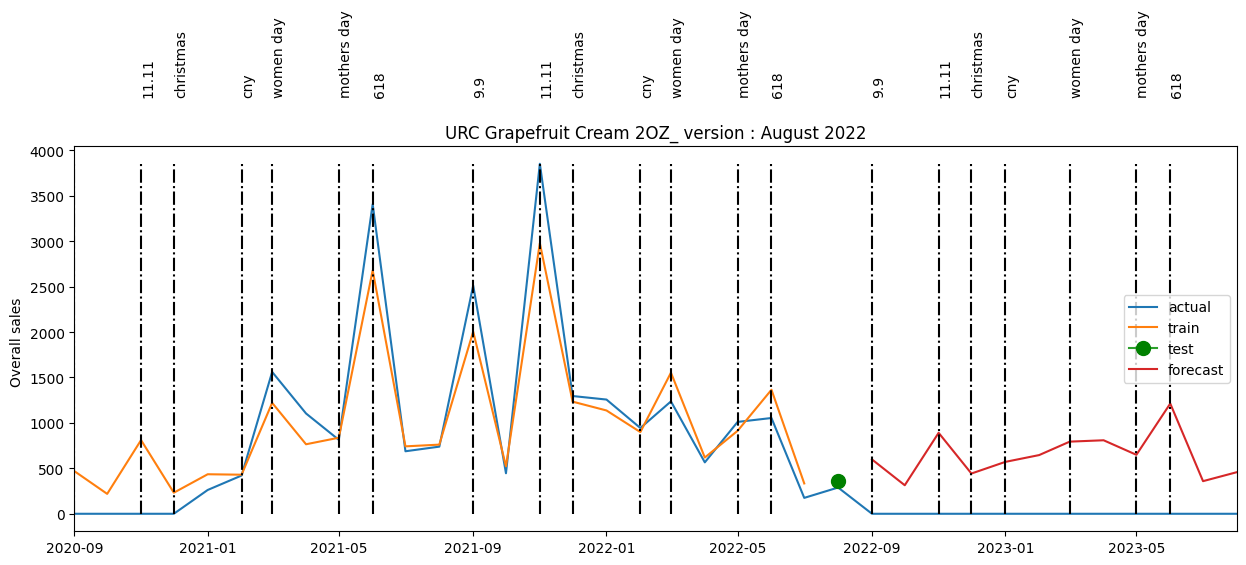

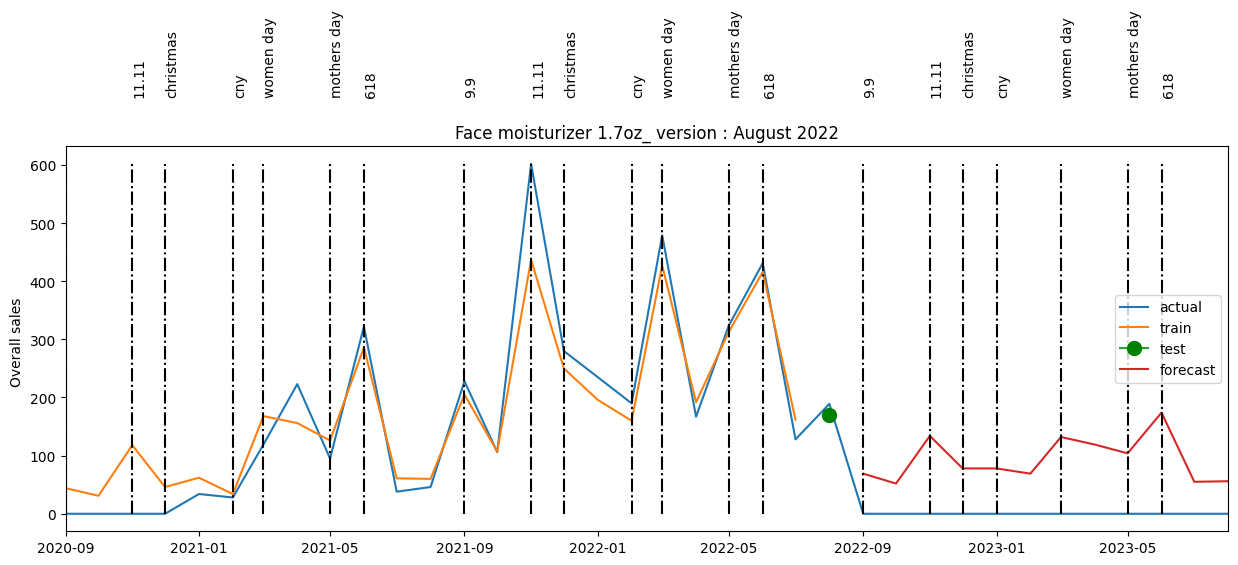

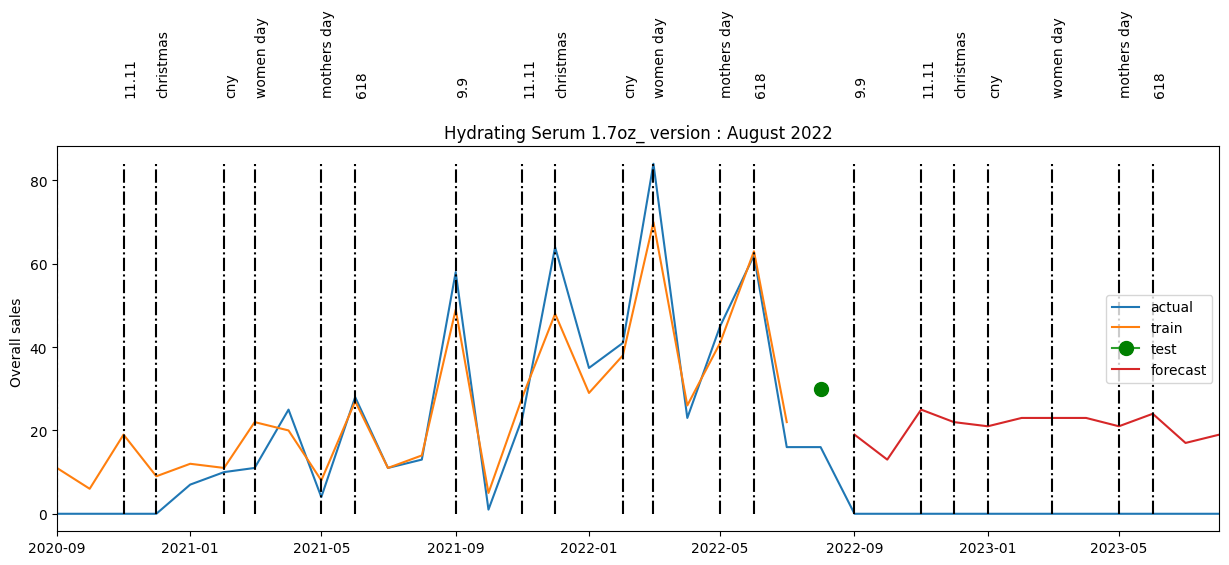

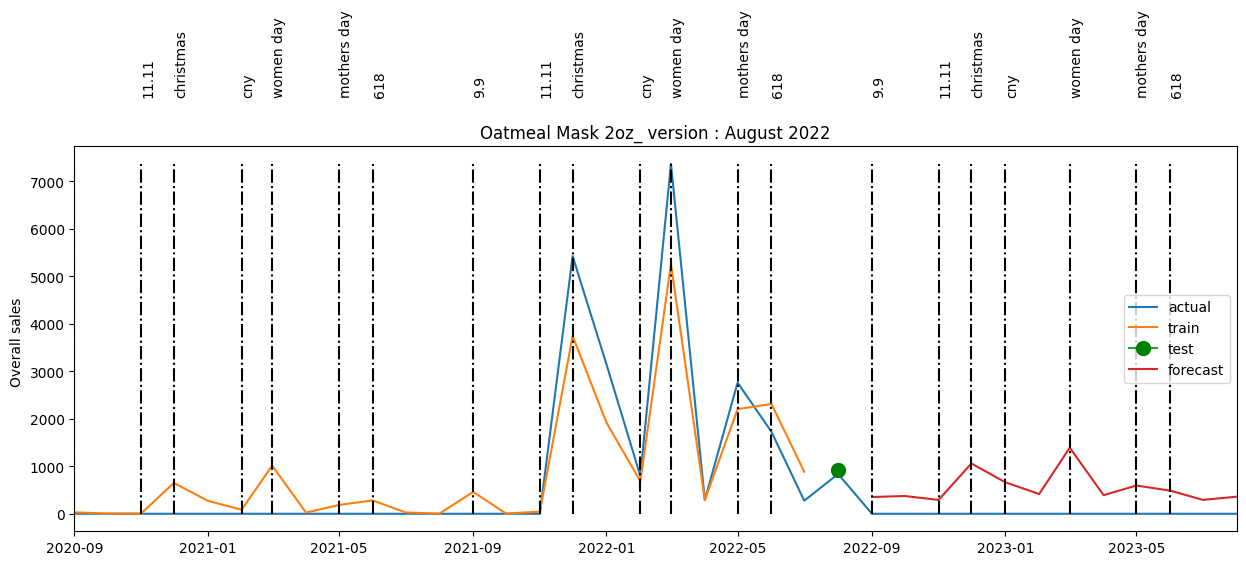

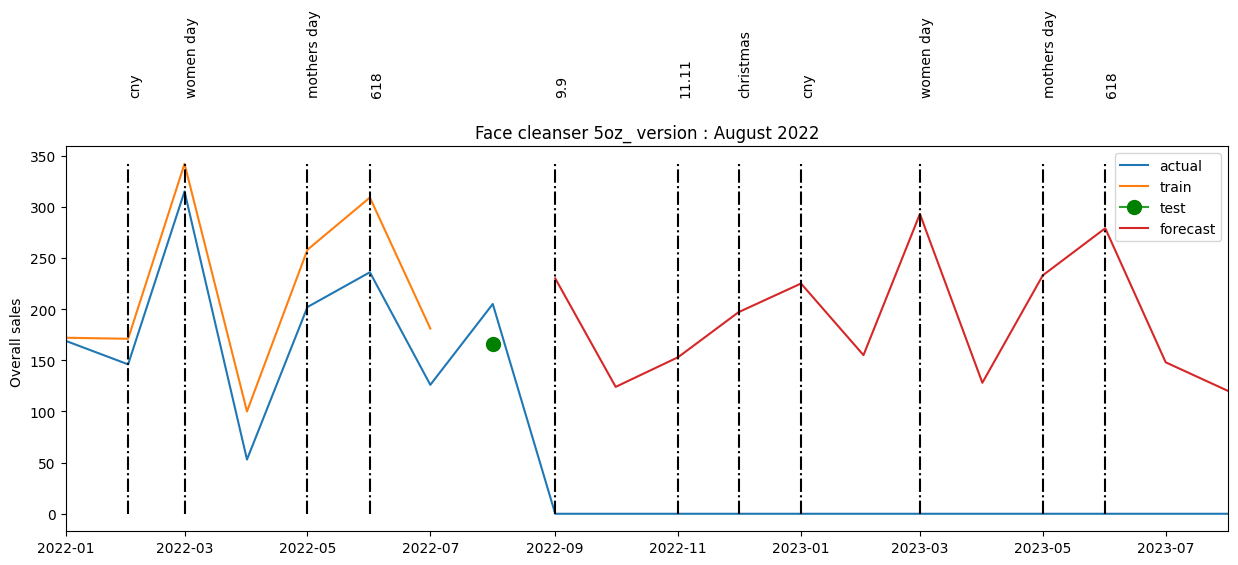

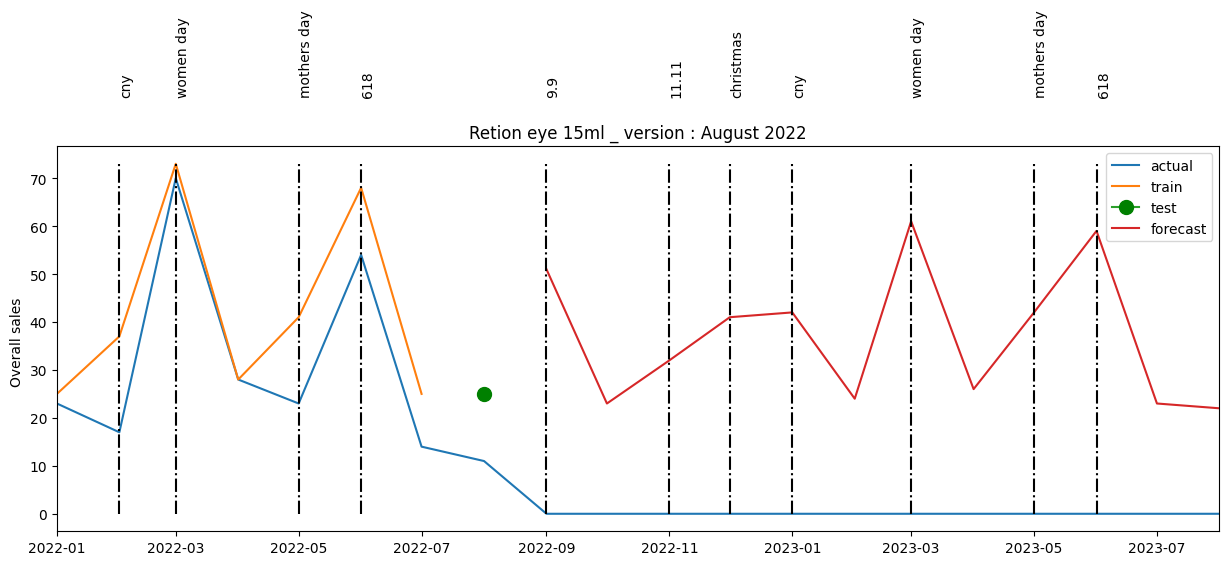

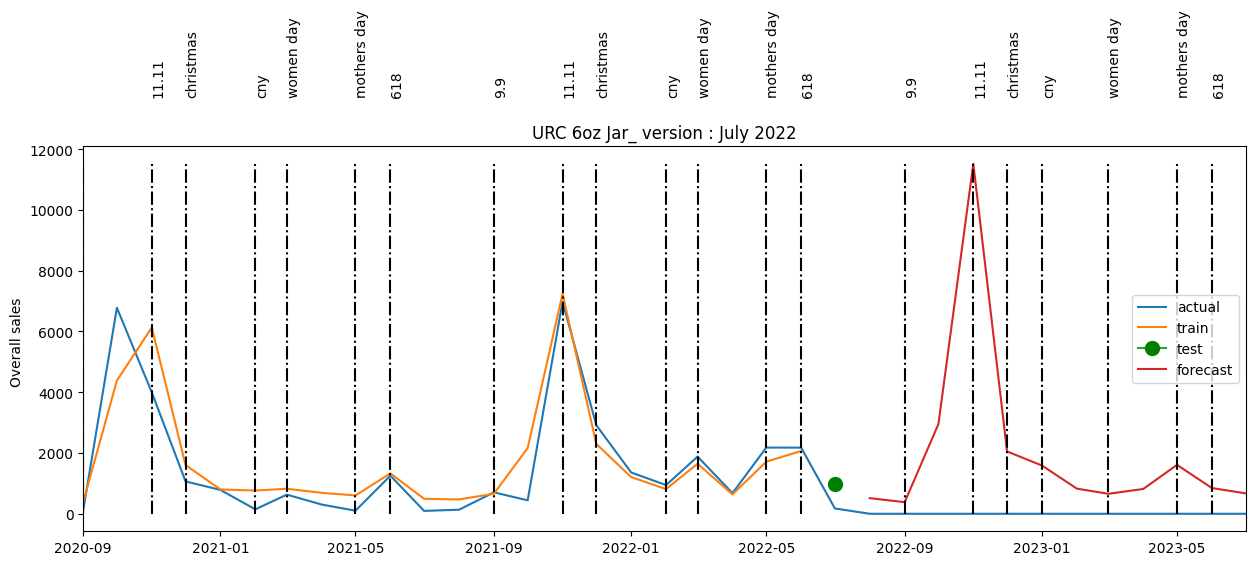

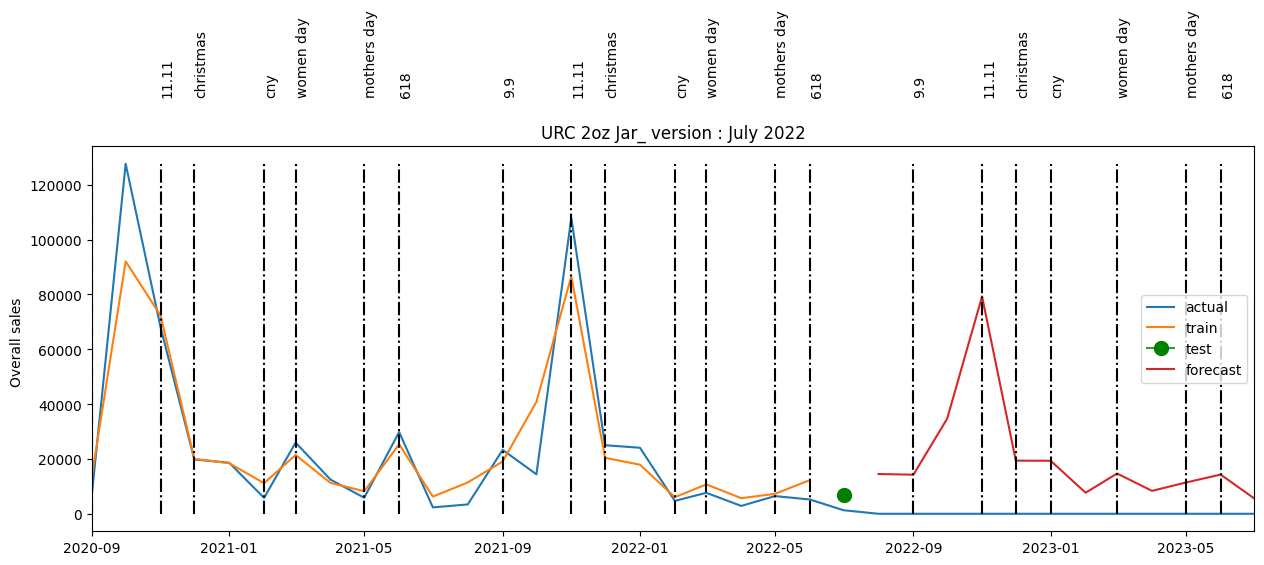

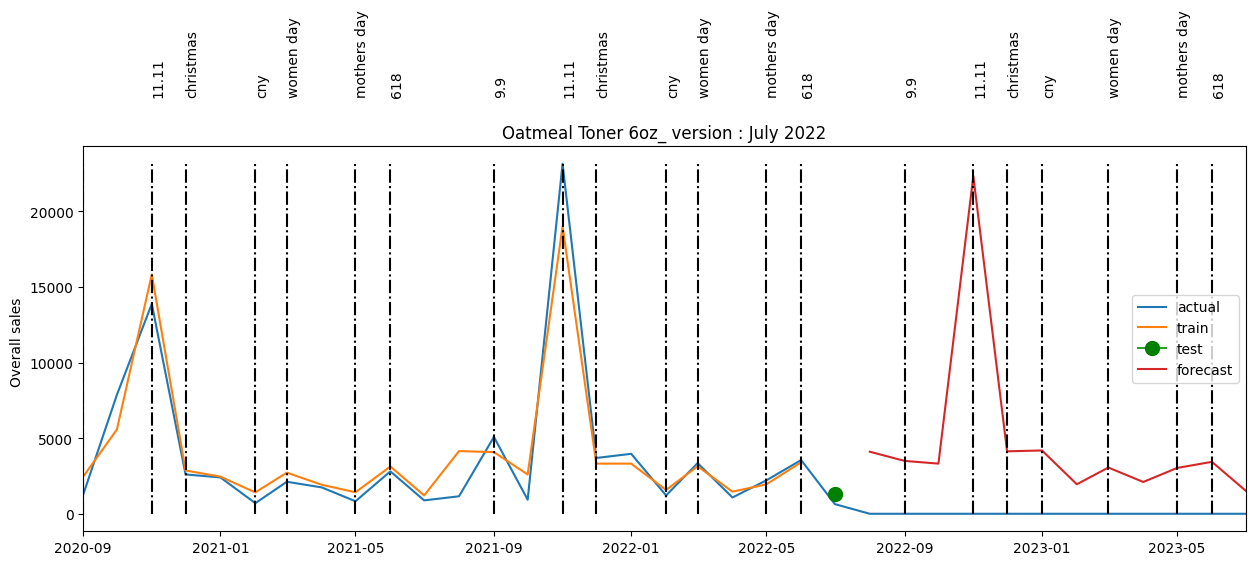

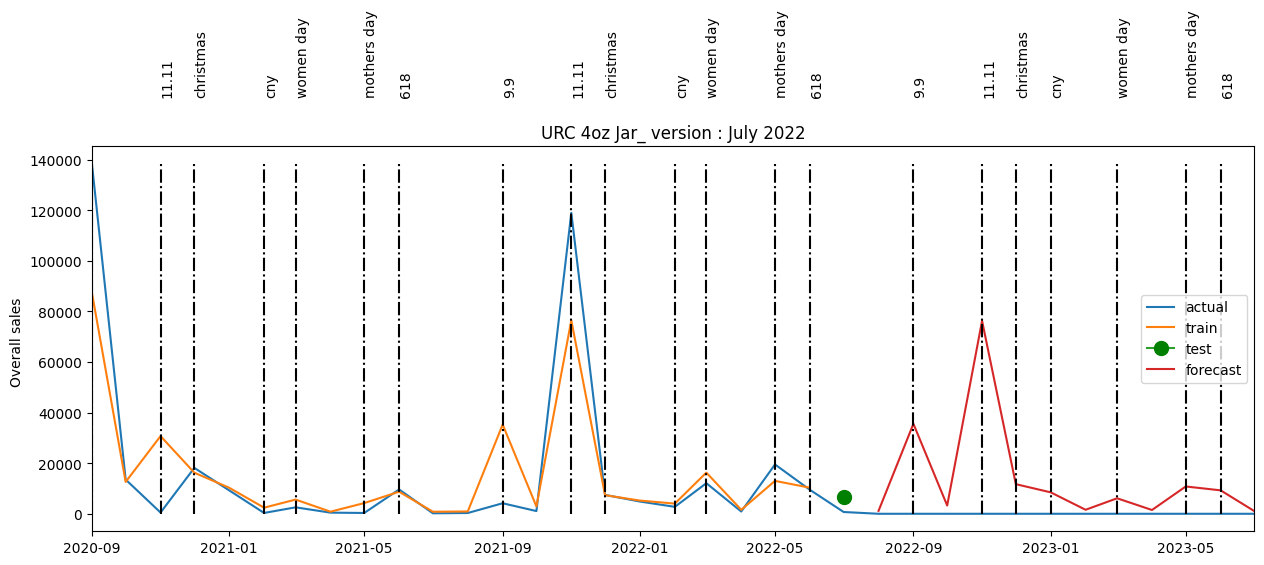

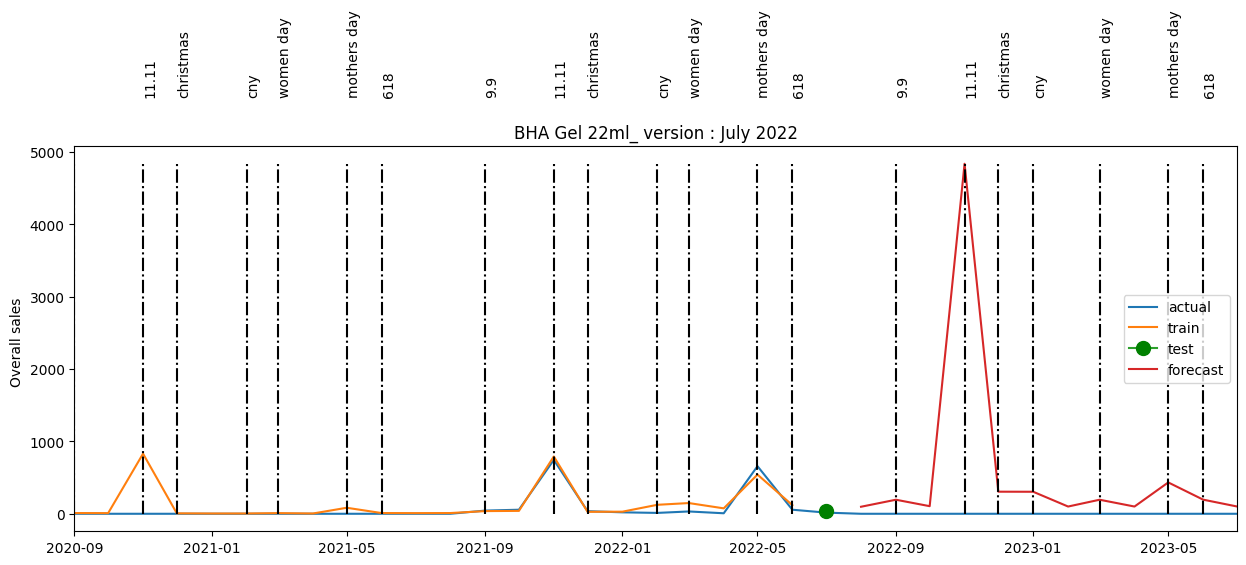

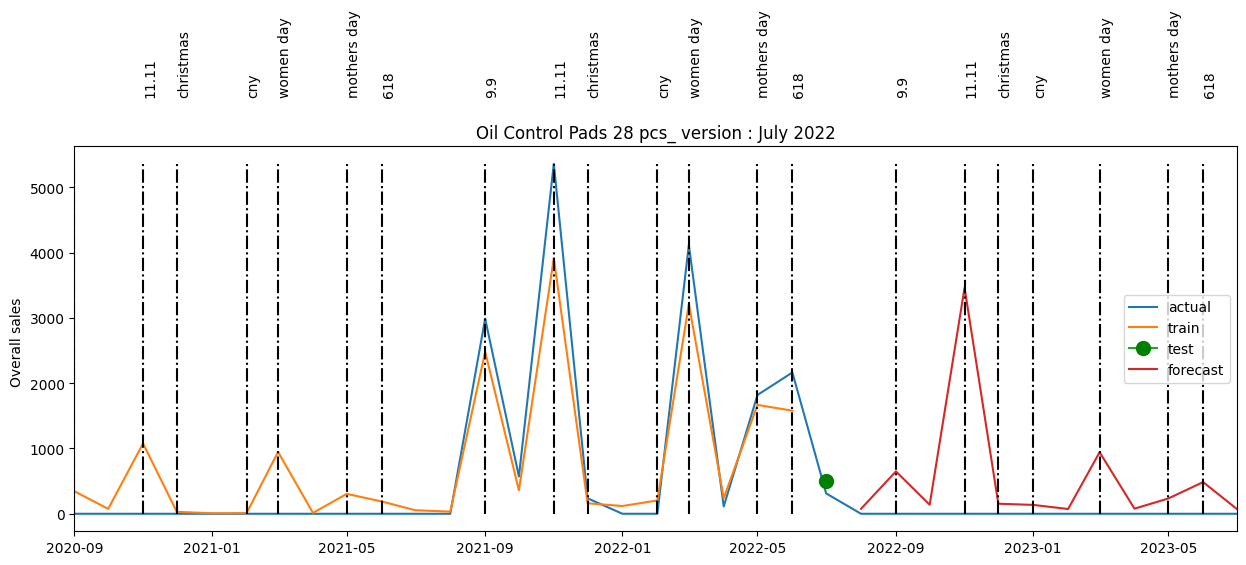

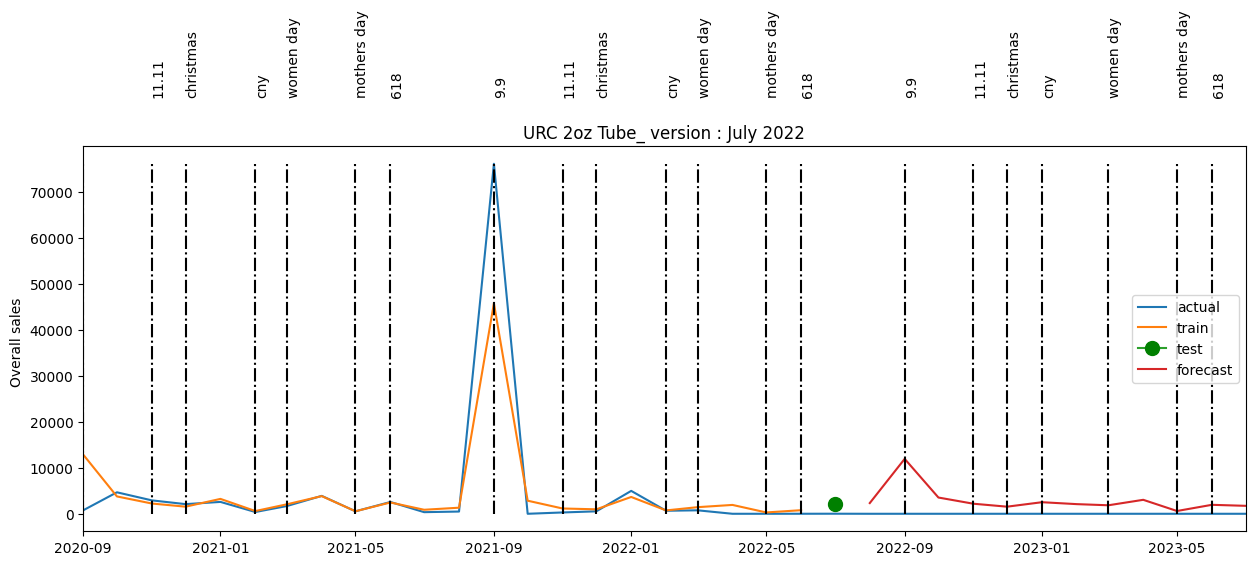

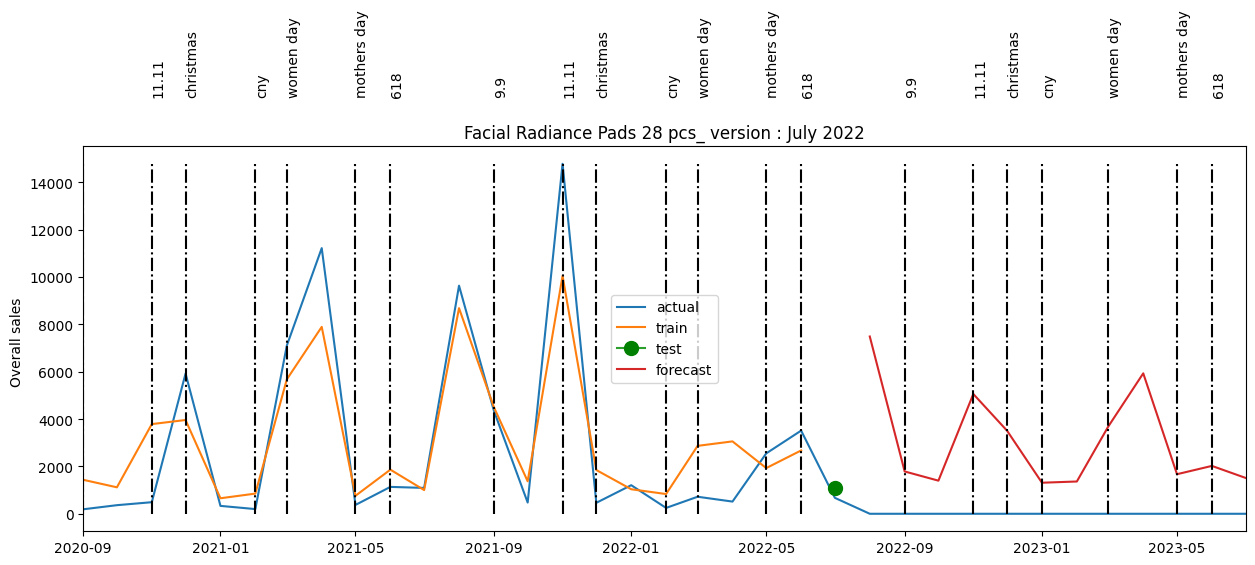

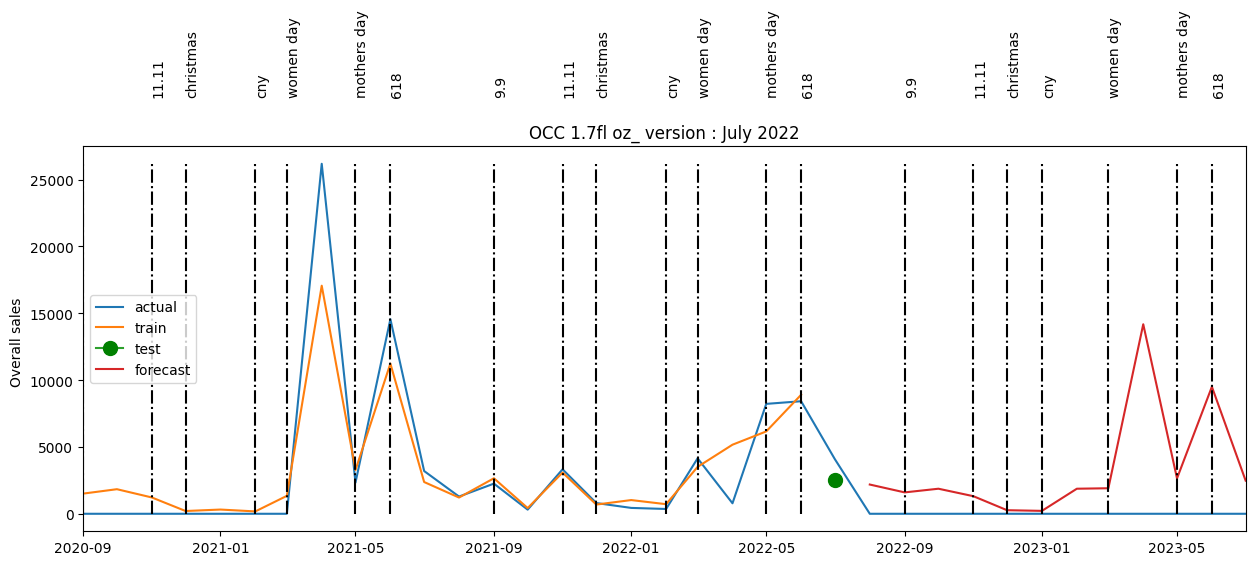

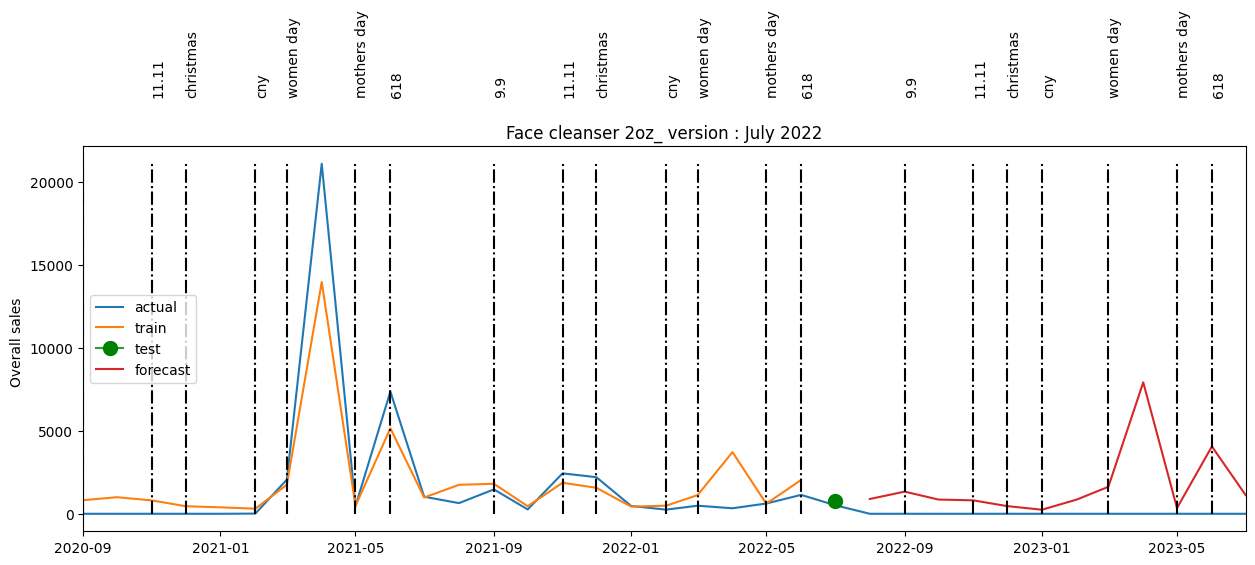

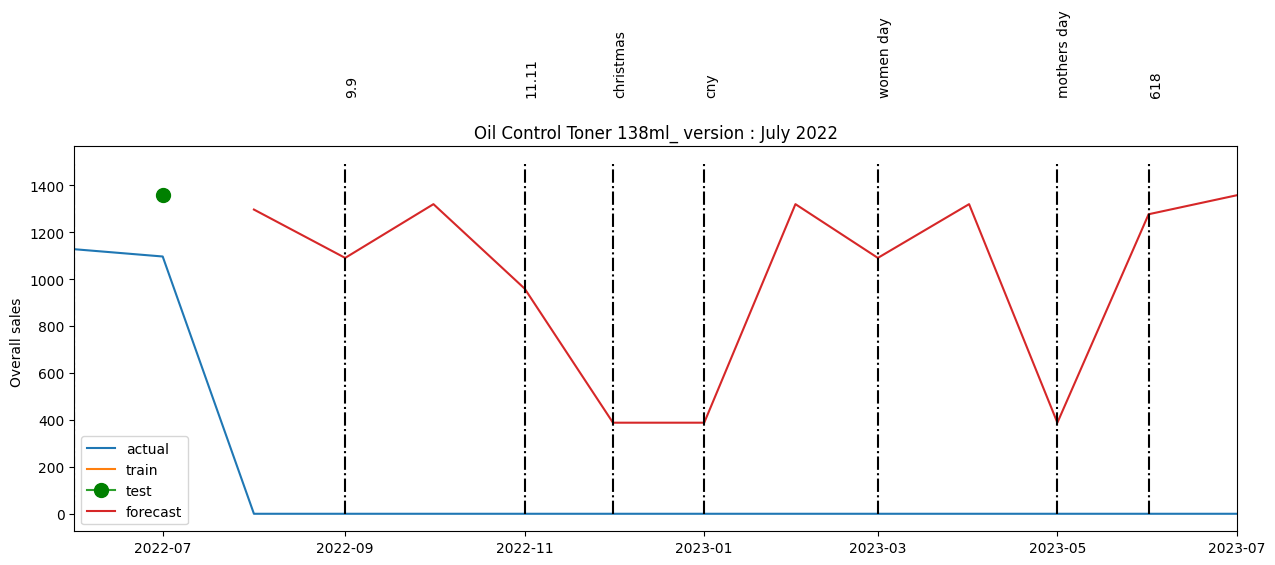

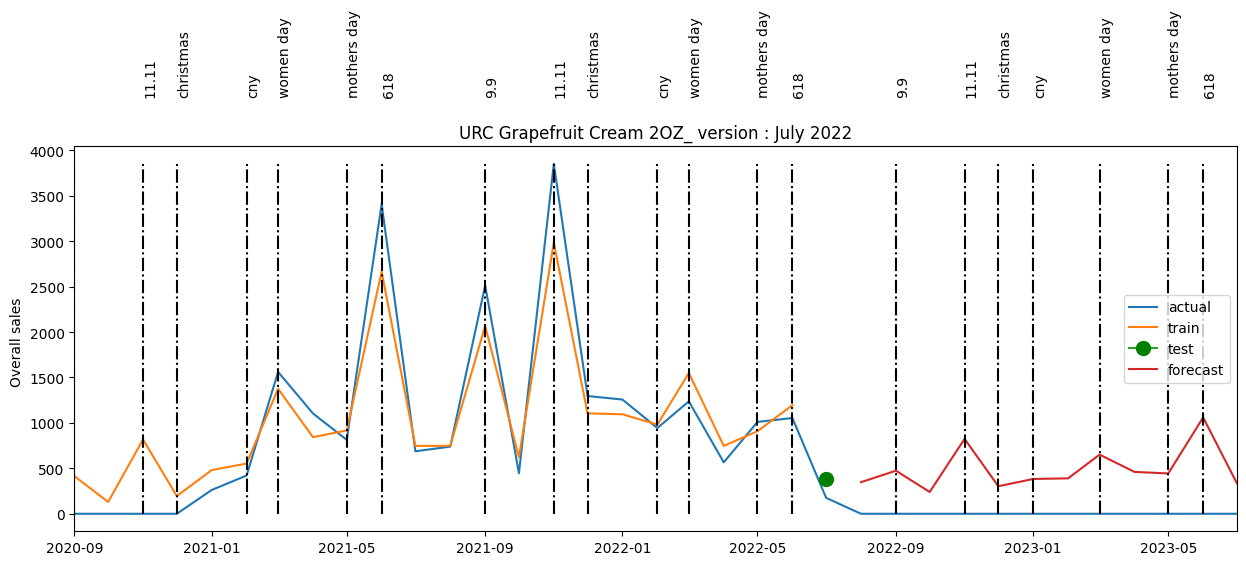

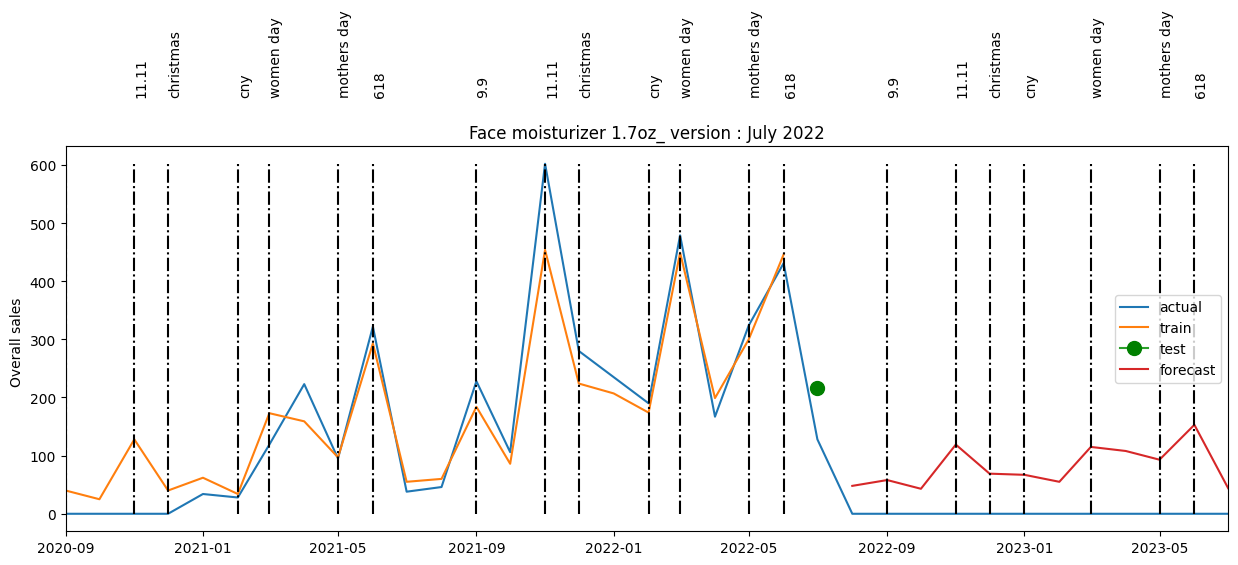

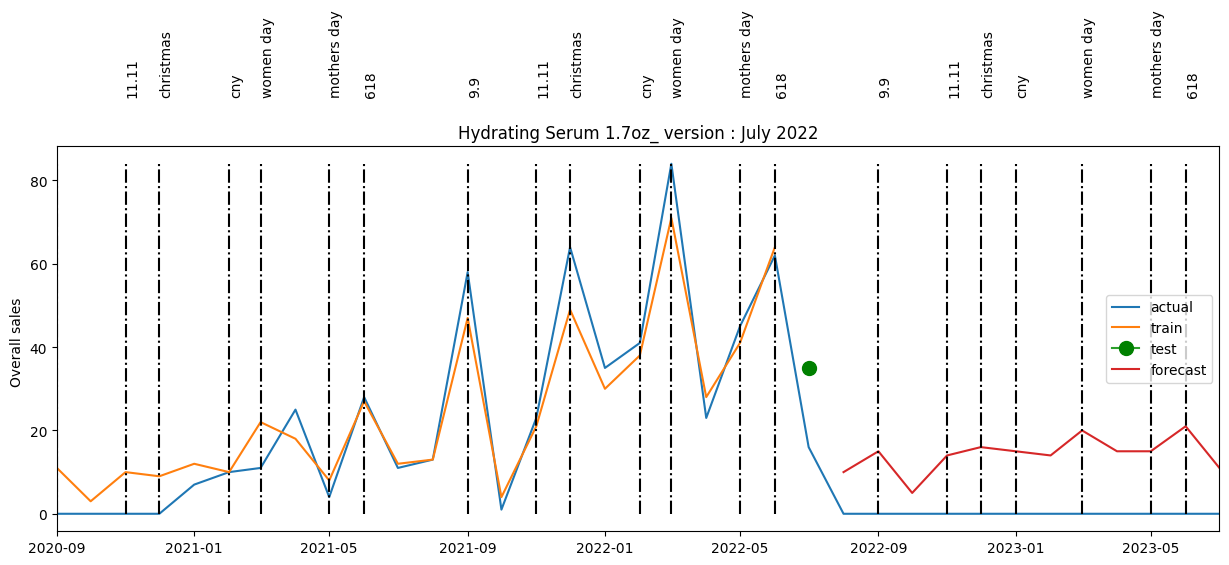

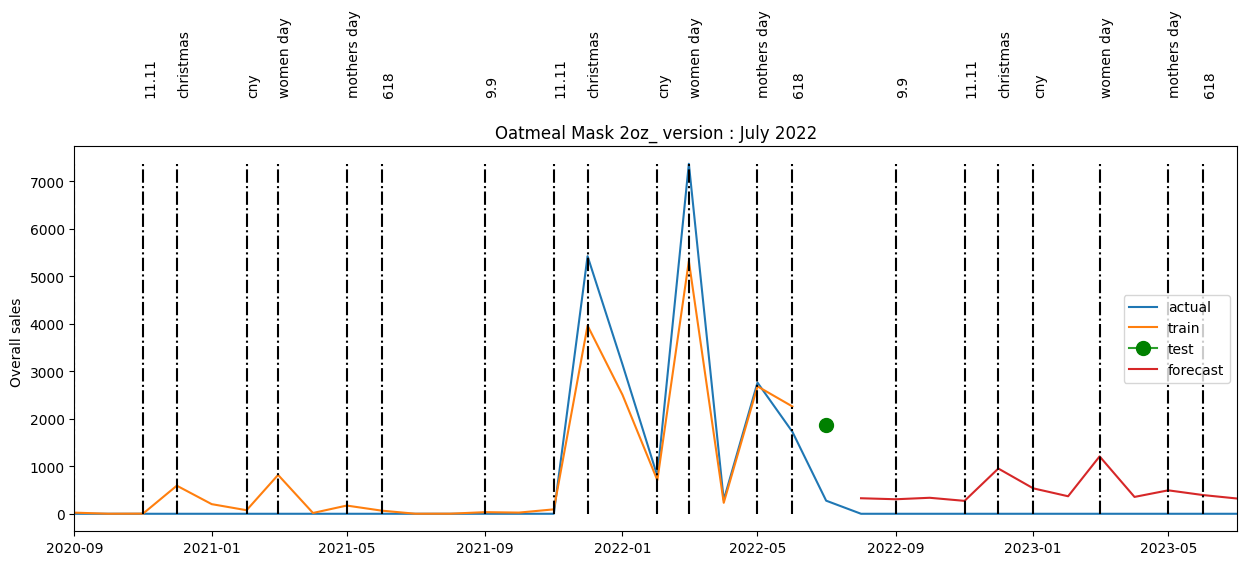

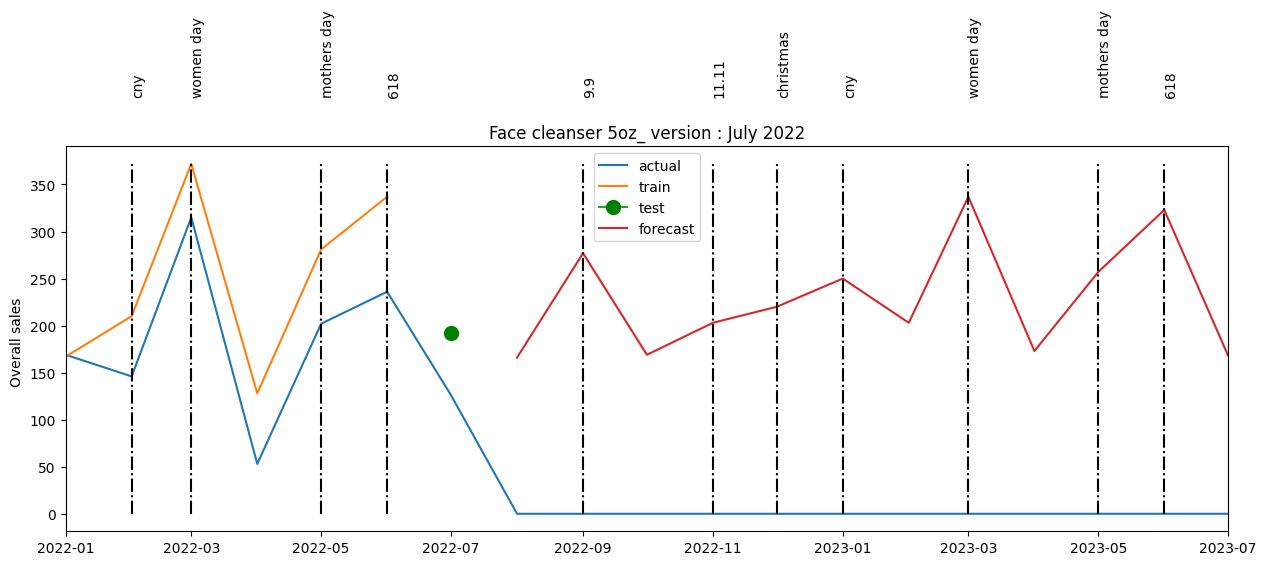

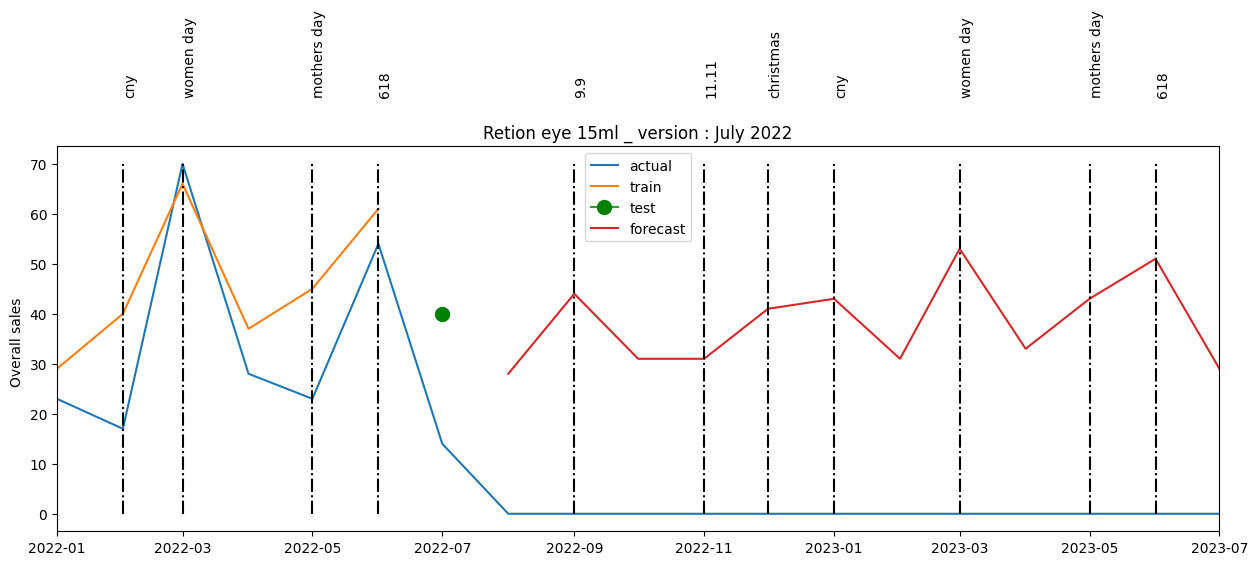

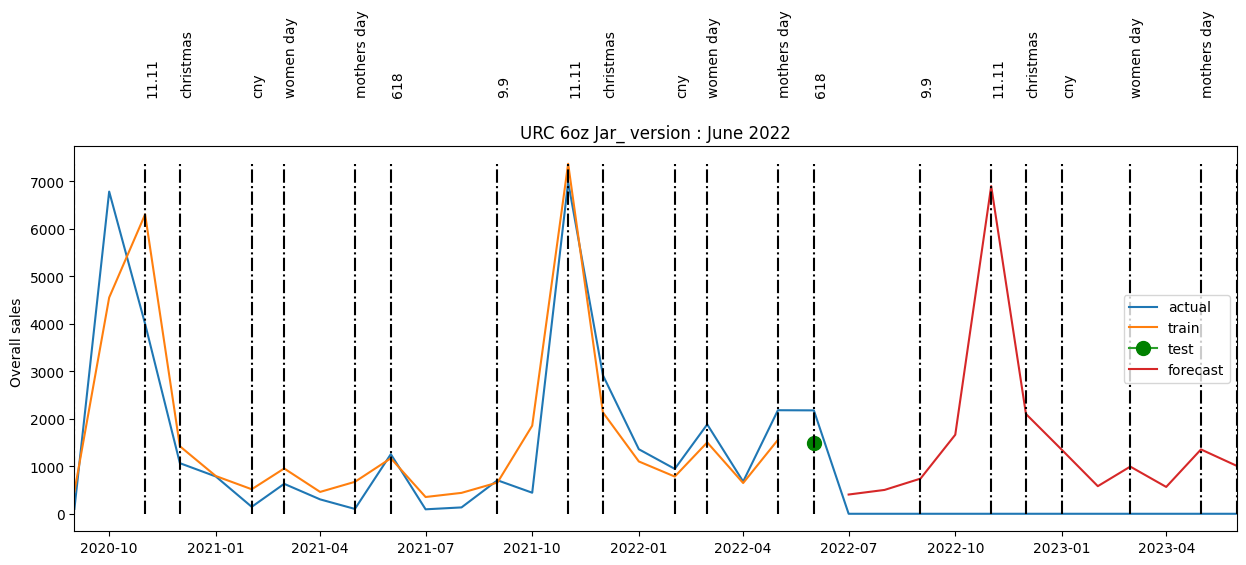

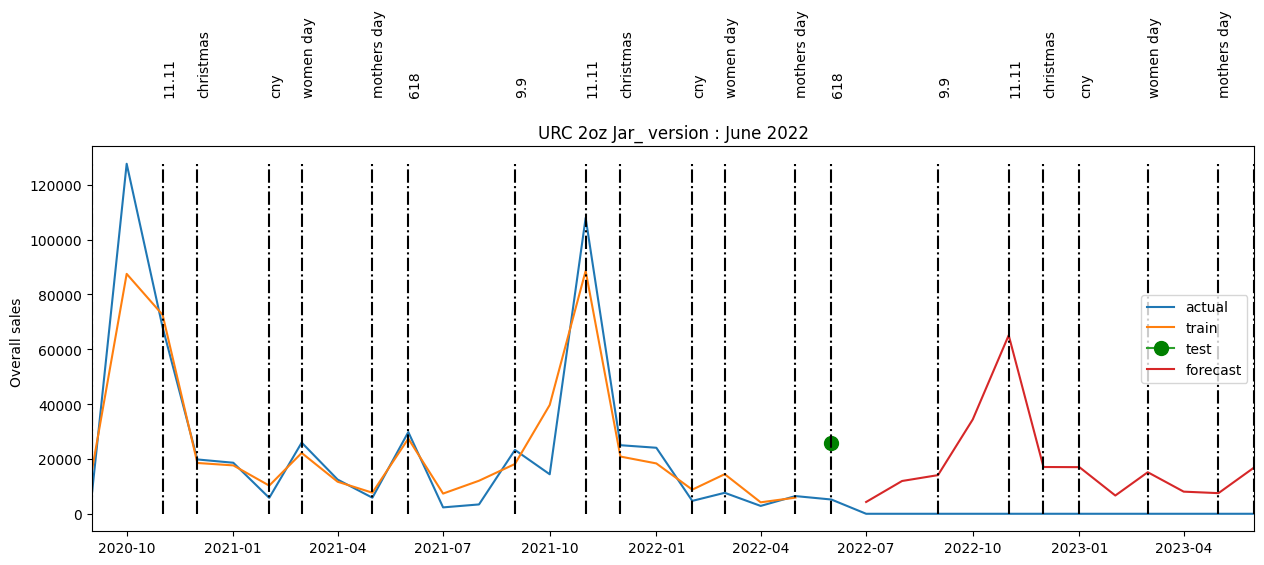

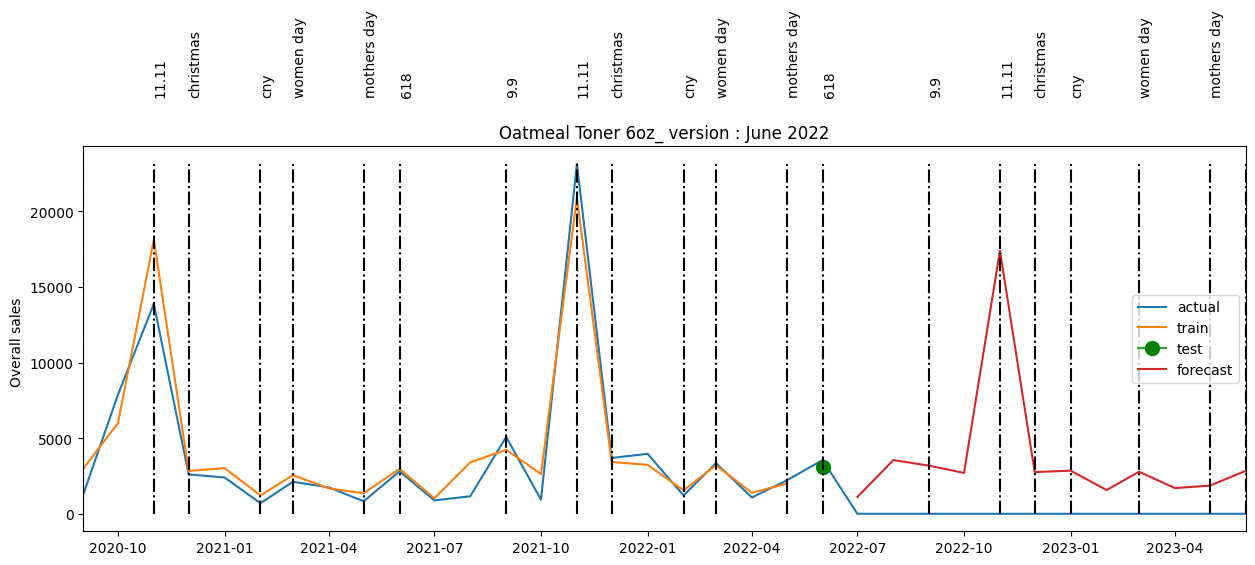

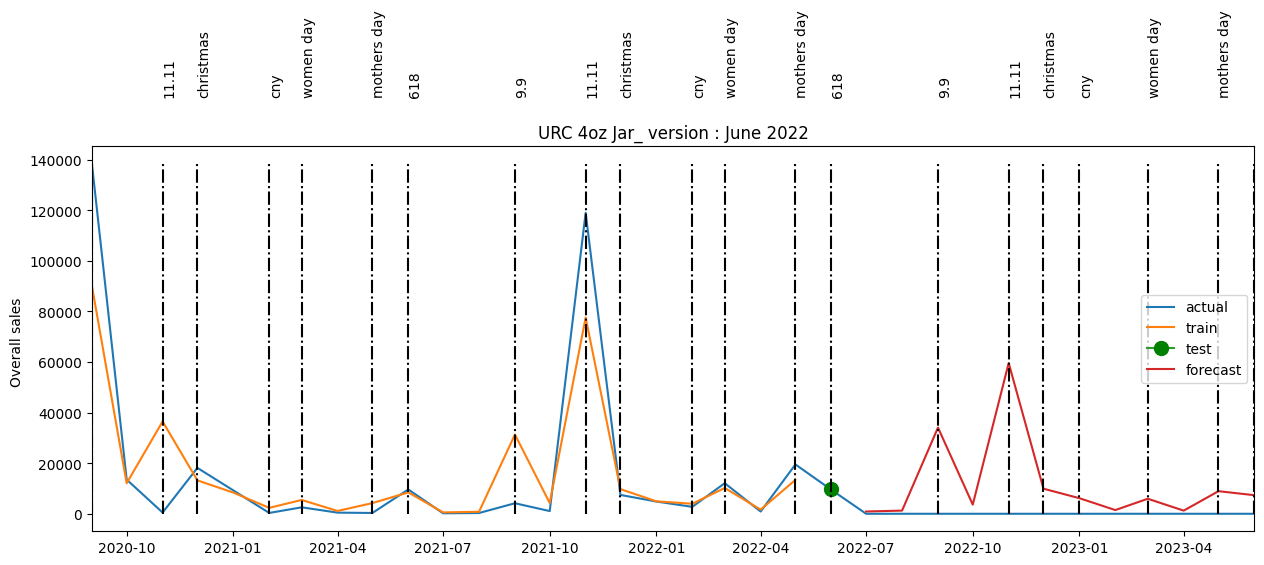

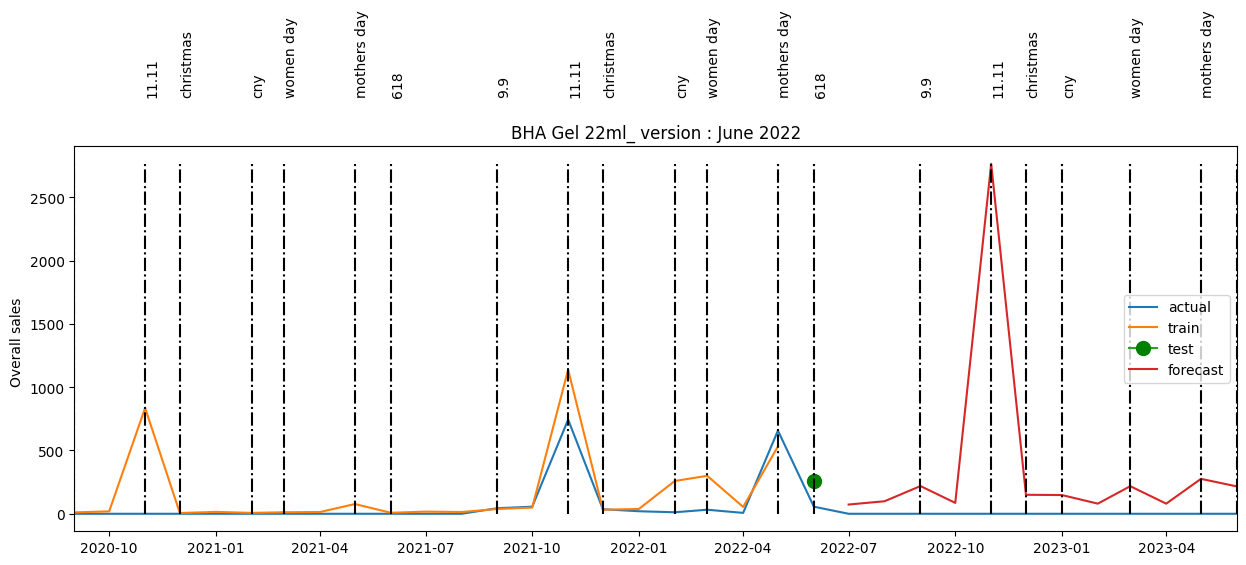

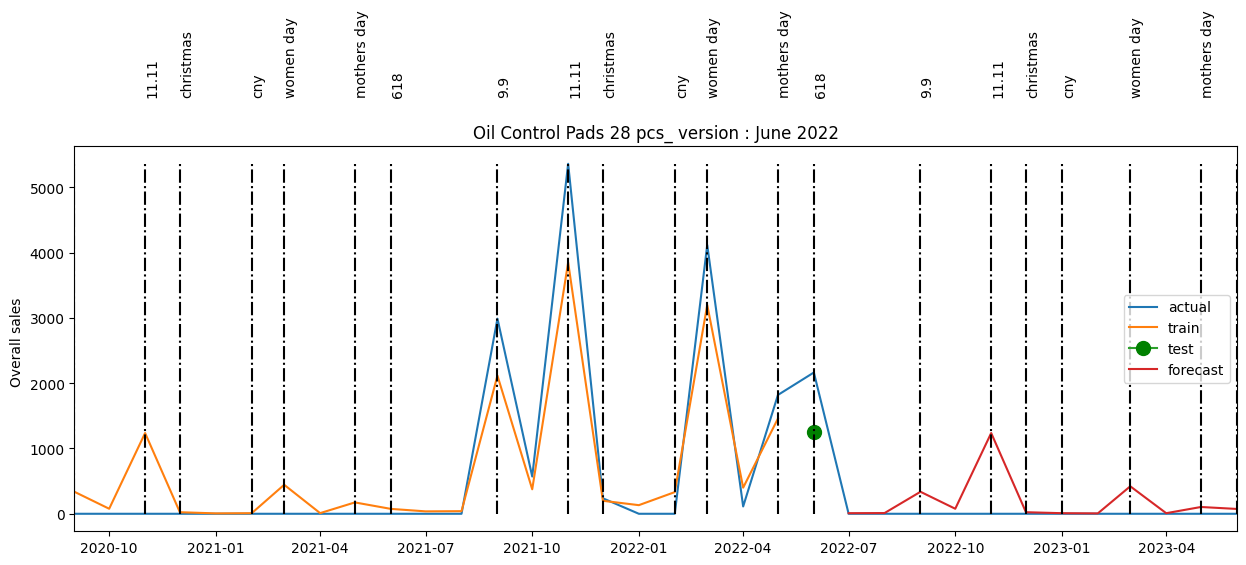

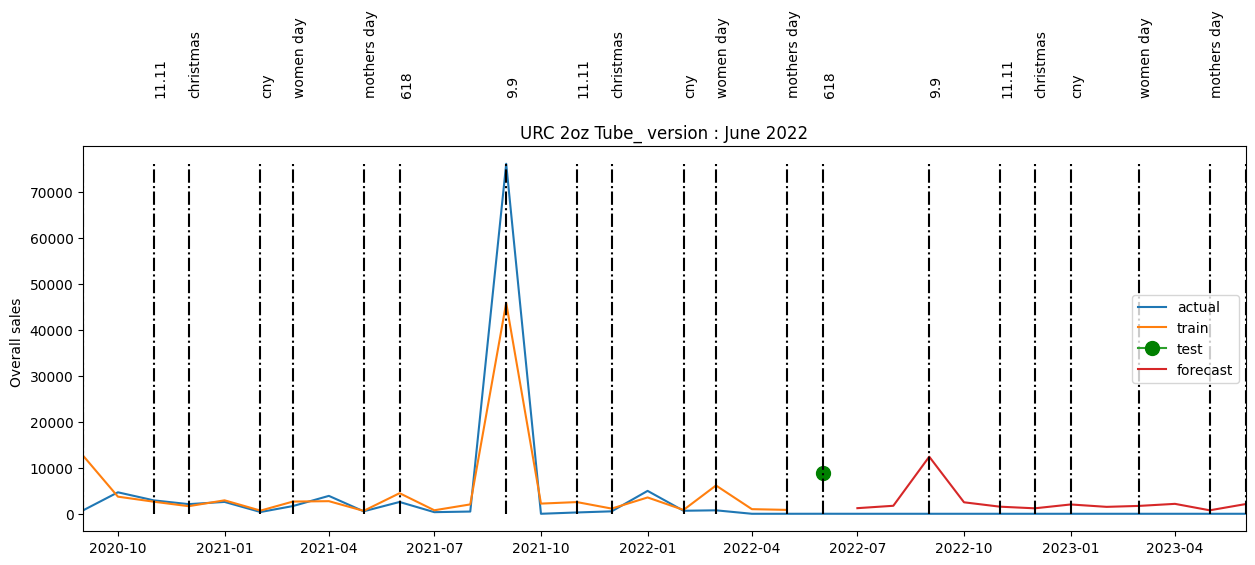

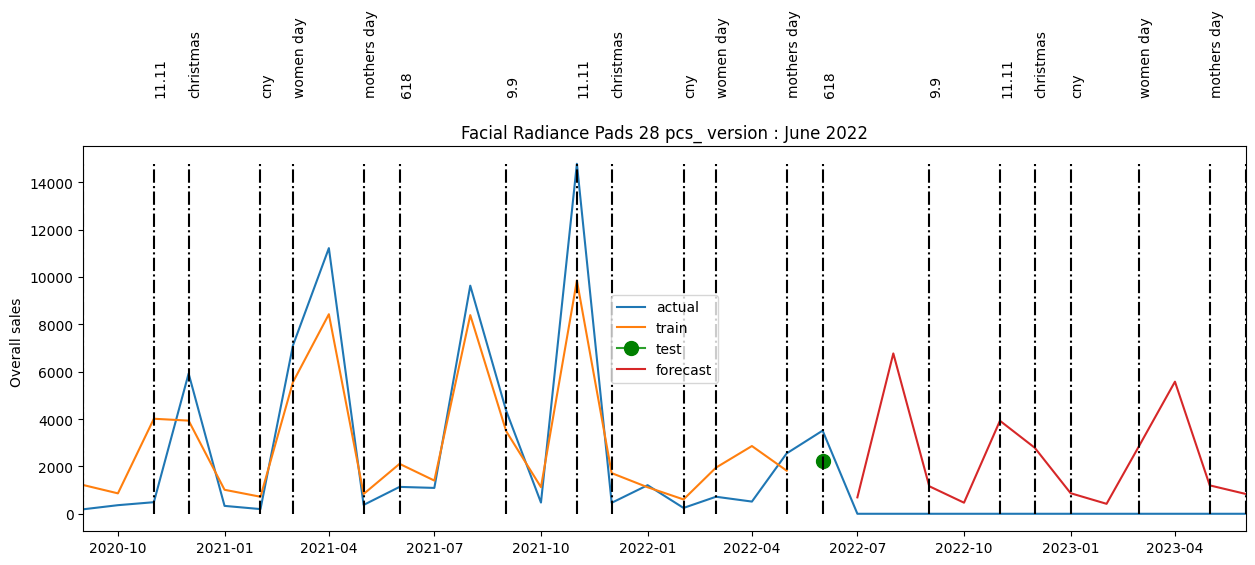

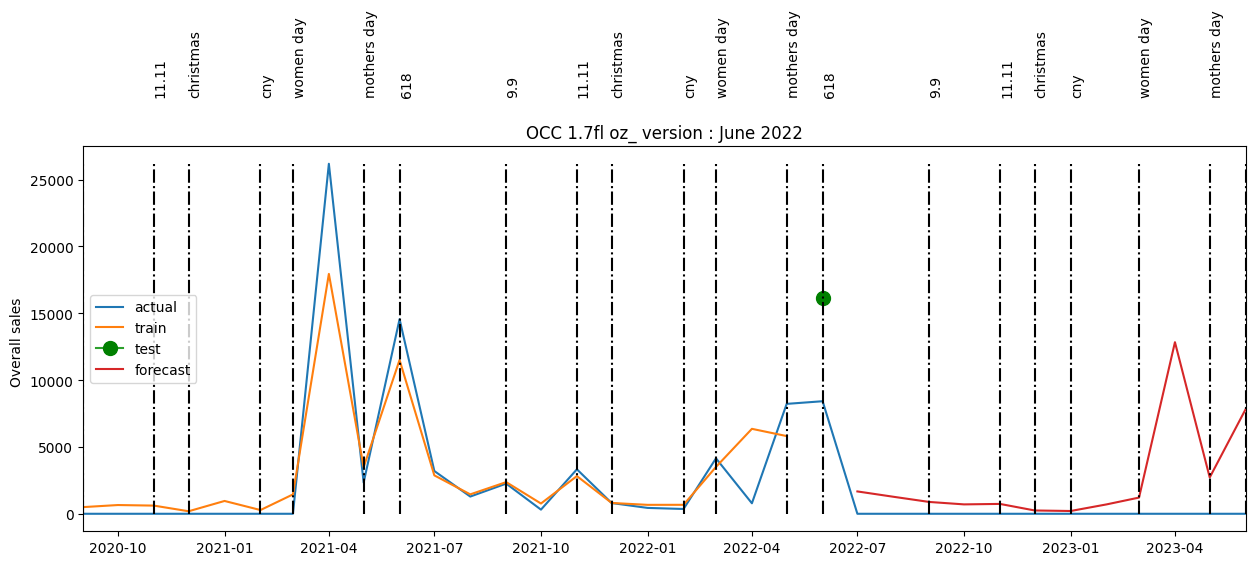

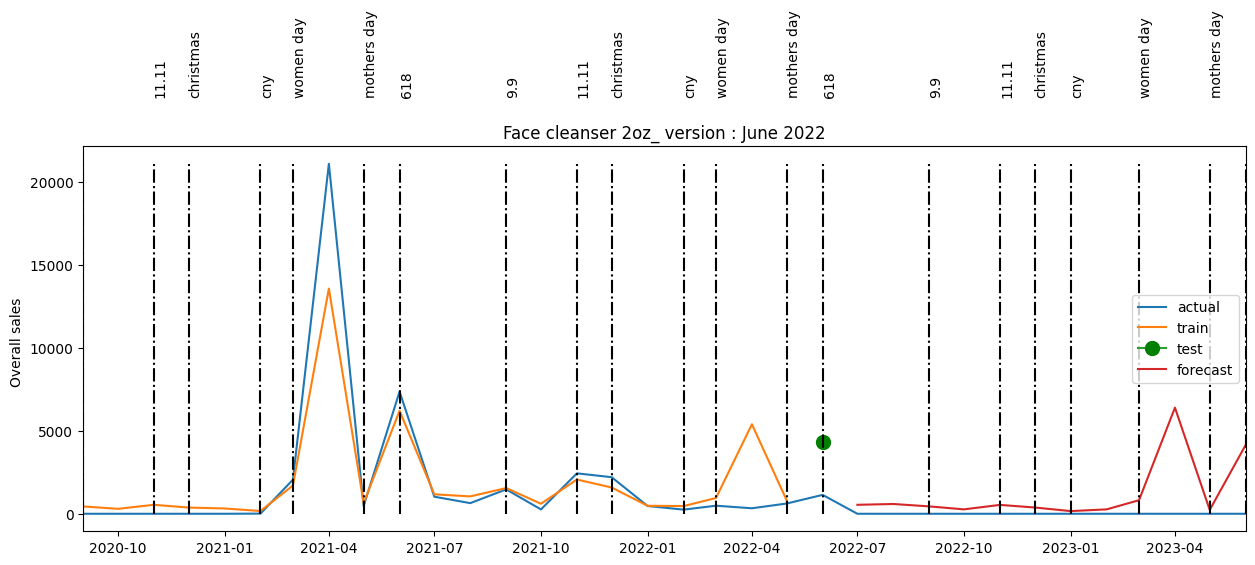

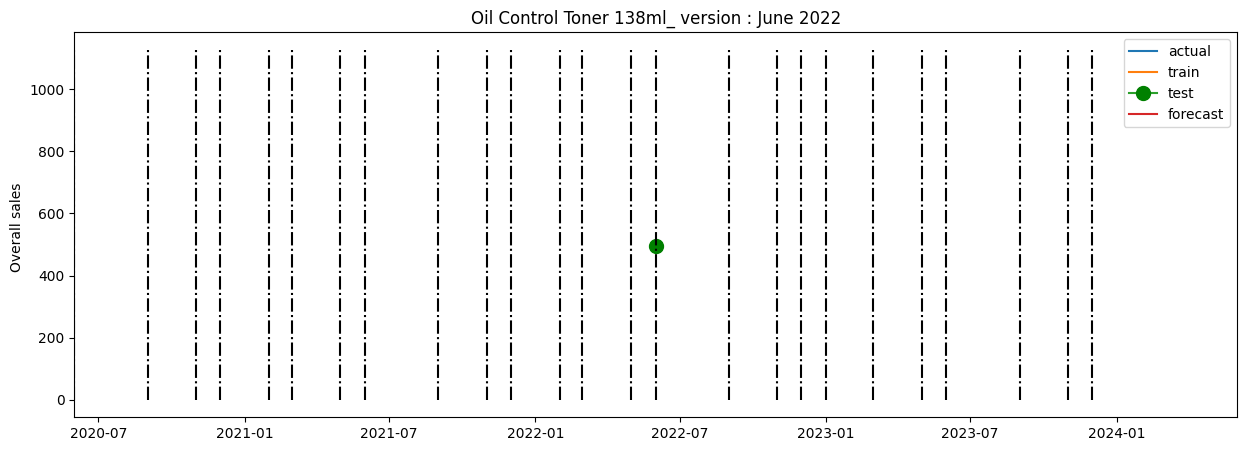

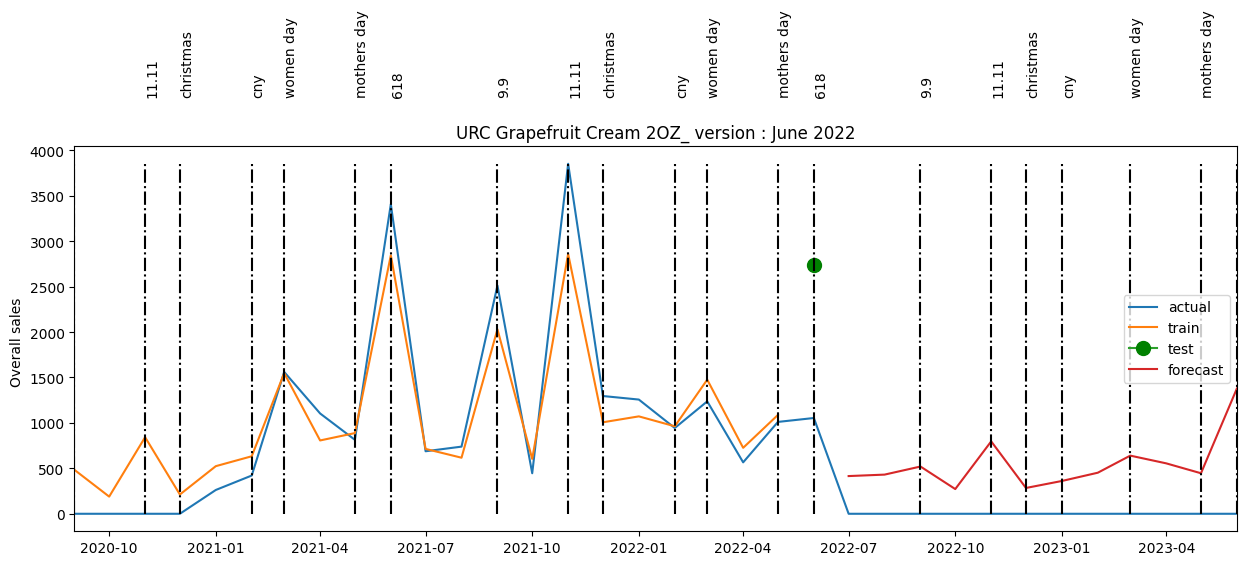

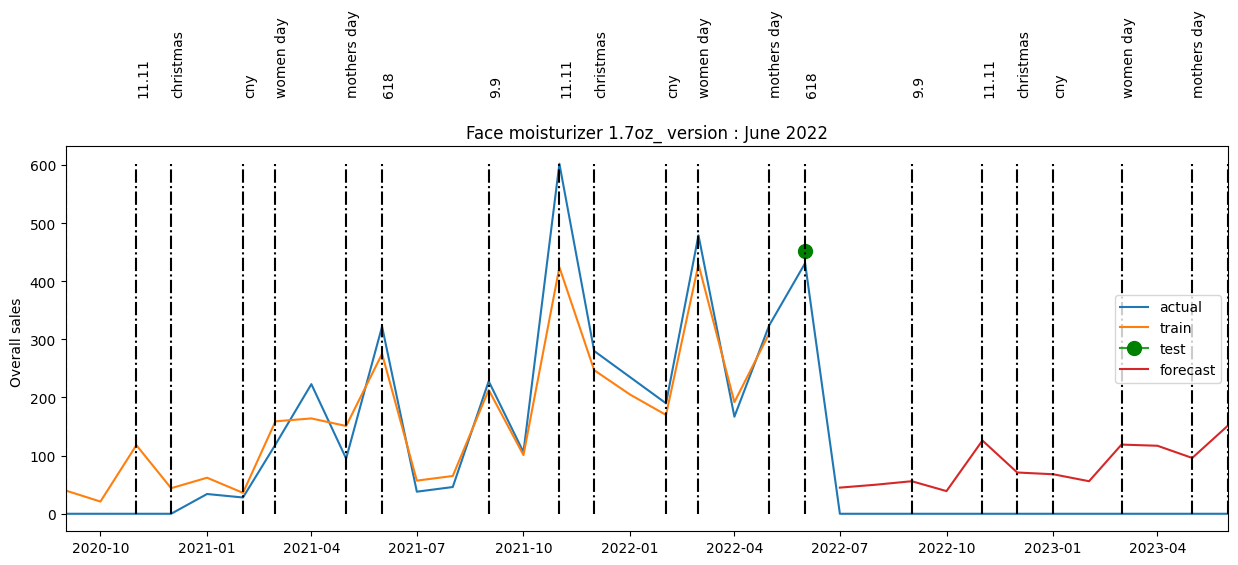

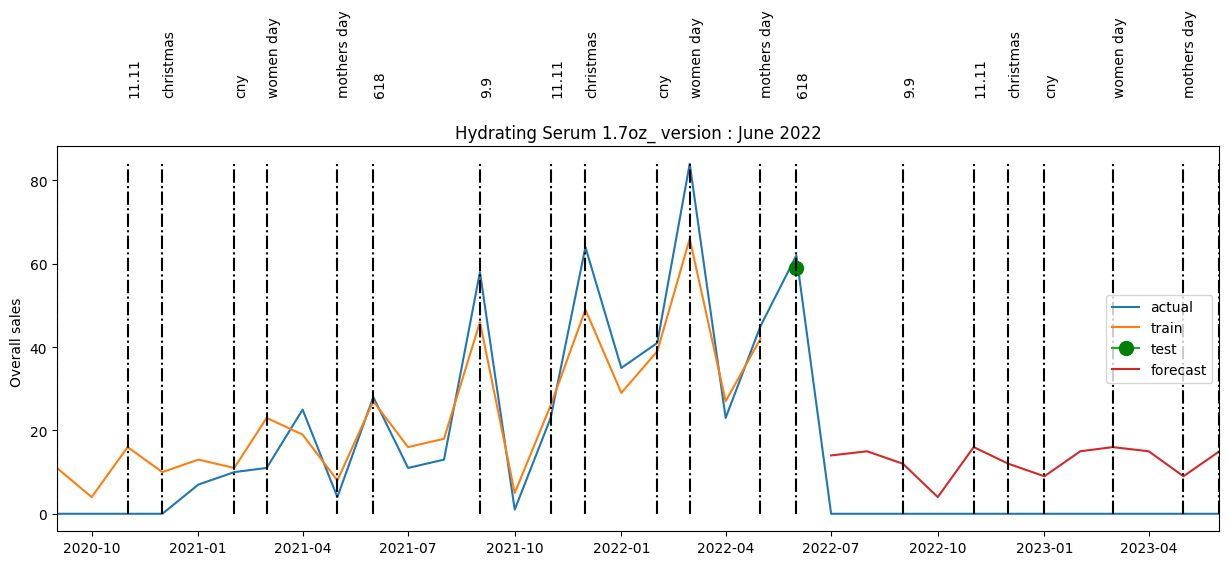

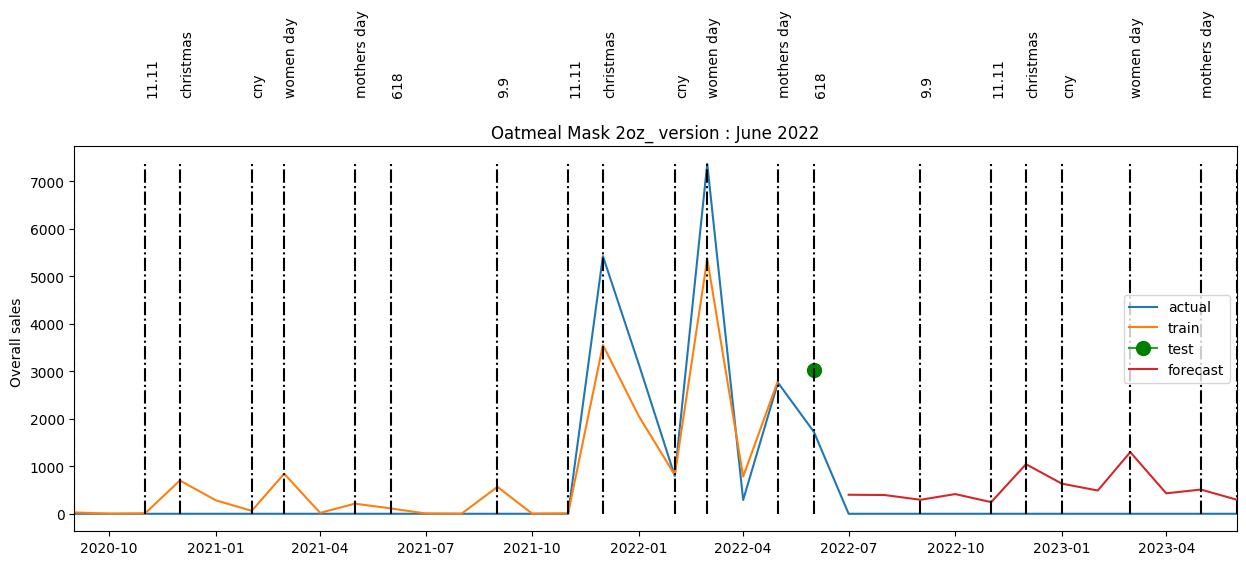

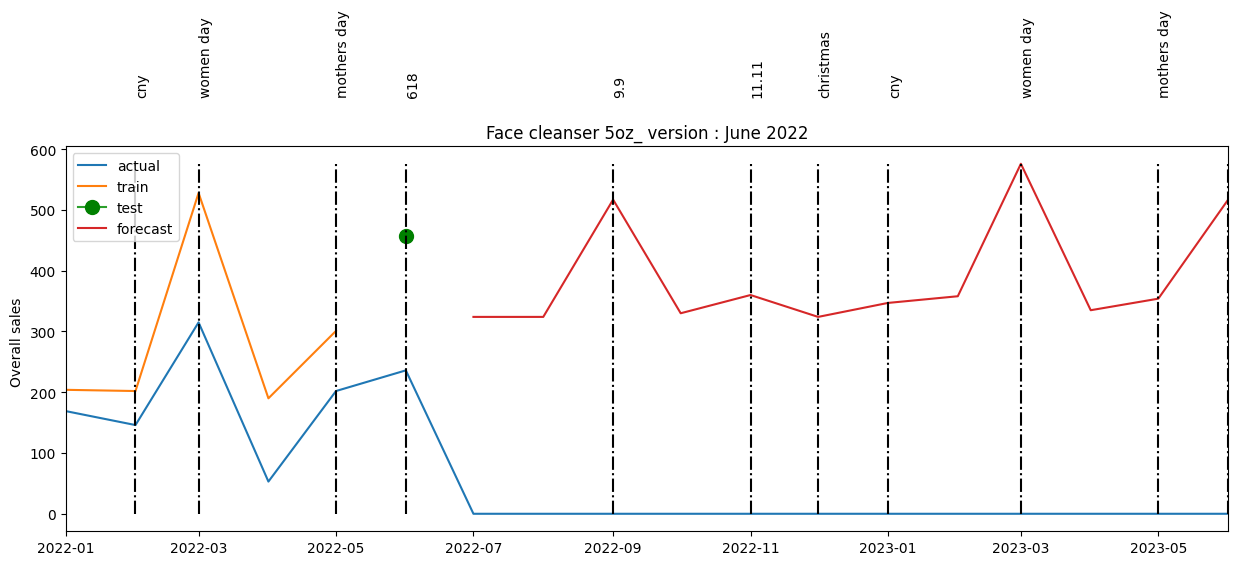

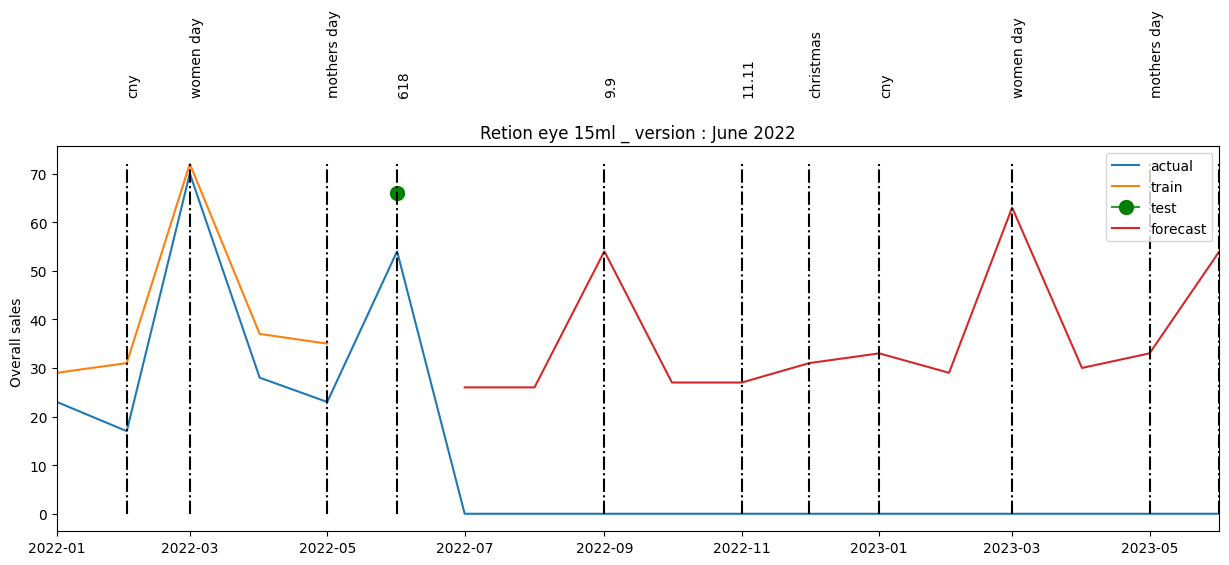

In [47]:
for i in range(len(versions)):
    this_predict = predict_df.loc[predict_df.version == versions[i]]
    this_predict['sku_cust'] = this_predict['shortname'].astype(str) 
    sku_custs =  this_predict.sku_cust.unique()
    for this_sku_cust in sku_custs :
        this_ts = this_predict[this_predict['sku_cust'] == this_sku_cust]
        sku_desc = this_ts.sku_cust.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["test"][0]]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(15,5))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title( this_sku_cust + "_ version : " + str(pd.to_datetime(versions[i]).strftime("%B")) + " 2022")
        plt.legend()
        plt.show()

In [48]:
all_forecast_versions = predict_df.version.unique()
forecast_version_to_test_dates = {}
count = 0
for i in all_forecast_versions:
    this_test_dates = pd.date_range(
        start= pd.to_datetime(all_dates[i]['test'][0]),
        end= pd.to_datetime(all_dates[i]['forecast'][1]),
        freq=freq,
    )
    forecast_version_to_test_dates.update({i: this_test_dates})
    count += 4
forecast_version_to_test_dates

{'2022-08-01': DatetimeIndex(['2022-08-01', '2022-09-01', '2022-10-01'], dtype='datetime64[ns]', freq='MS'),
 '2022-07-01': DatetimeIndex(['2022-07-01', '2022-08-01', '2022-09-01'], dtype='datetime64[ns]', freq='MS'),
 '2022-06-01': DatetimeIndex(['2022-06-01', '2022-07-01', '2022-08-01'], dtype='datetime64[ns]', freq='MS')}

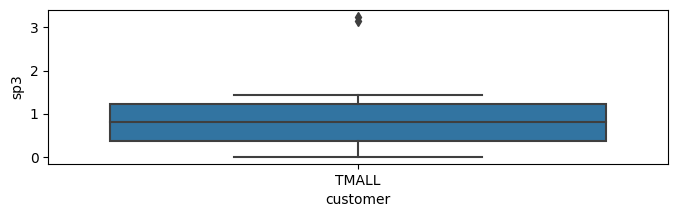

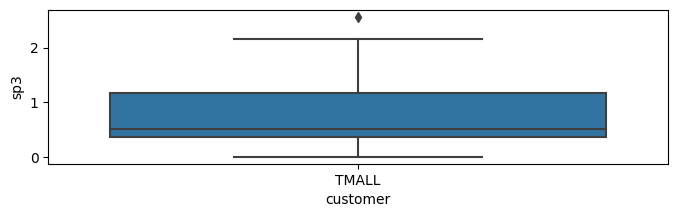

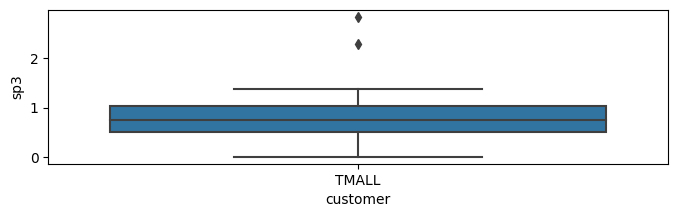

In [49]:
results_sp3 = pd.DataFrame()
for i in range(len(versions)):
    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id) & (predict_df["version"] == versions[i])  ].reset_index(drop=True)
        ts.drop(columns={'y'}, inplace = True)
        ts = pd.merge(ts, df[['ts', 'id', 'y']], on = ['ts', 'id'], how = 'left')
        ts = ts[ts['ts'] <= np.max(df['ts'])]
        test = ts.loc[ ts.ts.isin( forecast_version_to_test_dates[versions[i]]) ].copy()
        
        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "id": _id,
            "version" : versions[i],
            "sku": ts["sku"][0],
            "customer": ts["customer"][0],
            "test_start": forecast_version_to_test_dates[versions[i]][0],
            "test_end":  np.max(ts['ts']),
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results_sp3 = results_sp3.append(metrics, ignore_index=True, sort=False)

main_cols = ["id", "sku", "customer", "version", "test_start", "test_end", "total_actual", "total_forecast"]
results_sp3 = results_sp3[main_cols + list(results_sp3.drop(columns=main_cols).columns)].copy()
results_sp3["sp3"] = results_sp3["total_actual"] / results_sp3["total_forecast"]
results_sp3["sp3"] = np.nan_to_num(results_sp3["sp3"], nan=1, posinf=0, neginf=0)
results_sp3["model"] = predict_df.model[0]

results_sp3.sort_values(by="id").reset_index(drop=True).set_index(["model", "id"])
results_sp3.groupby("customer").mean()
results_sp3.groupby("customer").median()

for i in range(len(versions)): 
    this_results = results_sp3[results_sp3['version'] == versions[i]]
    plt.figure(figsize=(8,2))
    #plt.ylim(0,15)
    sns.boxplot(data=this_results, y="sp3", x="customer")
    plt.show()

    

In [50]:
results_sp1_att = results.copy()
results_sp1_att.drop(columns={'id'},inplace=True)
print(results_sp1_att.shape)
att_df1 = att_df[['cases', 'customer', 'item_type', 'material', 'ph_level2', 'ph_level3',
       'sku', 'sku_description', 'uom']].drop_duplicates()
print(results_sp1_att.shape)
results_sp1_att = pd.merge(results_sp1_att,att_df1,on=['sku','customer'])
print(results_sp1_att.shape)
results_sp1_att = pd.merge(results_sp1_att,att_main,on='sku')
results_sp1_att['date_num'] = pd.to_numeric(results_sp1_att['test_start'])
results_sp1_att['sp1'] = results_sp1_att['sp1'].round(2)
results_sp1_att.head()

(51, 14)
(51, 14)
(51, 21)


sku customer     version test_start   test_end  total_actual  total_forecast     rmse      mae     smape      mape     maape   sp1               model  cases item_type  material     ph_level2 ph_level3                           sku_description uom    shortname             date_num
0  815517026005    TMALL  2022-08-01 2022-08-01 2022-08-01         108.0           630.0    522.0    522.0  1.414634  4.833333  1.366778  0.17  Model per customer     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1659312000000000000
1  815517026005    TMALL  2022-07-01 2022-07-01 2022-07-01         175.0           979.0    804.0    804.0  1.393414  4.594286  1.356477  0.18  Model per customer     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1656633600000000000
2  815517026005    TMALL  2022-06-01 2022-06-01 2022-06-01        2176.0          1493.0    683.0    683.0  0.372309  0.313879  0.304140  1.46  Model per customer     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1654041600000000000
3  815517026036    TMALL  2022-08-01 2022-08-01 2022-08-01        2288.0         15979.0  13691.0  13691.0  1.498987  5.983829  1.405209  0.14  Model per customer     24     Cream  82314745  Ultra Repair       FAB  FAB UT RPAR CRM 2.0OZ 56.7GX24 JAR JUL20   G  URC 2oz Jar  1659312000000000000
4  815517026036    TMALL  2022-07-01 2022-07-01 2022-07-01        1284.0          6863.0   5579.0   5579.0  1.369584  4.345016  1.344587  0.19  Model per customer     24     Cream  82314745  Ultra Repair       FAB  FAB UT RPAR CRM 2.0OZ 56.7GX24 JAR JUL20   G  URC 2oz Jar  1656633600000000000

In [51]:
results_sp3_att = results_sp3.copy()
results_sp3_att.drop(columns={'id'},inplace=True)
print(results_sp3_att.shape)
att_df1 = att_df[['cases', 'customer', 'item_type', 'material', 'ph_level2', 'ph_level3',
       'sku', 'sku_description', 'uom']].drop_duplicates()
print(results_sp3_att.shape)
results_sp3_att = pd.merge(results_sp3_att,att_df1,on=['sku','customer'])
print(results_sp3_att.shape)
results_sp3_att = pd.merge(results_sp3_att,att_main,on='sku')
results_sp3_att['date_num'] = pd.to_numeric(results_sp3_att['test_start'])
results_sp3_att['sp3'] = results_sp3_att['sp3'].round(2)
results_sp3_att.head()

(51, 14)
(51, 14)
(51, 21)


sku customer     version test_start   test_end  total_actual  total_forecast          rmse           mae     smape      mape     maape   sp3               model  cases item_type  material     ph_level2 ph_level3                           sku_description uom    shortname             date_num
0  815517026005    TMALL  2022-08-01 2022-08-01 2022-08-01         108.0           630.0    522.000000    522.000000  1.414634  4.833333  1.366778  0.17  Model per customer     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1659312000000000000
1  815517026005    TMALL  2022-07-01 2022-07-01 2022-08-01         283.0          1494.0    637.206795    605.500000  1.349998  4.181402  1.333948  0.19  Model per customer     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1656633600000000000
2  815517026005    TMALL  2022-06-01 2022-06-01 2022-08-01        2459.0          2400.0    474.209869    435.666667  0.819072  1.758771  0.842590  1.02  Model per customer     12     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20   G  URC 6oz Jar  1654041600000000000
3  815517026036    TMALL  2022-08-01 2022-08-01 2022-08-01        2288.0         15979.0  13691.000000  13691.000000  1.498987  5.983829  1.405209  0.14  Model per customer     24     Cream  82314745  Ultra Repair       FAB  FAB UT RPAR CRM 2.0OZ 56.7GX24 JAR JUL20   G  URC 2oz Jar  1659312000000000000
4  815517026036    TMALL  2022-07-01 2022-07-01 2022-08-01        3572.0         21361.0   9492.347997   8894.500000  1.412184  4.840777  1.365072  0.17  Model per customer     24     Cream  82314745  Ultra Repair       FAB  FAB UT RPAR CRM 2.0OZ 56.7GX24 JAR JUL20   G  URC 2oz Jar  1656633600000000000

In [53]:
import write_data_table
write_data_table.send_data(results_sp1_att,'sp1_china','w7')
write_data_table.send_data(results_sp3_att,'sp3_china','w7')
write_data_table.send_data(predict_df_op,'prediction_china','w7')
write_data_table.send_data(predict_df_op_long,'prediction_china_long','w7')

Index(['sku', 'customer', 'version', 'test_start', 'test_end', 'total_actual', 'total_forecast', 'rmse', 'mae', 'smape', 'mape', 'maape', 'sp1', 'model', 'cases', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'uom', 'shortname', 'date_num'], dtype='object')
Index(['sku', 'customer', 'version', 'test_start', 'test_end', 'total_actual', 'total_forecast', 'rmse', 'mae', 'smape', 'mape', 'maape', 'sp3', 'model', 'cases', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'uom', 'shortname', 'date_num'], dtype='object')
Index(['version', 'ts', 'id', 'sku', 'customer', 'actuals', 'forecast', 'cases', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'uom', 'shortname', 'date_num'], dtype='object')
Index(['version', 'ts', 'id', 'sku', 'customer', 'type', 'value', 'value_category', 'cases', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'uom', 'shortname', 'date_num'], dtype='object')


In [ ]:
for i in range(len(versions)):
    this_predict = predict_df.loc[predict_df.version == versions[i]]
    this_predict['sku_cust'] = this_predict['sku'].astype(str) + "_" + this_predict['customer']
    sku_custs =  this_predict.sku_cust.unique()
    for this_sku_cust in sku_custs :
        this_ts = this_predict[this_predict['sku_cust'] == this_sku_cust]
        sku_desc = this_ts.sku_description.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["val"][0]]
        val = ts.loc[ts.ts.isin(all_dates[versions[i]]["val"])]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(15,5))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")


        if(val.shape[0] ==1):
            plt.plot(val.ts,  val.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="val")
        else:
            plt.plot(val.ts, val.yhat, label="val")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title(sku_desc + "_" + this_sku_cust)
        plt.legend()
        plt.show()

In [ ]:
for i in range(len(versions)):
    this_predict = predict_df.loc[predict_df.version == versions[i]]
    skus =  this_predict.sku.unique()
    for this_sku in skus :
        this_ts = this_predict[this_predict['sku'] == this_sku]
        sku_desc = this_ts.sku_description.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["val"][0]]
        val = ts.loc[ts.ts.isin(all_dates[versions[i]]["val"])]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(15,5))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")


        if(val.shape[0] ==1):
            plt.plot(val.ts,  val.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="val")
        else:
            plt.plot(val.ts, val.yhat, label="val")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title(sku_desc)
        plt.legend()
        plt.show()

In [ ]:
dc_offtake = pd.read_csv("offtake_china.csv")
print(dc_offtake.shape)
dc_offtake = dc_offtake[['sku','customer','warehouse','offtake_percent_dc']].drop_duplicates()
print(dc_offtake.shape)
dc_offtake.head()

In [ ]:
dc_offtake[dc_offtake['sku'] == 815517025992]

In [ ]:
predict_df_dc = predict_df[['ts','sku','customer', 'yhat', 'y']]
print(predict_df_dc.shape)
predict_df_dc = pd.merge(predict_df_dc,dc_offtake,on=['sku','customer'],how='left')
print(predict_df_dc.shape)
predict_df_dc['yhat_dc'] = predict_df_dc['yhat']*predict_df_dc['offtake_percent_dc']/100
predict_df_dc['yhat_dc'] = predict_df_dc['yhat_dc'].astype('int64')
predict_df_dc['y_dc'] = predict_df_dc['y']*predict_df_dc['offtake_percent_dc']/100
predict_df_dc['y_dc'].fillna(0,inplace=True)
predict_df_dc['y_dc'] = predict_df_dc['y_dc'].astype('int64')
predict_df_dc

In [ ]:
att_df_main = att_df[['id','sku','customer','warehouse']]
predict_df_dc_final = pd.merge(predict_df_dc,att_df_main,on=['sku','customer','warehouse'],how='left')
predict_df_dc_final.head()

In [ ]:
replenishment_op = predict_df_dc_final.copy()
replenishment_op.rename(columns={'y_dc':'demand'},inplace=True)
replenishment_op.drop(columns={'offtake_percent_dc','id'},inplace=True)
replenishment_op["ts"] = pd.to_datetime(replenishment_op["ts"])
replenishment_op['type'] = 'Actuals'
replenishment_op.loc[replenishment_op['ts'].isin(all_dates[versions[0]]['forecast']),'type'] = 'Forecast'
replenishment_op = replenishment_op[['ts','sku','customer','warehouse','demand','yhat_dc']]
replenishment_op.loc[replenishment_op['ts'].isin(all_dates[versions[0]]['forecast']),'demand'] = replenishment_op.loc[replenishment_op['ts'].isin(all_dates[versions[0]]['forecast']),'yhat_dc'] 
replenishment_op.drop(columns={'yhat_dc'},inplace=True)
replenishment_op.head()

In [ ]:
replenishment_op.to_csv("actuals_forecast_china.csv")

In [ ]:
predict_df["ts"] = predict_df["ts"].astype("datetime64[ns]")
predict_df["id"] = predict_df["id"].astype("uint64")
predict_df["y"] = predict_df["y"].astype("float64")

val_df = predict_df.loc[predict_df.ts.isin(all_dates[m]['test'][-2:-1])].reset_index(drop=True)
test_df = predict_df.loc[predict_df.ts.isin(all_dates[m]['test'][-1:])].reset_index(drop=True)
predict_df = predict_df.loc[predict_df.ts.isin(all_dates[m]['forecast'])].reset_index(drop=True)
val_df = val_df[["ts", "id", "yhat"]].copy()
val_df.rename(columns={"yhat": "y"}, inplace=True)
predict_df = predict_df[["ts", "id", "yhat"]].copy()
predict_df.rename(columns={"yhat": "y"}, inplace=True)
test_df = test_df[["ts", "id", "yhat"]].copy()
test_df.rename(columns={"yhat": "y"}, inplace=True)

valid_df = lambda df : all([x in df.columns for x in ['ts', 'id', 'y']])


In [ ]:

## Validate df structure
if not valid_df(val_df):
    raise ValueError("Validate Dataframe columns are not compliant")
    
## Test df structure
if not valid_df(test_df):
    raise ValueError("Test Dataframe columns are not compliant")
    
## Predict df structure
if not valid_df(predict_df):
    raise ValueError("Predict Dataframe columns are not compliant")
    
def save_parquet(data, file_path, index=None):
    data = data[['ts', 'id', 'y']]
    mapping = {c: str for c in data.columns if data[c].dtype == object}
    data.astype(mapping).to_parquet(file_path, index=index)
    return file_path

# replace df below with dataframe with test and prediction outputs
predict_ts_path = save_parquet(predict_df, predict_ts_path, False)
test_ts_path = save_parquet(val_df, test_ts_path, False)
validate_ts_path = save_parquet(test_df, validate_ts_path, False)